# 定義欄

In [16]:
import xml.etree.ElementTree as ET 
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
from PIL import Image
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path


#マスタデータのインポート
master = pd.read_csv(os.getcwd() + "/Resources/RugbyHub_master_data.csv",dtype=str)

#PLID,TEAMIDのインポート
psheets = ["PLID", "TID", "Venue"]
plid = pd.read_csv(os.getcwd()+"/Resources/plid_master.csv",dtype=str)
ptid = pd.read_excel(os.getcwd() +"/Resources/Japan Rugby League One Player ID.xlsx", sheet_name = psheets,dtype=str)
tid = pd.DataFrame(ptid["TID"])
venue = pd.DataFrame(ptid["Venue"])

def read_xml(FILEPATH):
    # XMLファイルを解析
    tree = ET.parse(FILEPATH) 

    # XMLを取得
    root = tree.getroot()
    df = pd.DataFrame(index=[],columns = ['ID','FXID','PLID','team_id','ps_timestamp','ps_endstamp','MatchTime','psID','period',
               'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
               'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum',
               'sequence_id','player_advantage','score_advantage','flag','advantage','assoc_player'])

    row_num = 0
    for action in root.iter('ActionRow'):
        s = pd.Series([action.get('ID'),action.get('FXID'),action.get('PLID'),action.get('team_id'),
                       action.get('ps_timestamp'),action.get('ps_endstamp'),action.get('MatchTime'),action.get('psID'),
                       action.get('period'),action.get('x_coord'),action.get('y_coord'),action.get('x_coord_end'),action.get('y_coord_end'),
                       action.get('action'),action.get('ActionType'),action.get('Actionresult'),action.get('qualifier3'),
                       action.get('qualifier4'),action.get('qualifier5'),action.get('Metres'),action.get('PlayNum'),action.get('SetNum'),
                       action.get('sequence_id'),action.get('player_advantage'),action.get('score_advantage'),action.get('flag'),
                       action.get('advantage'),action.get('assoc_player')],index=df.columns)

        df.loc[row_num, :] = s
        row_num = row_num+1
    
    df[['PlayNum','SetNum','sequence_id','MatchTime','x_coord', 'y_coord','x_coord_end', 'y_coord_end']] = df[['PlayNum', 'SetNum','sequence_id','MatchTime','x_coord', 'y_coord','x_coord_end', 'y_coord_end']].astype(int)
    df[['ps_timestamp','ps_endstamp']] = df[['ps_timestamp','ps_endstamp']].astype(float)
    
    df.qualifier3 = df.qualifier3.map(master.set_index('ID').Definition)
    df.qualifier4 = df.qualifier4.map(master.set_index('ID').Definition)
    df.qualifier5 = df.qualifier5.map(master.set_index('ID').Definition)
    df.Actionresult = df.Actionresult.map(master.set_index('ID').Definition)
    df.ActionType = df.ActionType.map(master.set_index('ID').Definition)
    df.action = df.action.map(master.set_index('ID').Definition)
    df.team_id = df.team_id.map(plid.set_index('players_id').team_name)
    df.PLID = df.PLID.map(plid.set_index('players_id').player_known_name)
    
#     下の処理を入れるとruck_speedメソッドが動作しなくなるので注意
    df = pd.merge(df, get_player_list(FILEPATH), left_on='PLID', right_on='Player_name').drop(columns='Player_name')
#     df.to_csv('/Users/isakakou/Desktop/advanced_superscout.csv', header=True, index=False)
    return df

def read_all(directory):
    # ファイルの中身を追加していくリストを用意
    df = pd.DataFrame()
    #読み込むファイルのリストを走査
    for file in directory:
        print(file)
        data = read_xml(file)
#         走査する過程でメソッドを実行できる
        df = pd.concat([df,data],axis=0)
    #リストを全て行方向に結合
    #axis=0:行方向に結合, sort
    
    # df.to_csv("/Users/isakakou/Desktop/22-23_Stats/total.csv",index=False)
    return df

def get_player_list(FILEPATH):
    # XMLファイルを解析
    tree = ET.parse(FILEPATH)
    # XMLを取得
    root = tree.getroot()
    df = pd.DataFrame(index=[],columns = ['ShirtNo','Club','PosID','Player_name','team_name','MINS'])
    row_num = 0
    for pl in root.iter('Player'):
        s = pd.Series([int(pl.get('ShirtNo')),pl.get('Club'),pl.get('PosID'),pl.get('PLFORN')+' '+ pl.get('PLSURN'),pl.get('TEAMNAME'),pl.get('MINS')],index = df.columns)
        df.loc[row_num, :] = s
        row_num = row_num+1
    return df

def ruck_speed(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] == 'Ruck']
    rspeed = ['0-1 Seconds','1-2 Seconds','2-3 Seconds','3-4 Seconds','4-5 Seconds','5-6 Seconds','6+ Seconds', 'N/A Ruck Speed']
    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(1, 1,1)
    plt.xlim(0, 68)
    plt.ylim(0,100)
    
    a = pd.crosstab(dfaction['action'],dfaction['qualifier4'])
    a = a.reindex(columns=rspeed).fillna(0).astype(int)
#     a.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Ruck Speed.csv')

    #背景画像の設定
    fig.patch.set_facecolor('white')
    im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

    for i in range(len(rspeed)):
        r = dfaction.loc[dfaction['qualifier4'] == rspeed[i]]
        plt.scatter(r['y_coord'], r["x_coord"], label=rspeed[i] ,marker = 'D',color=cl[i], s=150)

    #ラベルの表示
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    OPPONENT = get_opponent(df,TEAMNAME)
    plt.title(TEAMNAME +" Ruck (" + TEAMNAME + " vs " + OPPONENT + ")")
    plt.gcf().subplots_adjust(wspace=4)
    plt.savefig('/Users/isakakou/Desktop/Rucks/' + TEAMNAME +" Ruck (" + TEAMNAME + " vs " + OPPONENT + ")" + '.png',bbox_inches='tight')
    plt.show()
    
def calculate_gainline_crossed_rate(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Carry']
    carries = dfaction['qualifier3'].value_counts().to_dict()
    carries['total'] = sum(carries.values())
    print(f"crossed:{round(carries['Crossed Gain line']/carries['total']*100,2)}%, neutral:{round(carries['Neutral Gain line']/carries['total']*100,2)}%, failed:{round(carries['Failed Gain line']/carries['total']*100,2)}%")

def carry_meter(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    players = dfaction.drop_duplicates(subset=['PLID'],keep='first')
    player_list = players['PLID']
    player_list = player_list.reset_index(drop=True)
    carry_meter = pd.DataFrame()

    for i in range(len(player_list)):
        player_dfaction = dfaction.loc[dfaction['PLID'] == player_list[i]]
        carry = player_dfaction.loc[player_dfaction['action'] == 'Carry']
        carry_list = carry['Metres'].astype(int)
        s = pd.Series([player_list[i],carry_list.sum()], index = ['Name','Metres'])
        carry_meter = carry_meter.append(s, ignore_index=True)

    #carry_meter.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Carry_Meter.csv')
    
    
def lineout(df,TEAMNAME):
    #チーム名指定でラインアウトデータ取得
    df = df.loc[(df['team_id'] == TEAMNAME)]

    dfaction = df.loc[df['action'] == 'Lineout Throw']
    b = pd.crosstab([dfaction['qualifier3'],dfaction['Actionresult']],dfaction['ActionType'],margins=True)
    b = b.reindex(columns=['Throw Front', 'Throw Middle', 'Throw Back', 'Throw 15m+'])

    plt.gcf().subplots_adjust(wspace=4)
    sns.heatmap(b,cmap='Blues', annot=True,annot_kws={'size':20})
    plt.show()
    plt.clf()
    
def kick(df, TEAMNAME):
    #Kickが入力された場合の処理-----
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Kick']
    kicktypes = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick','Kick Error']
    kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]

    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(1, 1,1)
    plt.xlim(0, 70)
    plt.ylim(0,100)

    print(kicks[['PLID','MatchTime','ActionType','Actionresult']])
    for i in range(len(kicktypes)):
        plts = kicks.loc[kicks['ActionType']== kicktypes[i]]
        plt.quiver(plts['y_coord'], plts["x_coord"], (plts['y_coord_end']-plts['y_coord']), (plts["x_coord_end"]-plts['x_coord']), angles="xy", scale_units='xy',label= kicktypes[i], color = cl[i], scale=1,width=0.008, headwidth=5, headlength = 8, headaxislength = 7, pivot='tail')
    #Kickの処理ここまで------

    #背景画像の設定
    fig.patch.set_facecolor('white')
    im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

    #ラベルの表示
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    plt.title(TEAMNAME)
    plt.gcf().subplots_adjust(wspace=4)
    plt.show()

    #表を出力
    player_kicks = pd.crosstab([kicks['PLID'],kicks['ActionType']],kicks['Actionresult'])
    player_kicks.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Kick Details.csv')
    display(player_kicks)
    
def twenty_two_entry(df,TEAMNAME):
    twenty_two_entry_outcome = ['22 Entry Outcome - Turnover','22 Entry Outcome - Try','22 Entry Outcome - Scrum Won','22 Entry Outcome - Penalty Won'
    ,'22 Entry Outcome - Penalty Goal Attempt','22 Entry Outcome - Penalty Conceded','22 Entry Outcome - Lineout Won','22 Entry Outcome - Kick Turnover'
    ,'22 Entry Outcome - Drop Goal']
    twenty_two_entry_points =['22 Entry Points - Try without Conversion','22 Entry Points - Try and Conversion'
    ,'22 Entry Points - Penalty Try','22 Entry Points - Penalty Goal','22 Entry Points - Drop Goal']
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'].str.contains('22 Entry',na=False)]
    display(dfaction[['action','ActionType','Actionresult',
               'qualifier3','qualifier4','qualifier5','PlayNum','SetNum']])

def possession_detail(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action']=='Possession']
    start_from_opp_22 = dfaction.loc[dfaction['x_coord'] >=77]
    display(start_from_opp_22[['team_id','action','ActionType','Actionresult','MatchTime','score_advantage']])
    
def tackle_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Tackle']
    tackle_table = pd.crosstab([dfaction['ActionType'],dfaction['Actionresult']],dfaction['qualifier3'])
    display(tackle_table)
    
def tackle_player_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Tackle']
    tackle__quality_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['qualifier3'],dfaction['Actionresult']]).sort_values('ShirtNo')
    tackle_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3']).sort_values('ShirtNo')
    tackle__quality_table.to_excel('/Users/isakakou/Desktop/'+TEAMNAME +' Tackle.xlsx')
    display(tackle__quality_table)
    display(tackle_table)
    
def pass_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Pass']
    pass_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['ActionType'],dfaction['Actionresult']]).sort_values('ShirtNo')
    display(pass_table)
    
def maul_table(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] == 'Maul']
    display(dfaction)
    maul_table = pd.crosstab(dfaction['Actionresult'],dfaction['qualifier5'])
    display(maul_table)
    
def attack_OOA(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['qualifier4'] =='Attacking OOA']
    display(dfaction[['PLID', 'ActionType','Actionresult','qualifier3','qualifier4','qualifier5']])
    attack_OOA_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['Actionresult'],dfaction['ActionType']]).sort_values('ShirtNo')
    display(attack_OOA_table)
    attack_OOA_table.to_excel('/Users/isakakou/Desktop/'+TEAMNAME +' Attacking Ruck OOA.xlsx')
#     plt.gcf().subplots_adjust(wspace=4)
#     sns.heatmap(attack_OOA_table,cmap='Blues', annot=True,annot_kws={'size':20})
#     plt.rcParams["figure.figsize"] = (10,30)
#     plt.show()

def try_detail(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    try_set = dfaction.loc[dfaction['action'] == 'Try']
    try_set_list = try_set['SetNum']
    try_set_list = try_set_list.reset_index(drop=True)
    try_datas = pd.DataFrame()
    for i in range(len(try_set_list)):
        try_data = dfaction.loc[dfaction['SetNum'] == try_set_list[i]]
        try_datas = try_datas.append(try_data, ignore_index=True)
    display(try_datas[['PLID', 'action','ActionType','Actionresult','qualifier3','qualifier4','qualifier5','PlayNum','MatchTime']])
    
def get_opponent(df, TEAMNAME):
    opp = df.loc[df['team_id'] != TEAMNAME].reset_index(drop=True).team_id[0]
    return opp


# TODO 起点によって実際のPossessionと定義上のPossessionでチームが異なる問題に対処する
def plot_rucks_per_possession(df, TEAMNAME):
    start_of_possessions = ['Restart Return', '50m Restart Retained','22m Restart','22m Restart Retained',
                            'Free Kick', 'Kick Return', 'Turnover Won','Lineout', 'Lineout Steal', 'Scrum',
                            'Scrum Steal', 'Tap Pen', 'Goal Line Restart', 'Goal Line Restart Retained']
    cmap = plt.get_cmap("jet")
    for i in range(len(start_of_possessions)):
        l=1
        fig = plt.figure(figsize=(7, 10))
        ax = fig.add_subplot(1, 1,1)
        plt.xlim(0, 68)
        plt.ylim(0,100)
        #背景画像の設定
        fig.patch.set_facecolor('white')
        im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)
#         TODO 50m, 22m, Goal LineでのRestartを区別する(直前のRestart KickのActionTypeを取得する)
        if (start_of_possessions[i] in ['Turnover Won','Tap Pen','Kick Return']):
            plts = df.loc[((df['action'] == 'Possession')&(df['ActionType'] == start_of_possessions[i]))&(df['team_id'] == TEAMNAME)]
        else:
            plts = df.loc[(((df['action'] == start_of_possessions[i])|(df['ActionType'] == start_of_possessions[i]))&(df['team_id'] == TEAMNAME))]
#         else:
#         plts = df.loc[(df['action'] == start_of_possessions[i])&(df['team_id'] == TEAMNAME)].reset_index()
        plt.scatter(plts['y_coord'], plts["x_coord"] ,marker = 'D',s=150, color='red',zorder=2)
        for sn in plts.SetNum:
            if (start_of_possessions[i] in ['Turnover Won','Tap Pen','Kick Return']):
                start_of_set = df.loc[(df['action'] == 'Possession')&(df['ActionType'] == start_of_possessions[i])&(df['team_id'] == TEAMNAME)&(df['SetNum'] == sn)]
            else:
                start_of_set = df.loc[((df['action'] == start_of_possessions[i])|(df['ActionType'] == start_of_possessions[i]))&(df['SetNum'] == sn)]
            sets = df.loc[(df['SetNum'] == sn) & (df['action'] == 'Ruck')&(df['team_id'] == TEAMNAME)]
            sets = pd.concat([start_of_set,sets])
            x = sets['y_coord']
            y = sets["x_coord"]
            plt.plot(x, y,lw = 2,marker = 'o',color = cmap(l), markersize = 10,zorder=1)
            l=l+14
        # グラフタイトル
        plt.title('Rucks of ' + TEAMNAME +' (Start:'+ start_of_possessions[i] + ')', fontsize=18)
        # 散布図表示
        plt.gcf().subplots_adjust(wspace=4)
        plt.show()
        plt.clf()
        
def tackle_detail(df, TEAMNAME):
    dfaction = df.loc[(df['team_id']==TEAMNAME) &(df['action']=='Tackle')]
    tackle = pd.crosstab([dfaction['PLID'],dfaction['ActionType']],dfaction['Actionresult'])
    tackle_result = pd.crosstab(dfaction['PLID'],dfaction['Actionresult'])
    tackle_result_discriptor = dfaction['Actionresult'].drop_duplicates()
    fig = plt.figure(dpi=200,figsize=(16, 12),facecolor='white')
    ax = fig.add_subplot(111)
    tackle_bar_graph = tackle_result.plot.barh(width=0.9,stacked=True,ax=ax)
    #labelsizeで軸の数字の文字サイズ変更
    plt.tick_params(labelsize=15)
    #fontsizeで凡例の文字サイズ変更
    plt.legend(fontsize=15)
    plt.legend(tackle_result_discriptor, loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
def defensive_penalty(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] =='Penalty']
    defensive_penalty_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3'])
    display(defensive_penalty_table)
    
def turnover(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] =='Turnover']
    turnover_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3'])
    display(turnover_table)
    
def count_ball_movement(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    ball_movement_list = ['Close Left Open Movement', 'Close Right Open Movement','Close Left Blindside Movement','Close Right Blindside Movement','Tight Left Open Movement','Tight Right Open Movement','Tight Left Blindside Movement','Tight Right Blindside Movement','Mid Left Open Movement','Mid Right Open Movement','Wide Left Open Movement','Wide Right Open Movement']
    dfaction = dfaction.loc[(dfaction['qualifier5'] != 'None')&(dfaction['action'] == 'Ruck')]
    ball_movements = dfaction['qualifier5'].value_counts().to_dict()
    for bm in ball_movement_list:
        if bm not in ball_movements.keys():
            ball_movements[bm] = 0
    print(ball_movements)
    ball_movements['tight'] = ball_movements['Tight Left Open Movement'] + ball_movements['Tight Right Open Movement'] + ball_movements['Tight Left Blindside Movement'] + ball_movements['Tight Right Blindside Movement']
    ball_movements['close'] = ball_movements['Close Left Open Movement'] + ball_movements['Close Right Open Movement'] + ball_movements['Close Left Blindside Movement'] + ball_movements['Close Right Blindside Movement']
    ball_movements['mid'] = ball_movements['Mid Left Open Movement'] + ball_movements['Mid Right Open Movement']
    ball_movements['wide'] = ball_movements['Wide Left Open Movement'] + ball_movements['Wide Right Open Movement']
    ball_movements['total'] = ball_movements['tight'] + ball_movements['close'] +  ball_movements['mid'] +  ball_movements['wide']
    print(f"tight:{ball_movements['tight']}, close:{ball_movements['close']}, mid:{ball_movements['mid']}, wide{ball_movements['wide']}")
    print(f"tight:{round(ball_movements['tight']/ball_movements['total']*100,2)}%, close:{round(ball_movements['close']/ball_movements['total']*100,2)}%, mid:{round(ball_movements['mid']/ball_movements['total']*100,2)}%, wide{round(ball_movements['wide']/ball_movements['total']*100,2)}%")
    
def count_average_attacking_phases(df, team_list):
    team_phase_list = {}
    for team in team_list:
        dfaction = df.loc[df['team_id'] == team]
        phase_list = []
        set_number_list = dfaction.SetNum.drop_duplicates(keep='first')
        for sn in set_number_list:
            _set = dfaction.loc[dfaction['SetNum']==sn]
            phase_list.append(_set.PlayNum.max())
        print(f"Team: {team}, Average: {np.mean(phase_list)}")
        team_phase_list[team] = phase_list
    return team_phase_list

def count_average_defending_phases(directory):
    team_phase_list = {}
    # ファイルの中身を追加していくリストを用意
    phase_kick_df = pd.DataFrame(index=[],columns=['team_name','total_phases','total_kicks','phase_count'])
    #読み込むファイルのリストを走査
    row_num=0
    for file in directory:
        df = read_xml(file)
        team_list = df.team_id.drop_duplicates(keep='first').reset_index(drop=True)
        for team in team_list:
            dfaction = df.loc[df['team_id'] != team]
            phase_list = []
            set_number_list = dfaction.SetNum.drop_duplicates(keep='first')
            for sn in set_number_list:
                _set = dfaction.loc[dfaction['SetNum']==sn]
                phase_list.append(_set.PlayNum.max())
                team_phase_list[team] = phase_list
            kicks = dfaction.loc[(dfaction['team_id'] != team)&(dfaction['action'] == 'Kick') &((dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)'))]
            s = pd.Series([team,np.sum(team_phase_list[team]),kicks.action.count(),len(team_phase_list[team])], index = ['team_name','total_phases','total_kicks','phase_count'])
            phase_kick_df.loc[row_num, :] = s
            row_num = row_num+1
    phase_kick_df = phase_kick_df.groupby('team_name').sum()
    phase_kick_df['average_phase'] = phase_kick_df.total_phases/phase_kick_df.phase_count
    display(phase_kick_df)
    sns.scatterplot(x='average_phase', y='total_kicks', hue='team_name',s = 200, data=phase_kick_df,palette='tab20')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    plt.title('Opposition Kicks & phases')
    plt.show()
                

def average_phase_kick_corr(df, team_list):
    team_phase_list = count_average_attacking_phases(df, team_list)
    phase_kick_df = pd.DataFrame(index=[],columns=["team_name", "average_phase", "total_kicks"])
    row_num=0
    for team in team_phase_list.keys():
        dfaction = df.loc[(df['team_id'] == team)]
        dfaction = dfaction.loc[dfaction['action'] == 'Kick']
        kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]
        s = pd.Series([team,np.mean(team_phase_list[team]),kicks.action.count()], index = ['team_name','average_phase','total_kicks'])
        phase_kick_df.loc[row_num, :] = s
        row_num = row_num+1
    sns.scatterplot(x='average_phase', y='total_kicks', s = 200, hue='team_name', data=phase_kick_df,palette='tab20')
    # plt.scatter(phase_kick_df['average_phase'],phase_kick_df['total_kicks'],label = phase_kick_df['team_name'])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    plt.title('Kicks & phases')
    plt.show()
    

# 全試合から対象チームのキックを抽出してプロット
def kicks_from_all_game(directory, TEAMNAME):
    df = read_all(directory)
    # Kickが入力された場合の処理-----
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]

    dfaction = dfaction.loc[dfaction['action'] == 'Kick']
    kicktypes = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick','Kick Error']
    kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]

    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    players = kicks.drop_duplicates(subset=['PLID'],keep='first')
    player_list = players['PLID'].reset_index(drop=True)
    print(player_list)

    for p in range(len(player_list)):
        fig = plt.figure(figsize=(7, 10))
        ax = fig.add_subplot(1, 1,1)
        plt.grid(False)
        plt.xlim(0, 68)
        plt.ylim(0,100)
        for i in range(len(kicktypes)):
            plts = kicks.loc[(kicks['ActionType']== kicktypes[i])&(kicks['PLID'] == player_list[p])]
            plt.quiver(plts['y_coord'], plts["x_coord"], (plts['y_coord_end']-plts['y_coord']), (plts["x_coord_end"]-plts['x_coord']), angles="xy", scale_units='xy',label= kicktypes[i], color = cl[i], scale=1,width=0.008, headwidth=5, headlength = 8, headaxislength = 7, pivot='tail')
        #Kickの処理ここまで------

        #背景画像の設定
        fig.patch.set_facecolor('white')
        im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)
        # ポジション取得の仕方は要検討
        position = dfaction.loc[dfaction['PLID'] == player_list[p]].drop_duplicates(keep='first').reset_index(drop=True)

        # ラベルの表示
        lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
        plt.title(player_list[p] + "\n Position: " + position['PosID'][0])
        plt.gcf().subplots_adjust(wspace=4)
        plt.show()
        
def bar_chart_for_comparison(df,action):
    team_list = df['team_id'].drop_duplicates(keep='first').reset_index(drop=True)
    dfaction = df.groupby('team_id')['action'].value_counts().unstack()
    # 棒グラフを作成
    dfaction.plot(kind='barh', stacked=True)
    plt.xlabel("Count")
    plt.title(action)
    plt.show()
        
def summarize_competition(directory):
    df = read_all(directory)
    action_list = df['action'].drop_duplicates(keep='first').reset_index(drop=True)
    pdf =  PdfPages('/Users/isakakou/Desktop/Competition_Stats/competition_summary.pdf')
    for action in action_list:
        action_table(df, action)
        plot_action_type_breakdown(df,action,pdf)
        plot_team_breakdown(df,action,pdf)
    pdf.close()
    
def action_table(df, action):
    teams = df.team_id.drop_duplicates(keep='first').reset_index(drop=True)
    for team in teams:
        print(f"{action} of {team}")
        dfaction = df.loc[(df['team_id'] == team)]
        dfaction = dfaction.loc[dfaction['action'] == action]
        tackle_table = pd.crosstab([dfaction['ActionType'],dfaction['Actionresult']],dfaction['qualifier3'])
        display(tackle_table)
            
def plot_action_type_breakdown(df,action,pdf):
    action_type_list = get_action_type_list(df, action)
    action_type_counts = get_action_type_counts(df, action, action_type_list)
    action_type_counts['sum'] = action_type_counts.sum(axis=1)
    action_type_counts = action_type_counts.sort_values(by ='sum',ascending=True)
    action_type_counts.drop(columns='sum', inplace=True)
    if action == 'Kick':
        cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
        action_type_counts.plot(kind='barh', stacked=True, color=cl)
    else:
        action_type_counts.plot(kind='barh', stacked=True)
    plt.xlabel(f"{action} details per game")
    plt.title(f"{action} details per game")
    plt.legend(bbox_to_anchor=(1.05, 1))
    pdf.savefig(plt.gcf(),bbox_inches='tight')
    plt.show()
    
def plot_team_breakdown(df,action,pdf):
    team_action_counts = get_team_action_counts(df,action)
    team_action_counts = team_action_counts.sort_values(ascending=True)
    team_action_counts.drop(columns='sum', inplace=True)
    fig = plt.figure()
    team_action_counts.plot(kind='barh', stacked=True)
    plt.xlabel(f"{action} per game")
    plt.title(f"{action} per game")
    if 'Green Rockets Tokatsu' in team_action_counts.index:
        ax = plt.gca()
        green_rocket_index = team_action_counts.index.get_loc('Green Rockets Tokatsu')
        ax.barh(green_rocket_index, team_action_counts['Green Rockets Tokatsu'], color='orange')
    pdf.savefig(fig, bbox_inches='tight')
    plt.show()
    
def get_action_type_list(df, action):
    if action == 'Kick':
        action_type_list = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick', 'Kick Error']
    elif action in ['Tackle','Scrum','Offensive Scrum','Defensive Scrum']:
        action_type_list = df.loc[df['action'] == action].Actionresult.drop_duplicates(keep='first').reset_index(drop=True)
    elif action in ['Carry']:
        action_type_list = df.loc[df['action'] == action].qualifier3.drop_duplicates(keep='first').reset_index(drop=True)
    else:
        action_type_list = df.loc[df['action'] == action].ActionType.drop_duplicates(keep='first').reset_index(drop=True)
    return action_type_list   

def get_team_action_counts(df, action):
    if action == 'Kick':
        team_action_counts = df.loc[(df['action'] == action)&(df['qualifier3'] != 'Penalty Kick')].groupby('team_id')['action'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
    else:    
        team_action_counts = df.loc[df['action'] == action].groupby('team_id')['action'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
    return team_action_counts
    
def get_action_type_counts(df, action, action_type_list):
    action_type_counts = pd.DataFrame()
    for action_type in action_type_list:
        if (action in ['Tackle', 'Scrum','Offensive Scrum','Defensive Scrum']):
            counts = df[(df['action'] == action) & (df['Actionresult'] == action_type)].groupby("team_id")['Actionresult'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
        elif action == 'Carry':
            counts = df[(df['action'] == action) & (df['qualifier3'] == action_type)].groupby("team_id")['qualifier3'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
        elif action == 'Kick':
            counts = df[(df['action'] == action) & (df['ActionType'] == action_type)&(df['qualifier3'] != 'Penalty Kick')].groupby("team_id")['qualifier3'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
        else:
            counts = df[(df['action'] == action)&(df['ActionType']== action_type)].groupby("team_id")['ActionType'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
        counts.name = action_type
        action_type_counts = pd.concat([action_type_counts, counts], axis=1)
    return action_type_counts

def plot_boundary(model, X, Y, target, xlabel,ylabel):
    cmap_dots = mcolors.ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])
    cmap_fills = mcolors.ListedColormap(['#c6dcec', '#ffdec2', '#cae7ca'])
    
    plt.figure(figsize=(5,5))
    if model:
        XX,YY = np.meshgrid(np.linspace(X.min()-1, X.max()+1, 200),
                           np.linspace(Y.min()-1, Y.max()+1, 200))
        
        pred = model.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        plt.pcolormesh(XX, YY, pred, cmap=cmap_fills,shading='auto')
        plt.contour(XX,YY,pred,colors='gray')
    plt.scatter(X,Y,c=target,cmap=cmap_dots)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

/Users/isakakou/Desktop/22-23_super_scout/933721_SUNTvDYNA_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933691_SUNTvKUBO_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933723_SHBRvNECG_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933710_SHBRvRICH_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933689_TVERvSHBR_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933732_TVERvNECG_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933753_DYNAvCANO_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933751_SHBRvKUBO_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933722_KUBOvRICH_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933743_TOSHvKOBE_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933703_TVERvRICH_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933718_SAWKvCANO_advanced_superscout.xml
/Use

qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     1      0
50m Restart       Restart Opp Collection    52     21
                  Restart Opp Error          0      3
                  Restart Own Error          0      1
                  Restart Retained           0      3
Goal Line Restart Restart Opp Collection     2      0

Restart Kick of Tokyo Sungoliath


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     3      1
50m Restart       Restart Opp Collection    34     14
                  Restart Opp Error          0      1
                  Restart Own Error          0      2
                  Restart Retained           0      7
Goal Line Restart Restart Opp Collection     3      0

Restart Kick of Kubota Spears


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     1      0
                  Restart Retained           0      1
50m Restart       Kick in Touch              0      1
                  Restart Opp Collection    24     23
                  Restart Opp Error          1      0
                  Restart Own Error          0      5
                  Restart Retained           0      4
Goal Line Restart Restart Opp Collection     4      0

Restart Kick of Shizuoka BlueRevs


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     1      1
50m Restart       Kick in Touch              0      1
                  Restart Opp Collection    16     23
                  Restart Opp Error          0      1
                  Restart Own Error          0      2
                  Restart Retained           0      2
Goal Line Restart Restart Opp Collection     2      1

Restart Kick of Green Rockets Tokatsu


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     2      0
50m Restart       Restart Opp Collection    27     35
                  Restart Opp Error          0      3
                  Restart Own Error          0      9
                  Restart Retained           0      7
Goal Line Restart None                       0      1
                  Restart Opp Collection     3      0

Restart Kick of BlackRams Tokyo


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     4      0
50m Restart       Restart Opp Collection    51     12
                  Restart Opp Error          0      2
                  Restart Own Error          0      2
                  Restart Retained           0      1
Goal Line Restart Restart Opp Collection     6      1
                  Restart Opp Error          0      1
                  Restart Retained           0      1

Restart Kick of Toyota Verblitz


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     3      1
50m Restart       Restart Opp Collection    44     19
                  Restart Opp Error          0      2
                  Restart Own Error          0      2
                  Restart Retained           0      5
Goal Line Restart None                       0      1
                  Restart Opp Collection     2      1

Restart Kick of Yokohama Canon Eagles


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     0      4
50m Restart       Restart Opp Collection    28     19
                  Restart Opp Error          1      2
                  Restart Own Error          0      3
                  Restart Retained           0      2
Goal Line Restart Restart Opp Collection     4      0

Restart Kick of Kobelco Kobe Steelers


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     3      0
50m Restart       Kick in Touch              1      0
                  Restart Opp Collection    48     26
                  Restart Opp Error          1      2
                  Restart Own Error          0      7
                  Restart Retained           1      0
Goal Line Restart Restart Opp Collection     2      0

Restart Kick of Toshiba Brave Lupus Tokyo


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     5      1
                  Restart Retained           0      1
50m Restart       Restart Opp Collection    42     16
                  Restart Opp Error          2      2
                  Restart Retained           0      2
Goal Line Restart Restart Opp Collection     3      0

Restart Kick of Saitama Wild Knights


qualifier3                                Long  Short
ActionType        Actionresult                       
22m Restart       Restart Opp Collection     5      1
50m Restart       Restart Opp Collection    34     11
                  Restart Opp Error          1      0
                  Restart Retained           0      1
Goal Line Restart Restart Opp Collection     5      1

Restart Kick of Hanazono Kintetsu Liners


qualifier3                                Long  Short
ActionType        Actionresult                       
50m Restart       Restart Opp Collection    58     44
                  Restart Opp Error          0      2
                  Restart Own Error          0      5
                  Restart Retained           0      5
Goal Line Restart Restart Opp Collection     3      1

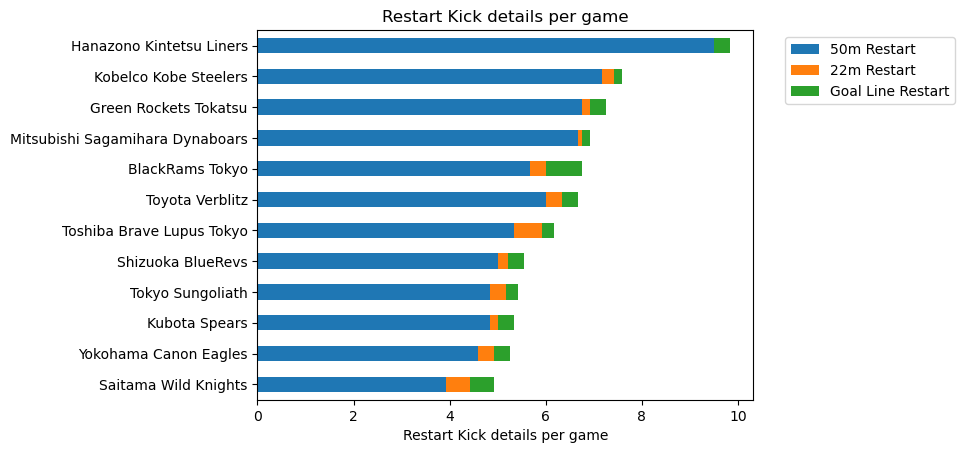

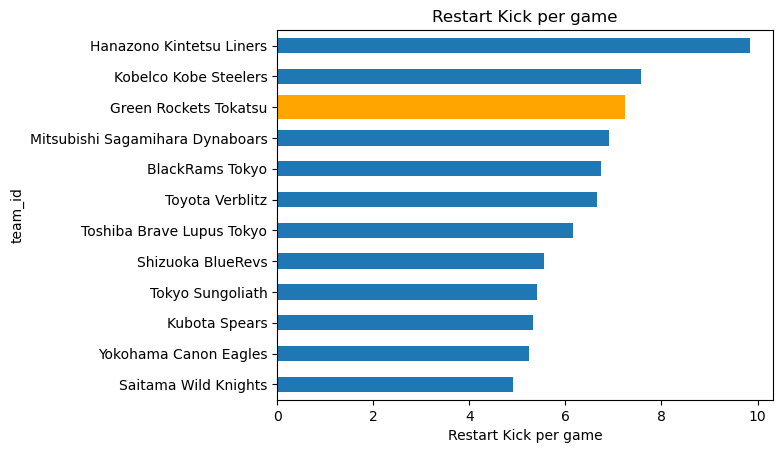

Ruck OOA of Mitsubishi Sagamihara Dynaboars


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          35   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         235   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                          39   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 5th+ Entry                          0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Conceded - Att Own Team 1st Entry                           9   
                       Own Team 2nd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         477   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                         338   
                       Own Team 2nd Entry                

Ruck OOA of Tokyo Sungoliath


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          49   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         324   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                          47   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           1   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           1   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Penalty Conceded - Att Own Team 1st Entry                           4   
                       Own Team 2nd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         607   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 4th Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                

Ruck OOA of Kubota Spears


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          47   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         262   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Failed Clearout        Own Team 1st Entry                          38   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Conceded - Att Own Team 1st Entry                           7   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         449   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                         231   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                

Ruck OOA of Shizuoka BlueRevs


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          78   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         226   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                          50   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Penalty Conceded - Att Own Team 1st Entry                           7   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
Secured                Own Team 1st Entry                         515   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Got Cleaned Out        Own Team 1st Entry                         203   
                       Own Team 2nd Entry                

Ruck OOA of Green Rockets Tokatsu


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          52   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         267   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                          65   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 5th+ Entry                          0   
Penalty Conceded - Att Own Team 1st Entry                           6   
                       Own Team 2nd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         420   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                         205   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                

Ruck OOA of BlackRams Tokyo


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          55   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         264   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Failed Clearout        Own Team 1st Entry                          44   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Penalty Conceded - Att Own Team 1st Entry                           8   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         521   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 5th+ Entry                          0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                

Ruck OOA of Toyota Verblitz


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          59   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         311   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                          43   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Conceded - Att Own Team 1st Entry                           5   
                       Own Team 2nd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         534   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Got Cleaned Out        Own Team 1st Entry                         241   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                         142   
                       Own Team 2nd Entry                

Ruck OOA of Yokohama Canon Eagles


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          39   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         238   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 5th+ Entry                          0   
Failed Clearout        Own Team 1st Entry                          40   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Conceded - Att Own Team 1st Entry                           8   
                       Own Team 2nd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         425   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 5th+ Entry                          0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                

Ruck OOA of Kobelco Kobe Steelers


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          59   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         276   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Failed Clearout        Own Team 1st Entry                          55   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 5th+ Entry                          0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Conceded - Att Own Team 1st Entry                          12   
                       Own Team 3rd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
Secured                Own Team 1st Entry                         457   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 4th Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                         191   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                         199   
                       Own Team 2nd Entry                

Ruck OOA of Toshiba Brave Lupus Tokyo


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          56   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         318   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                          55   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Conceded - Att Own Team 1st Entry                           8   
                       Own Team 2nd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         568   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 4th Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                

Ruck OOA of Saitama Wild Knights


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          66   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         386   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                          52   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Penalty Conceded - Att Own Team 1st Entry                           4   
                       Own Team 2nd Entry                           0   
                       Own Team 5th+ Entry                          0   
Penalty Won            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
Secured                Own Team 1st Entry                         439   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                

Ruck OOA of Hanazono Kintetsu Liners


qualifier3                                  OOA Entry 1st Entry - Att  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                          49   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                         246   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                          59   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Not Clearing           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Nuisance               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Penalty Conceded - Att Own Team 1st Entry                           4   
                       Own Team 3rd Entry                           0   
Penalty Won            Own Team 1st Entry                           0   
Secured                Own Team 1st Entry                         426   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Turnover Won           Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   

qualifier3                                  OOA Entry 1st Entry - Def  \
ActionType             Actionresult                                     
Attended               Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
                       Own Team 5th+ Entry                          0   
Cleaned Out            Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Failed Clearout        Own Team 1st Entry                           0   
                       Own Team 2nd Entry                           0   
                       Own Team 3rd Entry                           0   
                       Own Team 4th Entry                           0   
Got Cleaned Out        Own Team 1st Entry                

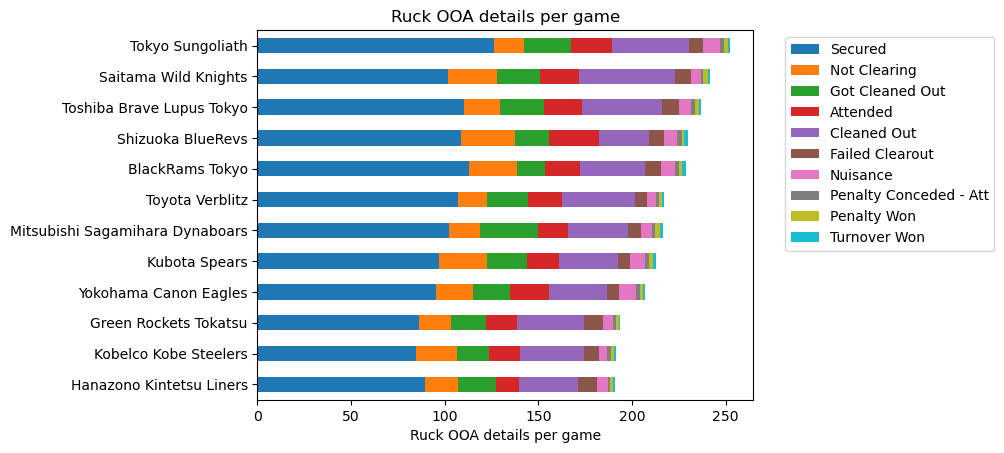

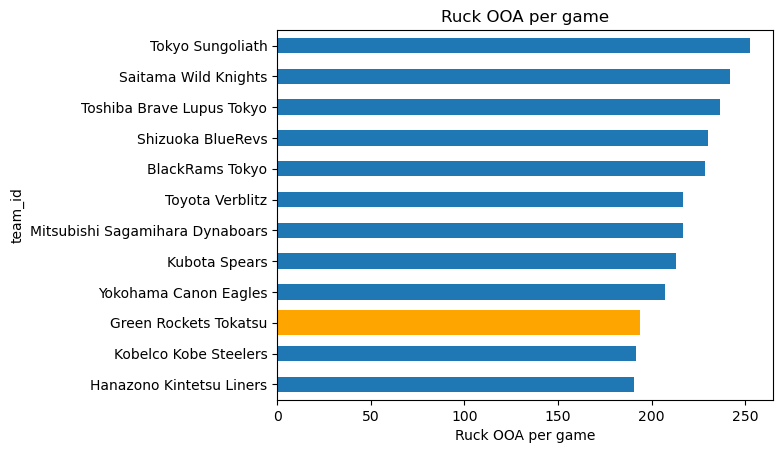

Collection of Mitsubishi Sagamihara Dynaboars


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             6
                     Success          7
Attacking Loose Ball Fail            14
                     Success         75
Charged Down         Success          7
Defensive Catch      Fail            13
                     Success         78
Defensive Loose Ball Fail            11
                     Success        140
General Catch        Fail             1
                     None          2156
                     Success          2
In Goal Touchdown    Success          2
Interception         Fail             2
                     Success          3
Jackal               Fail            13
                     Success         60
Mark                 Success          2
Restart Catch        Fail             3
                     None            14
                     Success         63
Tap Back             None             2
                     Success          1

Collection of Tokyo Sungoliath


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             4
                     Success          9
Attacking Loose Ball Fail            12
                     Success         78
Charged Down         Success          4
Defensive Catch      Fail            11
                     Success         85
Defensive Loose Ball Fail            13
                     Success        102
General Catch        Fail             1
                     None          2941
                     Success          2
In Goal Touchdown    Success          1
Interception         Fail             4
                     Success          2
Jackal               Fail            13
                     Success         41
Mark                 Success          3
Restart Catch        Fail             7
                     None            15
                     Success         80
Tap Back             None             1
                     Success          1

Collection of Kubota Spears


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail            16
                     Success         12
Attacking Loose Ball Fail            18
                     Success        100
Charged Down         Success          7
Defensive Catch      Fail            12
                     Success         85
Defensive Loose Ball Fail            15
                     Success        145
General Catch        Fail             3
                     None          2353
                     Success          1
In Goal Touchdown    Success          1
Interception         Fail             6
                     Success          8
Jackal               Fail            15
                     Success         55
Mark                 Success          4
Restart Catch        Fail             8
                     None            13
                     Success         93
Tap Back             None             2
                     Success          8

Collection of Shizuoka BlueRevs


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             7
                     Success          9
Attacking Loose Ball Fail            17
                     Success         77
Charged Down         Success          5
Defensive Catch      Fail            12
                     Success         83
Defensive Loose Ball Fail            18
                     Success        142
General Catch        None          2249
                     Success          1
In Goal Touchdown    Success          5
Interception         Fail             2
                     Success          6
Jackal               Fail            15
                     Success         45
Mark                 Success          6
Restart Catch        Fail             8
                     None            12
                     Success         55
Tap Back             Success          3

Collection of Green Rockets Tokatsu


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             1
                     Success          4
Attacking Loose Ball Fail            21
                     Success        101
Charged Down         Success          5
Defensive Catch      Fail            12
                     Success         70
Defensive Loose Ball Fail            14
                     Success        103
General Catch        Fail             3
                     None          2301
                     Success          1
In Goal Touchdown    Success          3
Interception         Fail             4
                     Success          7
Jackal               Fail             9
                     Success         29
Mark                 Success          3
Restart Catch        Fail             9
                     None            18
                     Success         43
Tap Back             Success          5

Collection of BlackRams Tokyo


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             3
                     Success          4
Attacking Loose Ball Fail            18
                     Success        107
Charged Down         Success         13
Defensive Catch      Fail            21
                     Success         91
Defensive Loose Ball Fail            22
                     Success        138
General Catch        Fail             2
                     None          2443
In Goal Touchdown    Success          2
Interception         Fail             2
                     Success          5
Jackal               Fail            10
                     Success         50
Mark                 Success          8
Restart Catch        Fail             3
                     None            21
                     Success         68
Tap Back             None             1
                     Success          3

Collection of Toyota Verblitz


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             3
                     Success          7
Attacking Loose Ball Fail            12
                     Success        118
Charged Down         Success          6
Defensive Catch      Fail            15
                     Success         91
Defensive Loose Ball Fail            14
                     Success        112
General Catch        Fail             2
                     None          2863
                     Success          2
In Goal Touchdown    Success          1
Interception         Success         12
Jackal               Fail             9
                     Success         37
Mark                 Success          4
Restart Catch        Fail            10
                     None            21
                     Success         65
Tap Back             None             1
                     Success          4

Collection of Yokohama Canon Eagles


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             5
                     Success         12
Attacking Loose Ball Fail            11
                     Success        100
Charged Down         Success          6
Defensive Catch      Fail             9
                     Success         85
Defensive Loose Ball Fail            14
                     Success        109
General Catch        Fail             3
                     None          2111
                     Success          4
In Goal Touchdown    Success          4
Interception         Fail             1
                     Success          6
Jackal               Fail            13
                     Success         38
Mark                 Success          8
Restart Catch        Fail             8
                     None            23
                     Success         67
Tap Back             Success          4

Collection of Kobelco Kobe Steelers


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Success          7
Attacking Loose Ball Fail            20
                     Success         85
Charged Down         Success          4
Defensive Catch      Fail            17
                     Success         80
Defensive Loose Ball Fail            10
                     Success        107
General Catch        Fail             2
                     None          2590
                     Success          1
Interception         Fail             3
                     Success          8
Jackal               Fail             7
                     Success         38
Mark                 Success          1
Restart Catch        Fail            11
                     None             8
                     Success         60
Tap Back             None             1
                     Success          6

Collection of Toshiba Brave Lupus Tokyo


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             8
                     Success          4
Attacking Loose Ball Fail             9
                     Success        103
Charged Down         Success          8
Defensive Catch      Fail            11
                     Success         99
Defensive Loose Ball Fail            15
                     Success        134
General Catch        None          2923
                     Success          2
In Goal Touchdown    Success          4
Interception         Fail             4
                     Success          6
Jackal               Fail            14
                     Success         46
Mark                 Success          2
Restart Catch        Fail            12
                     None            12
                     Success         76
Tap Back             None             1
                     Success          2

Collection of Saitama Wild Knights


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail            14
                     Success          9
Attacking Loose Ball Fail            17
                     Success        127
Charged Down         Success          9
Defensive Catch      Fail            15
                     Success        115
Defensive Loose Ball Fail            20
                     Success        124
General Catch        None          2996
In Goal Touchdown    Success          4
Interception         Fail             1
                     Success          8
Jackal               Fail             7
                     Success         49
Mark                 Success          7
Restart Catch        Fail             7
                     None            16
                     Success         66
Tap Back             None             4
                     Success          3

Collection of Hanazono Kintetsu Liners


qualifier3                         None
ActionType           Actionresult      
Attacking Catch      Fail             6
                     Success          6
Attacking Loose Ball Fail            22
                     Success         88
Charged Down         Success          4
Defensive Catch      Fail            14
                     Success        100
Defensive Loose Ball Fail            27
                     Success        114
General Catch        Fail             1
                     None          2396
In Goal Touchdown    Success          3
Interception         Fail             6
                     Success          6
Jackal               Fail             7
                     Success         30
Mark                 Success          2
Restart Catch        Fail             7
                     None             8
                     Success         39
Tap Back             Success          5

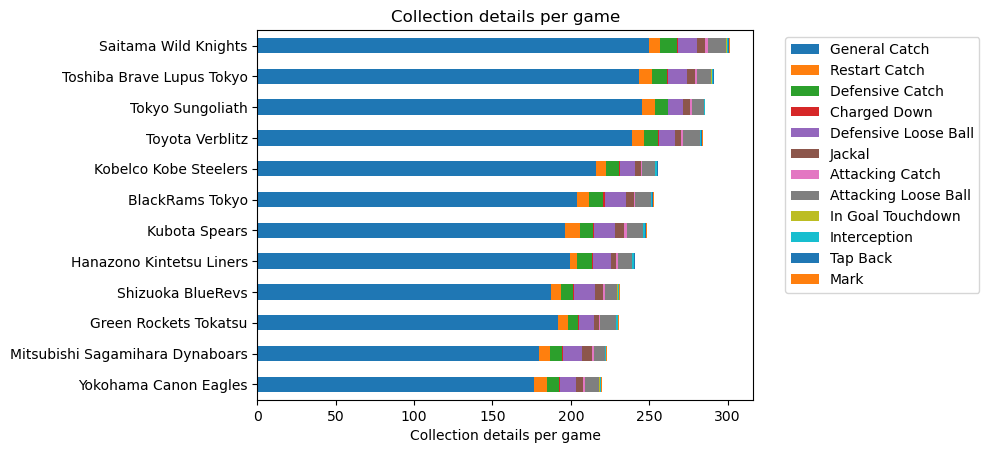

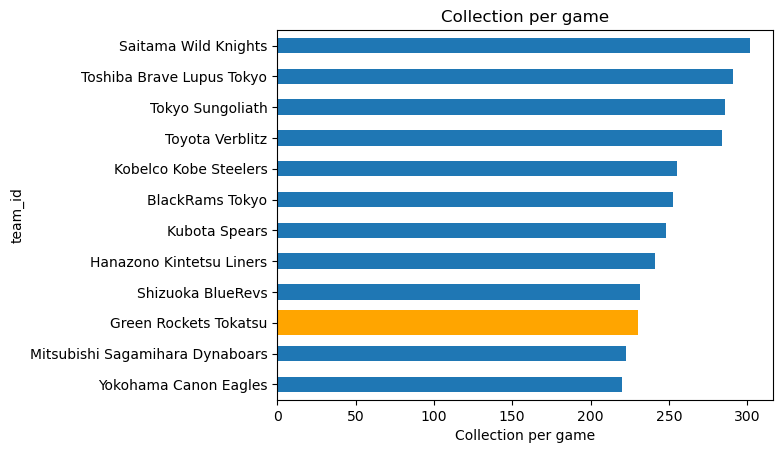

Playmaker Options of Mitsubishi Sagamihara Dynaboars


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    74
                             Playmaker Option - Pass     34
First Receiver               Playmaker Option - Carry   342
                             Playmaker Option - Kick     94
                             Playmaker Option - Pass    178
Halfback at Breakdown        Playmaker Option - Carry     6
                             Playmaker Option - Kick     76
                             Playmaker Option - Pass    587
Second Receiver              Playmaker Option - Carry    91
                             Playmaker Option - Kick      8
                             Playmaker Option - Pass     68
Third Receiver               Playmaker Option - Carry    46
                             Playmaker Option - Pass     14

Playmaker Options of Tokyo Sungoliath


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    74
                             Playmaker Option - Pass     42
First Receiver               Playmaker Option - Carry   483
                             Playmaker Option - Kick     69
                             Playmaker Option - Pass    315
Halfback at Breakdown        Playmaker Option - Carry     9
                             Playmaker Option - Kick     56
                             Playmaker Option - Pass    838
Second Receiver              Playmaker Option - Carry   192
                             Playmaker Option - Kick     13
                             Playmaker Option - Pass    103
Third Receiver               Playmaker Option - Carry    68
                             Playmaker Option - Kick      6
                             Playmaker Option - Pass     25

Playmaker Options of Kubota Spears


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    71
                             Playmaker Option - Pass     49
First Receiver               Playmaker Option - Carry   298
                             Playmaker Option - Kick    104
                             Playmaker Option - Pass    240
Halfback at Breakdown        Playmaker Option - Carry    10
                             Playmaker Option - Kick     48
                             Playmaker Option - Pass    601
Second Receiver              Playmaker Option - Carry   126
                             Playmaker Option - Kick      7
                             Playmaker Option - Pass     96
Third Receiver               Playmaker Option - Carry    64
                             Playmaker Option - Kick      4
                             Playmaker Option - Pass     25

Playmaker Options of Shizuoka BlueRevs


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    60
                             Playmaker Option - Kick      1
                             Playmaker Option - Pass     32
First Receiver               Playmaker Option - Carry   398
                             Playmaker Option - Kick     44
                             Playmaker Option - Pass    190
Halfback at Breakdown        Playmaker Option - Carry    12
                             Playmaker Option - Kick     78
                             Playmaker Option - Pass    682
Second Receiver              Playmaker Option - Carry   136
                             Playmaker Option - Kick      7
                             Playmaker Option - Pass     55
Third Receiver               Playmaker Option - Carry    44
                             Playmaker Option - Kick      4
                             Playmaker Option - Pass     13

Playmaker Options of Green Rockets Tokatsu


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    47
                             Playmaker Option - Pass     31
First Receiver               Playmaker Option - Carry   333
                             Playmaker Option - Kick     43
                             Playmaker Option - Pass    232
Halfback at Breakdown        Playmaker Option - Carry     9
                             Playmaker Option - Kick     58
                             Playmaker Option - Pass    621
Second Receiver              Playmaker Option - Carry   133
                             Playmaker Option - Kick      8
                             Playmaker Option - Pass     89
Third Receiver               Playmaker Option - Carry    60
                             Playmaker Option - Kick      1
                             Playmaker Option - Pass     26

Playmaker Options of BlackRams Tokyo


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    75
                             Playmaker Option - Kick      2
                             Playmaker Option - Pass     55
First Receiver               Playmaker Option - Carry   378
                             Playmaker Option - Kick    108
                             Playmaker Option - Pass    211
Halfback at Breakdown        Playmaker Option - Carry    17
                             Playmaker Option - Kick     35
                             Playmaker Option - Pass    667
Second Receiver              Playmaker Option - Carry   104
                             Playmaker Option - Kick     21
                             Playmaker Option - Pass     81
Third Receiver               Playmaker Option - Carry    38
                             Playmaker Option - Kick     11
                             Playmaker Option - Pass     27

Playmaker Options of Toyota Verblitz


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    69
                             Playmaker Option - Pass     41
First Receiver               Playmaker Option - Carry   341
                             Playmaker Option - Kick     88
                             Playmaker Option - Pass    340
Halfback at Breakdown        Playmaker Option - Carry    17
                             Playmaker Option - Kick     36
                             Playmaker Option - Pass    744
Second Receiver              Playmaker Option - Carry   199
                             Playmaker Option - Kick     19
                             Playmaker Option - Pass    113
Third Receiver               Playmaker Option - Carry    71
                             Playmaker Option - Kick      7
                             Playmaker Option - Pass     36

Playmaker Options of Yokohama Canon Eagles


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    64
                             Playmaker Option - Kick      1
                             Playmaker Option - Pass     42
First Receiver               Playmaker Option - Carry   278
                             Playmaker Option - Kick     78
                             Playmaker Option - Pass    187
Halfback at Breakdown        Playmaker Option - Carry    29
                             Playmaker Option - Kick     84
                             Playmaker Option - Pass    513
Second Receiver              Playmaker Option - Carry   103
                             Playmaker Option - Kick      6
                             Playmaker Option - Pass     73
Third Receiver               Playmaker Option - Carry    43
                             Playmaker Option - Kick      4
                             Playmaker Option - Pass     21

Playmaker Options of Kobelco Kobe Steelers


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    81
                             Playmaker Option - Pass     43
First Receiver               Playmaker Option - Carry   323
                             Playmaker Option - Kick     72
                             Playmaker Option - Pass    295
Halfback at Breakdown        Playmaker Option - Carry    20
                             Playmaker Option - Kick      7
                             Playmaker Option - Pass    670
Second Receiver              Playmaker Option - Carry   161
                             Playmaker Option - Kick      8
                             Playmaker Option - Pass    107
Third Receiver               Playmaker Option - Carry    78
                             Playmaker Option - Kick      4
                             Playmaker Option - Pass     21

Playmaker Options of Toshiba Brave Lupus Tokyo


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    80
                             Playmaker Option - Pass     92
First Receiver               Playmaker Option - Carry   414
                             Playmaker Option - Kick     66
                             Playmaker Option - Pass    291
Halfback at Breakdown        Playmaker Option - Carry    32
                             Playmaker Option - Kick     70
                             Playmaker Option - Pass    690
Second Receiver              Playmaker Option - Carry   169
                             Playmaker Option - Kick      5
                             Playmaker Option - Pass    104
Third Receiver               Playmaker Option - Carry    64
                             Playmaker Option - Kick      5
                             Playmaker Option - Pass     29

Playmaker Options of Saitama Wild Knights


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    61
                             Playmaker Option - Pass     58
First Receiver               Playmaker Option - Carry   324
                             Playmaker Option - Kick     97
                             Playmaker Option - Pass    363
Halfback at Breakdown        Playmaker Option - Carry    17
                             Playmaker Option - Kick     29
                             Playmaker Option - Pass    735
Second Receiver              Playmaker Option - Carry   203
                             Playmaker Option - Kick     12
                             Playmaker Option - Pass    139
Third Receiver               Playmaker Option - Carry    84
                             Playmaker Option - Kick      7
                             Playmaker Option - Pass     42

Playmaker Options of Hanazono Kintetsu Liners


qualifier3                                             None
ActionType                   Actionresult                  
Acting Halfback at Breakdown Playmaker Option - Carry    22
                             Playmaker Option - Pass     30
First Receiver               Playmaker Option - Carry   345
                             Playmaker Option - Kick     62
                             Playmaker Option - Pass    245
Halfback at Breakdown        Playmaker Option - Carry     7
                             Playmaker Option - Kick     39
                             Playmaker Option - Pass    651
Second Receiver              Playmaker Option - Carry   131
                             Playmaker Option - Kick     13
                             Playmaker Option - Pass     77
Third Receiver               Playmaker Option - Carry    37
                             Playmaker Option - Kick      5
                             Playmaker Option - Pass     23

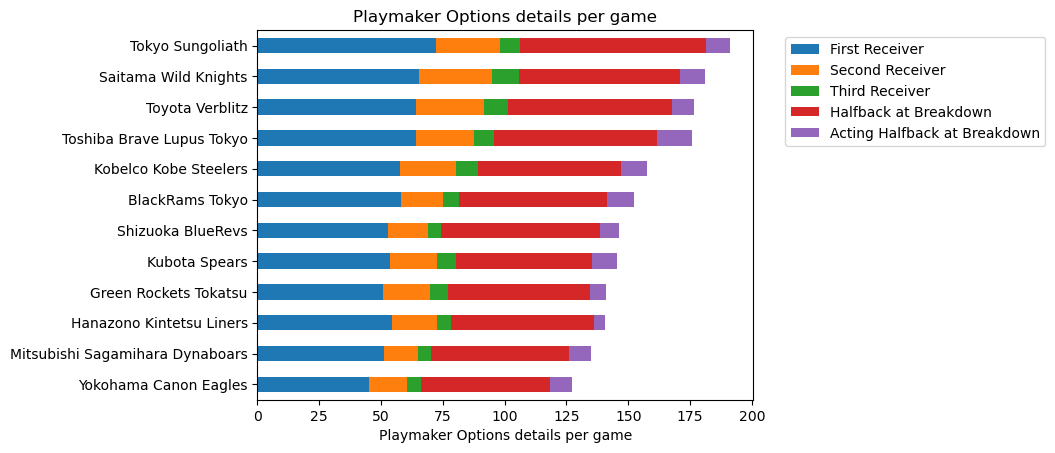

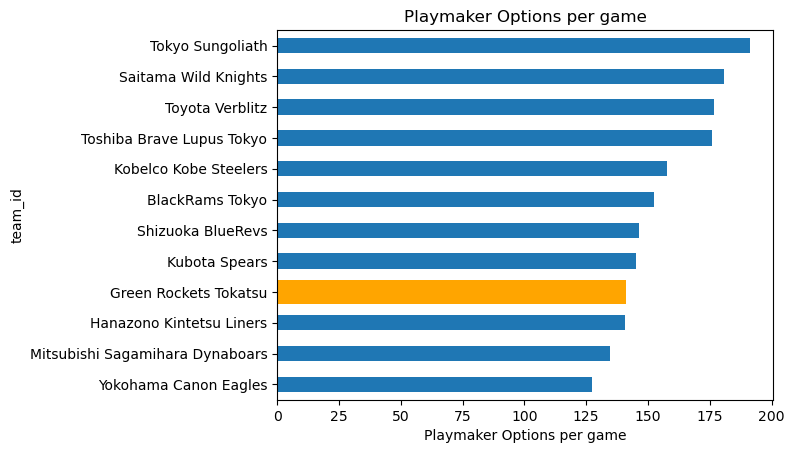

Kick of Mitsubishi Sagamihara Dynaboars


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                          9                      0   
            Collected Bounce                     3                      0   
            Own Player - Failed                  2                      0   
            Pressure Error                       2                      0   
Box         Caught Full                         42                      1   
            Collected Bounce                     5                      1   
            Error - Charged Down                 3                      0   
            Error - Out of Play                  1                      0   
            Kick in Touch (Full)                 1                     10   
            Own Player - Collected               4                      0   
            Own Player - Failed                  3                      0   
            Pressure Error                       4                      1   
Chip        Caught Full                          6                      1   
            Collected Bounce                     4                      0   
            Error - Charged Down                 1                      0   
            Error - Dead Ball                    1                      0   
            Own Player - Collected               3                      0   
            Pressure Error                       2                      0   
Cross Pitch Caught Full                          2                      0   
            Collected Bounce                     2                      0   
            Own Player - Collected               4                      1   
            Own Player - Failed                  2                      0   
Low         Collected Bounce                    12                      0   
            Error - Charged Down                 3                      0   
            Error - Dead Ball                    1                      0   
Territorial Caught Full                         38                     40   
            Collected Bounce                    28                      4   
            Error - Charged Down                 4                      0   
            Error - Dead Ball                    3                      0   
            In Goal                              2                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Failed                  1                      0   
            Pressure Carried Over                1                      1   
            Pressure in Touch                    1                      0   
Touch Kick  Error - Dead Ball                    0                      0   
            Error - Out of Play                  3                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               4                      2   
            Kick in Touch (Full)                 4                     38   
            Pressure Carried Over                0                      0   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Collected Bounce                     0  
            Own Player - Failed                  0  
            Pressure Error                       0  
Box         Caught Full                          0  
            Collected Bounce                     0  
            Error - Charged Down                 0  
            Error - Out of Play                  0  
            Kick in Touch (Full)                 0  
            Own Player - Collected               0  
            Own Player - Failed                  0  
            Pressure Error                       0  
Chip        Caught Full

Kick of Tokyo Sungoliath


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                          4                      1   
            Own Player - Collected               1                      0   
            Own Player - Failed                  1                      0   
            Pressure Error                       1                      0   
Box         Caught Full                         29                      0   
            Collected Bounce                     4                      0   
            Error - Charged Down                 1                      1   
            Kick in Touch (Bounce)               1                      1   
            Kick in Touch (Full)                 2                      6   
            Own Player - Collected               1                      0   
            Own Player - Failed                  3                      0   
            Pressure Carried Over                0                      1   
            Pressure Error                       2                      0   
Chip        Caught Full                          2                      0   
            Collected Bounce                     3                      0   
            Error - Charged Down                 1                      0   
            Own Player - Collected               2                      1   
            Pressure Error                       1                      0   
            Try Kick                             1                      0   
Cross Pitch Caught Full                          4                      0   
            Collected Bounce                     2                      1   
            Error - Charged Down                 1                      0   
            Kick in Touch (Bounce)               3                      0   
            Kick in Touch (Full)                 0                      1   
            Own Player - Collected               3                      0   
            Own Player - Failed                  1                      0   
            Pressure Error                       0                      1   
            Try Kick                             2                      0   
Low         Collected Bounce                    16                      0   
            Error - Dead Ball                    1                      0   
            In Goal                              0                      1   
            Kick in Touch (Full)                 0                      1   
            Own Player - Collected               6                      0   
            Try Kick                             1                      0   
Territorial Caught Full                         22                     29   
            Collected Bounce                    19                      7   
            Error - Charged Down                 3                      1   
            Error - Dead Ball                    1                      0   
            Kick in Touch (Bounce)               1                      0   
            Pressure Carried Over                1                      0   
            Pressure Error                       0                      1   
Touch Kick  Error - Dead Ball                    0                      2   
            Error - Out of Play                  2                      1   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               6                      3   
            Kick in Touch (Full)                 7                     40   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Own Player - Collected               0  
            Own Player - Failed                  0  
            Pressure Error            

Kick of Kubota Spears


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                         11                      5   
            Collected Bounce                     5                      2   
            Own Player - Collected               2                      2   
            Own Player - Failed                  1                      0   
            Pressure Error                       1                      1   
Box         Caught Full                         24                      1   
            Collected Bounce                     3                      1   
            Error - Charged Down                 2                      0   
            Error - Out of Play                  1                      0   
            Kick in Touch (Full)                 1                      5   
            Own Player - Collected               3                      1   
            Own Player - Failed                  5                      0   
            Pressure Error                       1                      0   
Chip        Caught Full                          4                      0   
            Collected Bounce                     6                      0   
            In Goal                              1                      0   
            Own Player - Collected               3                      0   
            Own Player - Failed                  3                      0   
            Pressure Error                       2                      0   
            Pressure in Touch                    2                      0   
Cross Pitch Caught Full                          3                      0   
            Error - Dead Ball                    1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               4                      1   
            Pressure Error                       1                      0   
            Try Kick                             4                      0   
Low         Collected Bounce                    10                      0   
            Error - Charged Down                 1                      0   
            Error - Dead Ball                    1                      0   
            In Goal                              1                      0   
            Kick in Touch (Bounce)               2                      1   
            Kick in Touch (Full)                 0                      1   
            Own Player - Collected               4                      0   
            Pressure Error                       2                      0   
Territorial Caught Full                         21                     31   
            Collected Bounce                    29                     14   
            Error - Charged Down                 5                      3   
            Error - Dead Ball                    3                      0   
            In Goal                              5                      0   
            Own Player - Collected               0                      1   
            Own Player - Failed                  1                      0   
            Pressure Error                       3                      1   
Touch Kick  Error - Out of Play                  4                      1   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               4                      0   
            Kick in Touch (Full)                 2                     49   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Collected Bounce                     0  
            Own Player - Collected               0  
            Own Player - Failed       

Kick of Shizuoka BlueRevs


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                          9                      0   
            Error - Out of Play                  1                      0   
            Own Player - Collected               2                      0   
            Own Player - Failed                  3                      0   
            Pressure Error                       1                      0   
Box         Caught Full                         26                      8   
            Collected Bounce                     6                      2   
            Error - Charged Down                 2                      1   
            Kick in Touch (Full)                 0                     13   
            Own Player - Collected               6                      0   
            Own Player - Failed                  2                      0   
            Pressure Error                       2                      0   
            Try Kick                             1                      0   
Chip        Caught Full                          1                      0   
            Collected Bounce                     2                      0   
            Kick in Touch (Full)                 1                      0   
            Own Player - Failed                  0                      1   
            Pressure Error                       1                      0   
Cross Pitch Caught Full                          2                      0   
            Error - Out of Play                  1                      0   
            Kick in Touch (Bounce)               1                      1   
            Own Player - Collected               3                      0   
Low         Collected Bounce                     9                      0   
            Error - Charged Down                 1                      0   
            Kick in Touch (Bounce)               4                      0   
            Own Player - Collected               2                      0   
            Pressure Error                       1                      0   
Territorial Caught Full                         32                     26   
            Collected Bounce                    17                      7   
            Error - Charged Down                 4                      1   
            Error - Dead Ball                    1                      0   
            Kick in Touch (Bounce)               2                      0   
            Own Player - Collected               3                      2   
            Own Player - Failed                  0                      1   
            Pressure Error                       2                      0   
Touch Kick  Error - Dead Ball                    0                      2   
            Error - Out of Play                  1                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               4                      2   
            Kick in Touch (Full)                 4                     50   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Error - Out of Play                  0  
            Own Player - Collected               0  
            Own Player - Failed                  0  
            Pressure Error                       0  
Box         Caught Full                          0  
            Collected Bounce                     0  
            Error - Charged Down                 0  
            Kick in Touch (Full)                 0  
            Own Player - Collected               0  
            Own Player - Failed                  0  
            Pressure Error                       0  
            Try Kick   

Kick of Green Rockets Tokatsu


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                         10                      0   
            Error - Out of Play                  1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               2                      1   
            Pressure Carried Over                1                      0   
            Pressure Error                       1                      0   
Box         Caught Full                         20                     11   
            Collected Bounce                     3                      1   
            Error - Charged Down                 1                      2   
            Error - Out of Play                  1                      0   
            Kick in Touch (Bounce)               3                      0   
            Kick in Touch (Full)                 0                      5   
            Own Player - Collected               3                      0   
            Pressure Error                       1                      0   
Chip        Caught Full                          7                      0   
            Collected Bounce                     7                      0   
            Error - Charged Down                 2                      0   
            Kick in Touch (Full)                 1                      0   
            Own Player - Collected               3                      0   
            Own Player - Failed                  1                      0   
Cross Pitch Collected Bounce                     1                      0   
            Own Player - Collected               1                      0   
Low         Collected Bounce                     9                      1   
            Error - Dead Ball                    0                      1   
            In Goal                              1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               3                      1   
            Try Kick                             1                      0   
Territorial Caught Full                         16                     16   
            Collected Bounce                    10                      5   
            Error - Charged Down                 2                      1   
            Error - Dead Ball                    2                      0   
            Kick in Touch (Bounce)               2                      0   
            Own Player - Collected               1                      0   
            Own Player - Failed                  1                      0   
            Pressure Carried Over                0                      1   
            Pressure Error                       2                      0   
Touch Kick  Error - Dead Ball                    0                      0   
            Error - Out of Play                  6                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               4                      2   
            Kick in Touch (Full)                 2                     28   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Error - Out of Play                  0  
            Kick in Touch (Bounce)               0  
            Own Player - Collected               0  
            Pressure Carried Over                0  
            Pressure Error                       0  
Box         Caught Full                          0  
            Collected Bounce                     0  
            Error - Charged Down                 0  
            Error - Out of P

Kick of BlackRams Tokyo


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                          4                      2   
            Collected Bounce                     1                      0   
            Own Player - Collected               2                      0   
            Pressure Error                       1                      0   
Box         Caught Full                         10                      1   
            Collected Bounce                     7                      0   
            Error - Charged Down                 2                      1   
            Kick in Touch (Bounce)               4                      0   
            Kick in Touch (Full)                 0                      4   
            Own Player - Collected               2                      0   
            Pressure Error                       2                      0   
Chip        Caught Full                          2                      0   
            Collected Bounce                     9                      0   
            Error - Charged Down                 1                      1   
            In Goal                              2                      0   
            Own Player - Collected               4                      0   
            Own Player - Failed                  1                      0   
            Pressure Carried Over                1                      0   
            Try Kick                             3                      0   
Cross Pitch Caught Full                          3                      0   
            Collected Bounce                     2                      1   
            Error - Out of Play                  1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               1                      1   
Low         Collected Bounce                     5                      3   
            Error - Charged Down                 4                      0   
            In Goal                              1                      0   
            Own Player - Collected               4                      2   
            Pressure Error                       2                      0   
Territorial Caught Full                         45                     48   
            Collected Bounce                    33                     21   
            Error - Charged Down                 1                      3   
            Error - Dead Ball                    1                      0   
            In Goal                              2                      0   
            Kick in Touch (Bounce)               2                      0   
            Own Player - Collected               2                      0   
            Pressure Carried Over                1                      0   
            Pressure Error                       1                      0   
Touch Kick  Error - Dead Ball                    0                      1   
            Error - Out of Play                  0                      2   
            Error - Territorial Loss             0                      0   
            In Goal                              0                      0   
            Kick in Touch (Bounce)               9                      0   
            Kick in Touch (Full)                 4                     37   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Collected Bounce                     0  
            Own Player - Collected               0  
            Pressure Error                       0  
Box         Caught Full                          0  
            Collected Bounce                     0  
            Error - Charged Down 

Kick of Toyota Verblitz


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                          8                      0   
            Own Player - Collected               3                      0   
            Own Player - Failed                  1                      0   
            Pressure Error                       1                      0   
Box         Caught Full                         14                      4   
            Collected Bounce                     3                      0   
            Error - Charged Down                 2                      0   
            Kick in Touch (Full)                 0                      4   
            Own Player - Collected               2                      0   
            Own Player - Failed                  1                      1   
Chip        Caught Full                          4                      0   
            Collected Bounce                    12                      2   
            Own Player - Collected               4                      0   
            Own Player - Failed                  1                      0   
            Try Kick                             1                      0   
Cross Pitch Caught Full                          2                      0   
            Collected Bounce                     1                      0   
            Error - Out of Play                  1                      0   
            Kick in Touch (Bounce)               2                      0   
            Own Player - Collected               4                      0   
Low         Collected Bounce                     7                      1   
            Error - Charged Down                 4                      0   
            In Goal                              1                      0   
            Kick in Touch (Bounce)               4                      0   
            Kick in Touch (Full)                 0                      1   
            Own Player - Collected               4                      0   
            Own Player - Failed                  3                      0   
            Pressure Carried Over                1                      0   
            Pressure Error                       2                      0   
Territorial Caught Full                         26                     28   
            Collected Bounce                    26                     15   
            Error - Charged Down                 5                      1   
            Error - Dead Ball                    2                      0   
            In Goal                              1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               4                      1   
            Pressure Error                       1                      0   
Touch Kick  Error - Dead Ball                    0                      0   
            Error - Out of Play                  3                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               3                      3   
            Kick in Touch (Full)                 3                     35   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Own Player - Collected               0  
            Own Player - Failed                  0  
            Pressure Error                       0  
Box         Caught Full                          0  
            Collected Bounce                     0  
            Error - Charged Down                 0  
            Kick in Touch (Full)                 0  
            Own Player - Collected               0  
            Own Player - Fai

Kick of Yokohama Canon Eagles


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                         11                      1   
            Collected Bounce                     1                      0   
            Own Player - Collected               3                      1   
            Pressure Error                       3                      0   
Box         Caught Full                         26                      4   
            Collected Bounce                    15                      0   
            Error - Charged Down                 4                      0   
            Error - Dead Ball                    1                      0   
            Error - Out of Play                  2                      0   
            Kick in Touch (Bounce)               3                      1   
            Kick in Touch (Full)                 1                      5   
            Own Player - Collected               2                      1   
            Own Player - Failed                  1                      0   
            Pressure Error                       6                      2   
Chip        Caught Full                          3                      0   
            Collected Bounce                     2                      0   
            Error - Charged Down                 1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               2                      0   
            Own Player - Failed                  1                      0   
            Try Kick                             2                      0   
Cross Pitch Collected Bounce                     1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               4                      3   
            Own Player - Failed                  2                      0   
            Pressure Carried Over                1                      0   
            Pressure Error                       1                      0   
Low         Collected Bounce                    18                      0   
            Error - Charged Down                 1                      0   
            Error - Out of Play                  1                      0   
            In Goal                              2                      0   
            Kick in Touch (Bounce)               4                      0   
            Own Player - Collected               7                      0   
            Own Player - Failed                  1                      0   
            Pressure Carried Over                2                      0   
            Pressure Error                       2                      0   
            Try Kick                             1                      0   
Territorial Caught Full                         26                     26   
            Collected Bounce                    23                     11   
            Error - Charged Down                 3                      0   
            Error - Dead Ball                    3                      1   
            Kick in Touch (Bounce)               2                      1   
            Own Player - Collected               5                      0   
            Own Player - Failed                  2                      0   
            Pressure Carried Over                1                      0   
Touch Kick  Error - Out of Play                  2                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               7                      2   
            Kick in Touch (Full)                 2                     30   
            Pressure Error                       0                      0

Kick of Kobelco Kobe Steelers


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Box         Collected Bounce                     1                      1   
            In Goal                              2                      0   
            Own Player - Collected               1                      0   
            Pressure Error                       2                      0   
Chip        Caught Full                          4                      0   
            Collected Bounce                     4                      0   
            Own Player - Collected               2                      1   
Cross Pitch Caught Full                          1                      0   
            Kick in Touch (Bounce)               1                      0   
            Kick in Touch (Full)                 2                      0   
            Own Player - Collected               5                      0   
            Own Player - Failed                  2                      0   
            Try Kick                             1                      0   
Low         Collected Bounce                     9                      1   
            Error - Charged Down                 2                      0   
            Error - Dead Ball                    1                      0   
            In Goal                              1                      0   
            Kick in Touch (Bounce)               3                      0   
            Own Player - Collected               3                      0   
            Own Player - Failed                  1                      0   
            Pressure Carried Over                2                      0   
            Pressure Error                       2                      0   
            Try Kick                             2                      0   
Territorial Caught Full                         23                     24   
            Collected Bounce                    20                      8   
            Error - Charged Down                 2                      1   
            Kick in Touch (Bounce)               1                      0   
            Pressure Carried Over                1                      2   
Touch Kick  Error - Dead Ball                    0                      0   
            Error - Out of Play                  1                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               4                      1   
            Kick in Touch (Full)                 3                     31   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Box         Collected Bounce                     0  
            In Goal                              0  
            Own Player - Collected               0  
            Pressure Error                       0  
Chip        Caught Full                          0  
            Collected Bounce                     0  
            Own Player - Collected               0  
Cross Pitch Caught Full                          0  
            Kick in Touch (Bounce)               0  
            Kick in Touch (Full)                 0  
            Own Player - Collected               0  
            Own Player - Failed                  0  
            Try Kick                             0  
Low         Collected Bounce                     0  
            Error - Charged Down                 0  
            Error - Dead Ball                    0  
            In Goal                              0  
            Kick in Touch (Bounce)               0  
            Own Player - Collected               0  
            Own Player - Failed                  0  
            Pressure Carried Over                0  
            Pressure Error                       0  
            Try Kick            

Kick of Toshiba Brave Lupus Tokyo


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Own Player - Failed                  1                      0   
Box         Caught Full                         26                      3   
            Collected Bounce                     7                      0   
            Error - Charged Down                 1                      0   
            Error - Dead Ball                    1                      0   
            Error - Out of Play                  0                      1   
            Kick in Touch (Bounce)               3                      1   
            Kick in Touch (Full)                 0                      6   
            Own Player - Collected               5                      1   
            Own Player - Failed                  1                      1   
            Pressure Error                       6                      1   
Chip        Caught Full                          2                      0   
            Collected Bounce                     6                      0   
            Error - Dead Ball                    1                      0   
            Error - Out of Play                  2                      0   
            Own Player - Collected               3                      0   
            Pressure Error                       1                      0   
            Try Kick                             1                      0   
Cross Pitch Caught Full                          1                      0   
            Collected Bounce                     1                      0   
            Own Player - Collected               1                      0   
Low         Caught Full                          1                      0   
            Collected Bounce                     9                      0   
            Error - Charged Down                 1                      0   
            Error - Dead Ball                    1                      0   
            In Goal                              2                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               3                      1   
            Own Player - Failed                  1                      0   
            Pressure Error                       1                      0   
Territorial Caught Full                         44                     18   
            Collected Bounce                    34                     11   
            Error - Charged Down                 3                      5   
            Error - Dead Ball                    1                      0   
            Kick in Touch (Bounce)               2                      1   
            Own Player - Failed                  2                      0   
            Pressure Carried Over                1                      0   
Touch Kick  Error - Dead Ball                    0                      0   
            Error - Out of Play                  2                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               4                      2   
            Kick in Touch (Full)                 3                     47   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Own Player - Failed                  0  
Box         Caught Full                          0  
            Collected Bounce                     0  
            Error - Charged Down                 0  
            Error - Dead Ball                    0  
            Error - Out of Play                  0  
            Kick in Touch (Bounce)               0  
            Kick in Touch (Full)                 0  
            Own Player - Collected               0  
            Own Player - Fai

Kick of Saitama Wild Knights


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                         20                      1   
            Collected Bounce                     2                      0   
            Own Player - Collected               5                      1   
            Own Player - Failed                  4                      0   
            Pressure Error                       2                      0   
Box         Caught Full                          8                      1   
            Collected Bounce                     6                      0   
            Kick in Touch (Full)                 0                      2   
            Own Player - Collected               1                      1   
            Own Player - Failed                  3                      0   
            Pressure Carried Over                1                      0   
            Pressure Error                       1                      0   
Chip        Caught Full                          6                      1   
            Collected Bounce                    10                      0   
            Error - Dead Ball                    1                      0   
            Error - Out of Play                  1                      0   
            In Goal                              1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               7                      0   
            Own Player - Failed                  3                      0   
            Pressure Error                       0                      1   
            Try Kick                             2                      0   
Cross Pitch Collected Bounce                     2                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               4                      1   
            Own Player - Failed                  2                      0   
Low         Collected Bounce                     5                      1   
            Error - Out of Play                  1                      0   
            Kick in Touch (Bounce)               6                      0   
            Kick in Touch (Full)                 0                      2   
            Own Player - Collected               7                      1   
            Own Player - Failed                  2                      0   
            Pressure Error                       1                      0   
            Pressure in Touch                    1                      0   
            Try Kick                             1                      0   
Territorial Caught Full                         39                     24   
            Collected Bounce                    36                     11   
            Error - Charged Down                 4                      2   
            Kick in Touch (Bounce)               3                      0   
            Own Player - Collected               2                      0   
            Own Player - Failed                  3                      0   
            Pressure Carried Over                1                      1   
            Pressure Error                       4                      2   
Touch Kick  Error - Out of Play                  3                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               7                      6   
            Kick in Touch (Full)                 5                     43   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Collected Bounce                     0  
            Ow

Kick of Hanazono Kintetsu Liners


qualifier3                            Kick in Play  Kick in Play (Own 22)  \
ActionType  Actionresult                                                    
Bomb        Caught Full                          8                      0   
            Collected Bounce                     1                      0   
            Pressure Error                       1                      0   
Box         Caught Full                         13                      3   
            Collected Bounce                     7                      1   
            Error - Dead Ball                    1                      0   
            Kick in Touch (Bounce)               2                      0   
            Kick in Touch (Full)                 0                      6   
            Own Player - Collected               1                      1   
            Own Player - Failed                  1                      0   
            Pressure Error                       0                      2   
Chip        Caught Full                          7                      0   
            Collected Bounce                     4                      0   
            Error - Dead Ball                    1                      0   
            Error - Out of Play                  1                      0   
            In Goal                              1                      0   
            Kick in Touch (Bounce)               1                      0   
            Own Player - Collected               4                      0   
            Own Player - Failed                  1                      0   
            Pressure Carried Over                1                      0   
            Try Kick                             1                      0   
Cross Pitch Caught Full                          2                      0   
            Collected Bounce                     1                      0   
            Own Player - Collected               2                      1   
            Own Player - Failed                  0                      2   
            Try Kick                             2                      0   
Low         Collected Bounce                    15                      0   
            Error - Charged Down                 1                      0   
            Error - Dead Ball                    1                      0   
            Kick in Touch (Bounce)               6                      0   
            Own Player - Collected               1                      0   
            Own Player - Failed                  2                      0   
Territorial Caught Full                         35                     17   
            Collected Bounce                    26                      9   
            Error - Charged Down                 3                      2   
            Error - Dead Ball                    1                      0   
            Kick in Touch (Bounce)               3                      0   
            Own Player - Collected               2                      0   
            Own Player - Failed                  1                      0   
            Pressure Error                       3                      0   
Touch Kick  Error - Charged Down                 0                      1   
            Error - Dead Ball                    0                      0   
            Error - Out of Play                  1                      0   
            Error - Territorial Loss             0                      0   
            Kick in Touch (Bounce)               7                      1   
            Kick in Touch (Full)                 0                     35   

qualifier3                            Penalty Kick  
ActionType  Actionresult                            
Bomb        Caught Full                          0  
            Collected Bounce                     0  
            Pressure Error                       0  
Box         Caught Full               

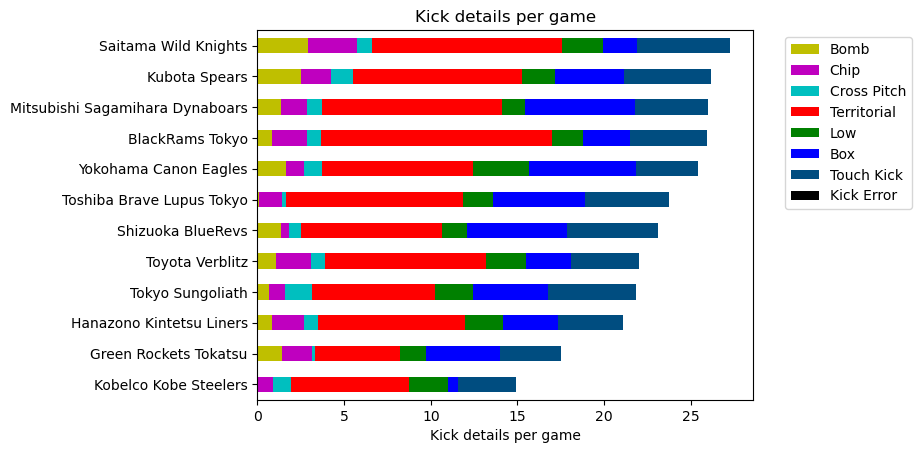

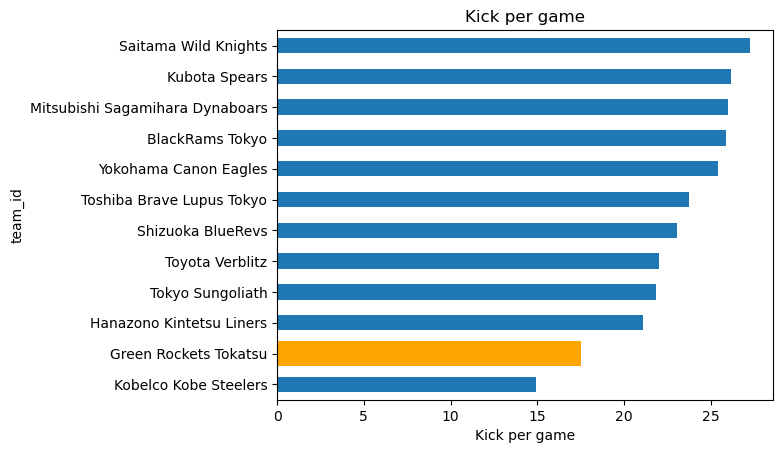

Tackle of Mitsubishi Sagamihara Dynaboars


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              4   114
             Forced in Touch       0     1
             Missed                0    50
             Offload Allowed       0    14
             Passive               5    58
             Pen Conceded          0     5
             Sack                  3    33
             Turnover Won          0     4
Cover Tackle Complete              1    14
             Ineffective           0    10
             Missed                0    36
             Offload Allowed       0    16
             Passive               0    26
             Pen Conceded          0     3
             Turnover Won          0     2
Edge Tackle  Complete              0    13
             Forced in Touch       0     1
             Ineffective           0     3
             Missed                0    39
             Offload Allowed       1    15
             Passive               0    16
             Pen Conceded          0     1
             Sack                  1     0
             Turnover Won          0     2
Guard Tackle Complete              1    25
             Ineffective           0     2
             Missed                0     7
             Offload Allowed       0     5
             Passive               1    18
             Pen Conceded          0     1
             Try Saver             0     2
             Turnover Won          0     2
Line Tackle  Complete             18   559
             Ineffective           0    12
             Missed                0   223
             Offload Allowed       0    91
             Passive              11   314
             Pen Conceded          0    17
             Sack                  3    38
             Turnover Won          0    14
Other Tackle Complete              0    44
             Forced in Touch       0     1
             Missed                0    30
             Offload Allowed       1     4
             Passive               2    38
             Pen Conceded          0     1
             Sack                  0     4
             Turnover Won          0     1

Tackle of Tokyo Sungoliath


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              4    91
             Forced in Touch       0     3
             Missed                0    38
             Offload Allowed       1    16
             Passive               2    29
             Pen Conceded          1     5
             Sack                  1    22
             Turnover Won          0     3
Cover Tackle Complete              0     7
             Forced in Touch       0     2
             Ineffective           0     6
             Missed                0    18
             Offload Allowed       0     6
             Passive               0    14
             Pen Conceded          0     2
             Sack                  0     1
Edge Tackle  Complete              2    12
             Forced in Touch       0     2
             Ineffective           0     3
             Missed                0    21
             Offload Allowed       0     7
             Passive               0     9
             Try Saver             0     1
             Turnover Won          0     2
Guard Tackle Complete              0    38
             Ineffective           0     3
             Missed                0     8
             Offload Allowed       0     3
             Passive               0     3
             Pen Conceded          0     1
             Try Saver             0     1
             Turnover Won          0     1
Line Tackle  Complete             41   662
             Forced in Touch       0     1
             Ineffective           0     7
             Missed                0   137
             Offload Allowed       2    69
             Passive               9   194
             Pen Conceded          0    15
             Sack                  4    45
             Try Saver             2     1
             Turnover Won          0    13
Other Tackle Complete              5    60
             Missed                0    24
             Offload Allowed       1    16
             Passive               1    13
             Sack                  1     3
             Try Saver             0     1
             Turnover Won          0     3

Tackle of Kubota Spears


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              3   129
             Forced in Touch       0     1
             Missed                0    55
             Offload Allowed       0    24
             Passive               1    33
             Pen Conceded          1     2
             Sack                  2    31
             Turnover Won          0     2
Cover Tackle Complete              0    21
             Forced in Touch       0     1
             Ineffective           0     7
             Missed                0    27
             Offload Allowed       0    15
             Passive               0    16
             Turnover Won          0     2
Edge Tackle  Complete              0    14
             Ineffective           0     4
             Missed                0    23
             Offload Allowed       0    10
             Passive               0    18
             Pen Conceded          0     3
             Sack                  0     3
             Turnover Won          0     1
Guard Tackle Complete              1    49
             Ineffective           0     1
             Missed                0    17
             Offload Allowed       0     8
             Passive               0    12
             Pen Conceded          0     1
             Sack                  0     2
             Try Saver             0     1
Line Tackle  Complete             38   712
             Forced in Touch       0     1
             Ineffective           0     8
             Missed                0   153
             Offload Allowed       3    90
             Passive              11   200
             Pen Conceded          0    10
             Sack                  8    50
             Try Saver             0     3
             Turnover Won          0    13
Other Tackle Complete              0    34
             Forced in Touch       1     1
             Missed                0    11
             Offload Allowed       0    14
             Passive               1    15
             Sack                  0     7
             Try Saver             0     4
             Turnover Won          0     3

Tackle of Shizuoka BlueRevs


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete             10   135
             Forced in Touch       0     2
             Missed                0    64
             Offload Allowed       0    13
             Passive               0    36
             Pen Conceded          0     3
             Sack                  0    10
             Turnover Won          0     1
Cover Tackle Complete              3    13
             Forced in Touch       0     1
             Ineffective           0     3
             Missed                0    28
             Offload Allowed       0    10
             Passive               1    12
             Turnover Won          0     4
Edge Tackle  Complete              3    22
             Forced in Touch       0     2
             Ineffective           0     1
             Missed                0    23
             Offload Allowed       0     8
             Passive               0     7
             Sack                  0     3
Guard Tackle Complete              2    35
             Ineffective           0     5
             Missed                0     9
             Offload Allowed       0     5
             Passive               0     8
             Sack                  0     4
             Try Saver             0     1
             Turnover Won          0     1
Line Tackle  Complete             55   806
             Forced in Touch       0     3
             Ineffective           0    12
             Missed                0   190
             Offload Allowed       0   109
             Passive              13   162
             Pen Conceded          1    16
             Sack                  6    49
             Try Saver             0     1
             Turnover Won          2    16
Other Tackle Complete              3    61
             Ineffective           0     1
             Missed                0    30
             Offload Allowed       0    12
             Passive               3    16
             Pen Conceded          0     1
             Sack                  0     8
             Turnover Won          0     6

Tackle of Green Rockets Tokatsu


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              2    91
             Forced in Touch       0     1
             Missed                0    52
             Offload Allowed       0    13
             Passive               1    37
             Pen Conceded          0     4
             Sack                  0    18
             Turnover Won          0     3
Cover Tackle Complete              3    27
             Forced in Touch       0     6
             Ineffective           0    14
             Missed                0    60
             Offload Allowed       1    24
             Passive               3    25
             Pen Conceded          0     1
             Sack                  0     1
             Try Saver             0     1
             Turnover Won          0     4
Edge Tackle  Complete              0    18
             Ineffective           0     2
             Missed                0    28
             Offload Allowed       0    14
             Passive               0    14
             Pen Conceded          0     1
             Sack                  0     1
Guard Tackle Complete              1    34
             Ineffective           0     4
             Missed                0    10
             Offload Allowed       0    10
             Passive               0    10
             Sack                  0     3
             Try Saver             0     1
             Turnover Won          0     1
Line Tackle  Complete             32   585
             Forced in Touch       0     4
             Ineffective           1    24
             Missed                0   202
             Offload Allowed       5    81
             Passive              17   244
             Pen Conceded          1    21
             Sack                  6    52
             Try Saver             1     8
             Turnover Won          0    16
Other Tackle Complete              9    49
             Ineffective           0     7
             Missed                0    35
             Offload Allowed       0    20
             Passive               2    32
             Pen Conceded          0     5
             Sack                  0     1
             Turnover Won          1     2

Tackle of BlackRams Tokyo


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete             10   118
             Missed                0    68
             Offload Allowed       0    20
             Passive               1    42
             Pen Conceded          0     4
             Sack                  1    14
             Turnover Won          0     4
Cover Tackle Complete              1    23
             Forced in Touch       0     1
             Ineffective           0     3
             Missed                0    24
             Offload Allowed       1    13
             Passive               0    23
             Sack                  0     2
             Try Saver             1     2
             Turnover Won          0     2
Edge Tackle  Complete              3    29
             Forced in Touch       0     3
             Ineffective           0     2
             Missed                0    20
             Offload Allowed       0    16
             Passive               1    14
             Pen Conceded          0     1
             Sack                  0     2
             Turnover Won          0     2
Guard Tackle Complete              0    40
             Ineffective           0     3
             Missed                0     5
             Offload Allowed       0     6
             Passive               0     9
             Try Saver             0     2
             Turnover Won          0     1
Line Tackle  Complete             38   593
             Ineffective           0    12
             Missed                0   128
             Offload Allowed       2   110
             Passive              11   177
             Pen Conceded          5    21
             Sack                  2    34
             Try Saver             1     3
             Turnover Won          1     7
Other Tackle Complete              2    51
             Missed                0    23
             Offload Allowed       0    11
             Passive               1    16
             Pen Conceded          0     3
             Sack                  0     4
             Try Saver             0     3
             Turnover Won          1     3

Tackle of Toyota Verblitz


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              1    90
             Missed                0    75
             Offload Allowed       0    18
             Passive               2    36
             Pen Conceded          0     4
             Sack                  0    12
             Turnover Won          0     1
Cover Tackle Complete              0    19
             Forced in Touch       0     3
             Ineffective           0     7
             Missed                0    19
             Offload Allowed       0    15
             Passive               2    19
             Pen Conceded          0     1
             Sack                  0     1
             Turnover Won          0     2
Edge Tackle  Complete              1    25
             Forced in Touch       0     2
             Ineffective           0     2
             Missed                0    29
             Offload Allowed       1    18
             Passive               1    16
             Sack                  0     2
             Turnover Won          0     1
Guard Tackle Complete              0    30
             Ineffective           0     5
             Missed                0    10
             Offload Allowed       0     3
             Passive               0     9
             Pen Conceded          0     1
             Sack                  0     5
Line Tackle  Complete             29   610
             Forced in Touch       0     1
             Ineffective           2    17
             Missed                0   163
             Offload Allowed       1   101
             Passive              10   202
             Pen Conceded          0    17
             Sack                  0    58
             Try Saver             0     4
             Turnover Won          0    17
Other Tackle Complete              5    50
             Ineffective           1     3
             Missed                0    22
             Offload Allowed       0    18
             Passive               0    33
             Sack                  0     6
             Turnover Won          0     2

Tackle of Yokohama Canon Eagles


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              6   111
             Forced in Touch       0     1
             Missed                0    44
             Offload Allowed       1    23
             Passive               2    32
             Pen Conceded          0     2
             Sack                  3    25
             Turnover Won          1     1
Cover Tackle Complete              1    18
             Ineffective           0     3
             Missed                0    28
             Offload Allowed       0    13
             Passive               0    16
             Pen Conceded          0     3
             Sack                  0     1
             Turnover Won          0     4
Edge Tackle  Complete              1    17
             Forced in Touch       1     2
             Ineffective           0     4
             Missed                0    16
             Offload Allowed       0     7
             Passive               0     9
             Pen Conceded          0     1
             Turnover Won          0     1
Guard Tackle Complete              0    27
             Forced in Touch       0     1
             Ineffective           0     2
             Missed                0     8
             Offload Allowed       0     5
             Passive               0     3
             Sack                  0     4
             Turnover Won          0     2
Line Tackle  Complete             35   654
             Ineffective           1    14
             Missed                0   168
             Offload Allowed       1    69
             Passive              14   185
             Pen Conceded          1    16
             Sack                  5    53
             Turnover Won          1    17
Other Tackle Complete              7    45
             Forced in Touch       0     2
             Ineffective           0     2
             Missed                0    26
             Offload Allowed       0    21
             Passive               2    23
             Sack                  0     1
             Try Saver             0     2
             Turnover Won          0     1

Tackle of Kobelco Kobe Steelers


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              3    83
             Forced in Touch       0     1
             Missed                0    32
             Offload Allowed       1     9
             Passive               2    25
             Pen Conceded          0     4
             Sack                  0     5
             Turnover Won          0     5
Cover Tackle Complete              1    25
             Ineffective           0     9
             Missed                0    34
             Offload Allowed       0    12
             Passive               1    18
             Turnover Won          0     3
Edge Tackle  Complete              0    20
             Forced in Touch       0     3
             Ineffective           0     3
             Missed                0    29
             Offload Allowed       0    10
             Passive               1    10
             Pen Conceded          0     2
             Sack                  0     3
             Turnover Won          0     1
Guard Tackle Complete              0    28
             Ineffective           0     3
             Missed                0    11
             Offload Allowed       0     6
             Passive               0     5
             Pen Conceded          0     1
             Sack                  0     2
             Try Saver             0     1
             Turnover Won          0     2
Line Tackle  Complete             41   785
             Forced in Touch       1     0
             Ineffective           0    20
             Missed                0   182
             Offload Allowed       4    93
             Passive               9   166
             Pen Conceded          0    19
             Sack                  6    47
             Try Saver             0     6
             Turnover Won          0     8
Other Tackle Complete              3    46
             Forced in Touch       0     2
             Ineffective           0     3
             Missed                0    23
             Offload Allowed       0    10
             Passive               0    17
             Pen Conceded          0     2
             Sack                  0     2
             Turnover Won          0     3

Tackle of Toshiba Brave Lupus Tokyo


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              4    99
             Forced in Touch       0     2
             Missed                0    31
             Offload Allowed       0    16
             Passive               3    20
             Pen Conceded          1     0
             Sack                  1    15
             Turnover Won          1     0
Cover Tackle Complete              0    18
             Forced in Touch       0     1
             Ineffective           0     8
             Missed                0    29
             Offload Allowed       0    10
             Passive               0    21
             Pen Conceded          0     1
             Turnover Won          0     3
Edge Tackle  Complete              1     9
             Ineffective           0     3
             Missed                0    19
             Offload Allowed       0     6
             Passive               0     9
             Sack                  1     2
             Turnover Won          0     1
Guard Tackle Complete              2    24
             Missed                0    14
             Offload Allowed       0     5
             Passive               0     7
             Turnover Won          0     1
Line Tackle  Complete             32   578
             Ineffective           0     4
             Missed                0   123
             Offload Allowed       0    34
             Passive              14   202
             Pen Conceded          1    17
             Sack                  7    60
             Try Saver             2     1
             Turnover Won          0     9
Other Tackle Complete              5    52
             Ineffective           0     1
             Missed                0    28
             Offload Allowed       0    11
             Passive               1    32
             Pen Conceded          0     3
             Sack                  1     4
             Turnover Won          0     2

Tackle of Saitama Wild Knights


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              7   110
             Forced in Touch       0     2
             Missed                0    46
             Offload Allowed       0    11
             Passive               6    35
             Pen Conceded          0     4
             Sack                  0    21
             Turnover Won          1     0
Cover Tackle Complete              0    18
             Ineffective           0     1
             Missed                0    12
             Offload Allowed       0     4
             Passive               0    15
             Pen Conceded          0     1
             Turnover Won          0     3
Edge Tackle  Complete              0    25
             Forced in Touch       0     2
             Ineffective           0     1
             Missed                0    24
             Offload Allowed       0    14
             Passive               0     3
Guard Tackle Complete              0    22
             Ineffective           0     3
             Missed                0     6
             Offload Allowed       0     3
             Passive               1     5
             Pen Conceded          0     1
             Sack                  0     4
             Turnover Won          0     1
Line Tackle  Complete             35   769
             Ineffective           0    13
             Missed                0   145
             Offload Allowed       3    75
             Passive              12   150
             Pen Conceded          0    22
             Sack                  6    43
             Try Saver             0     3
             Turnover Won          1    14
Other Tackle Complete              3    63
             Forced in Touch       0     1
             Missed                0    19
             Offload Allowed       0     7
             Passive               0    14
             Pen Conceded          0     2
             Sack                  0     6
             Turnover Won          0     3

Tackle of Hanazono Kintetsu Liners


qualifier3                    Assist  None
ActionType   Actionresult                 
Chase Tackle Complete              6   106
             Forced in Touch       0     3
             Missed                0    66
             Offload Allowed       2    29
             Passive               2    50
             Pen Conceded          0     2
             Sack                  0    12
             Turnover Won          0     3
Cover Tackle Complete              1    23
             Forced in Touch       0     3
             Ineffective           0    11
             Missed                1    66
             Offload Allowed       1    30
             Passive               1    30
             Pen Conceded          0     3
             Sack                  0     1
             Turnover Won          0     2
Edge Tackle  Complete              0    19
             Forced in Touch       0     1
             Ineffective           0     1
             Missed                0    33
             Offload Allowed       0    14
             Passive               0    15
Guard Tackle Complete              2    20
             Ineffective           0     4
             Missed                0     8
             Offload Allowed       0     2
             Passive               0    14
             Pen Conceded          0     1
             Turnover Won          0     1
Line Tackle  Complete             23   681
             Ineffective           1    15
             Missed                0   248
             Offload Allowed       4   119
             Passive              14   258
             Pen Conceded          0    22
             Sack                  5    35
             Try Saver             0     2
             Turnover Won          2     9
Other Tackle Complete              4    60
             Ineffective           1     4
             Missed                0    34
             Offload Allowed       0    17
             Passive               1    29
             Pen Conceded          0     1
             Sack                  1     2

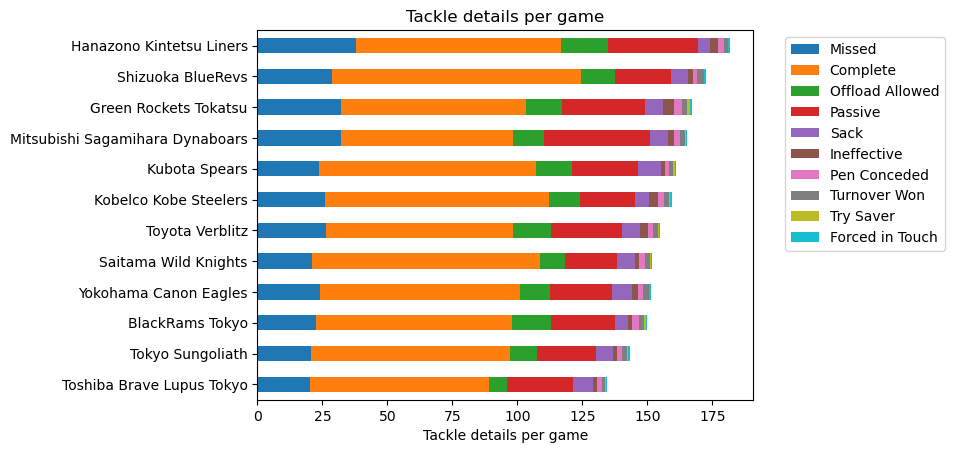

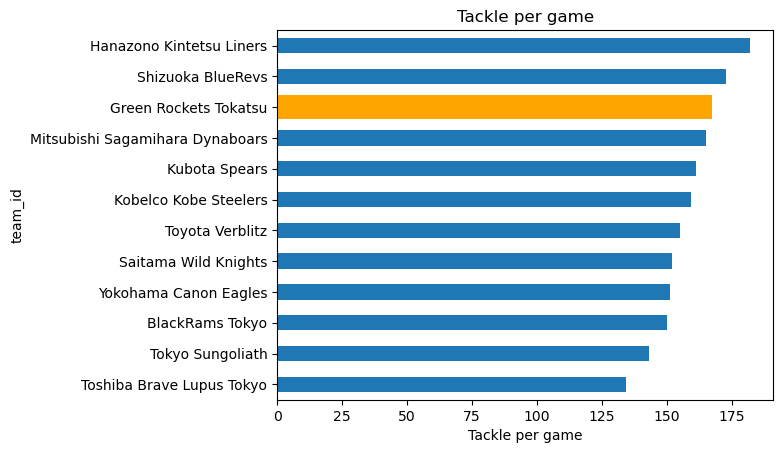

Missed Tackle of Mitsubishi Sagamihara Dynaboars


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     18
           Tackled        166
           Try             33
Outpaced   Clean Break      4
           Tackled          6
           Try             10
Positional Clean Break     15
           Tackled         12
           Try             12
Stepped    Clean Break     19
           Tackled         76
           Try             14

Missed Tackle of Tokyo Sungoliath


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     21
           Tackled        145
           Try              9
Outpaced   Clean Break      1
           Tackled          4
           Try              3
Positional Clean Break      5
           Tackled          7
           Try              5
Stepped    Clean Break      6
           Tackled         36
           Try              4

Missed Tackle of Kubota Spears


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     19
           Tackled        142
           Try             18
Outpaced   Clean Break      1
           Try              8
Positional Clean Break      8
           Tackled          8
           Try             10
Stepped    Clean Break      5
           Tackled         55
           Try             12

Missed Tackle of Shizuoka BlueRevs


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     17
           Tackled        185
           Try             13
Outpaced   Clean Break      5
           Tackled          5
           Try              6
Positional Clean Break      6
           Tackled         14
           Try              4
Stepped    Clean Break     16
           Tackled         66
           Try              7

Missed Tackle of Green Rockets Tokatsu


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     54
           Tackled        161
           Try             32
Outpaced   Clean Break      6
           Tackled          1
           Try             10
Positional Clean Break     24
           Tackled         14
           Try             22
Stepped    Clean Break     20
           Tackled         39
           Try              4

Missed Tackle of BlackRams Tokyo


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     22
           Tackled        114
           Try              8
Outpaced   Clean Break      4
           Tackled          5
           Try              3
Positional Clean Break     14
           Tackled         12
           Try              7
Stepped    Clean Break     18
           Tackled         54
           Try              7

Missed Tackle of Toyota Verblitz


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     17
           Tackled        157
           Try             18
Outpaced   Clean Break      5
           Tackled          1
           Try              4
Positional Clean Break     11
           Tackled         18
           Try             11
Stepped    Clean Break     11
           Tackled         62
           Try              3

Missed Tackle of Yokohama Canon Eagles


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     28
           Tackled        133
           Try             15
Outpaced   Clean Break      5
           Tackled          2
           Try              1
Positional Clean Break     15
           Tackled         17
           Try              6
Stepped    Clean Break      8
           Tackled         56
           Try              4

Missed Tackle of Kobelco Kobe Steelers


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     29
           Tackled        126
           Try             32
Outpaced   Clean Break      8
           Tackled          2
           Try              7
Positional Clean Break     12
           Tackled         12
           Try             13
Stepped    Clean Break     11
           Tackled         47
           Try             12

Missed Tackle of Toshiba Brave Lupus Tokyo


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     18
           Tackled        102
           Try             15
Outpaced   Clean Break      1
           Tackled          1
           Try             10
Positional Clean Break     13
           Tackled         11
           Try             17
Stepped    Clean Break      8
           Tackled         38
           Try             10

Missed Tackle of Saitama Wild Knights


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     17
           Tackled        129
           Try             11
Outpaced   Clean Break      4
           Tackled          2
           Try              3
Positional Clean Break      3
           Tackled         20
           Try              6
Stepped    Clean Break      8
           Tackled         48
           Try              1

Missed Tackle of Hanazono Kintetsu Liners


qualifier3               None
ActionType Actionresult      
Bumped Off Clean Break     36
           Tackled        198
           Try             45
Outpaced   Clean Break      5
           Try             15
Positional Clean Break     13
           Tackled         16
           Try             14
Stepped    Clean Break     21
           Tackled         70
           Try             23

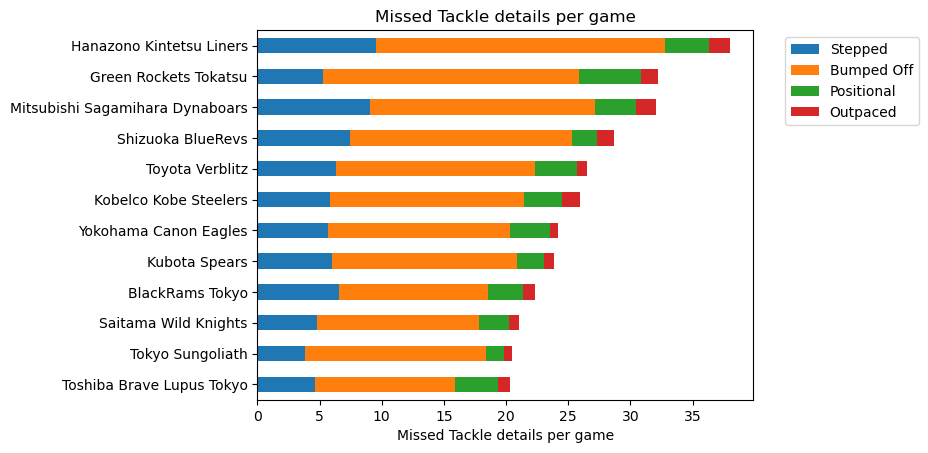

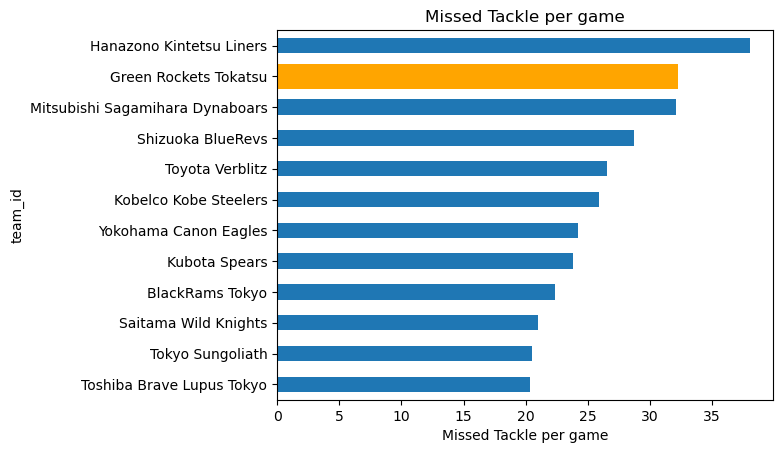

Defensive Action of Mitsubishi Sagamihara Dynaboars


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None            10
Tackle Arrival      None           210

Defensive Action of Tokyo Sungoliath


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             7
Tackle Arrival      None           160

Defensive Action of Kubota Spears


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             9
Tackle Arrival      None           173

Defensive Action of Shizuoka BlueRevs


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             4
Tackle Arrival      None           135

Defensive Action of Green Rockets Tokatsu


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             3
Tackle Arrival      None           160

Defensive Action of BlackRams Tokyo


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             1
Tackle Arrival      None           112

Defensive Action of Toyota Verblitz


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             7
Tackle Arrival      None           143

Defensive Action of Yokohama Canon Eagles


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             6
Tackle Arrival      None           134

Defensive Action of Kobelco Kobe Steelers


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             3
Tackle Arrival      None           110

Defensive Action of Toshiba Brave Lupus Tokyo


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             3
Tackle Arrival      None           120

Defensive Action of Saitama Wild Knights


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             7
Tackle Arrival      None           142

Defensive Action of Hanazono Kintetsu Liners


qualifier3                        None
ActionType          Actionresult      
Aerial Kick Contest None             5
Tackle Arrival      None           158

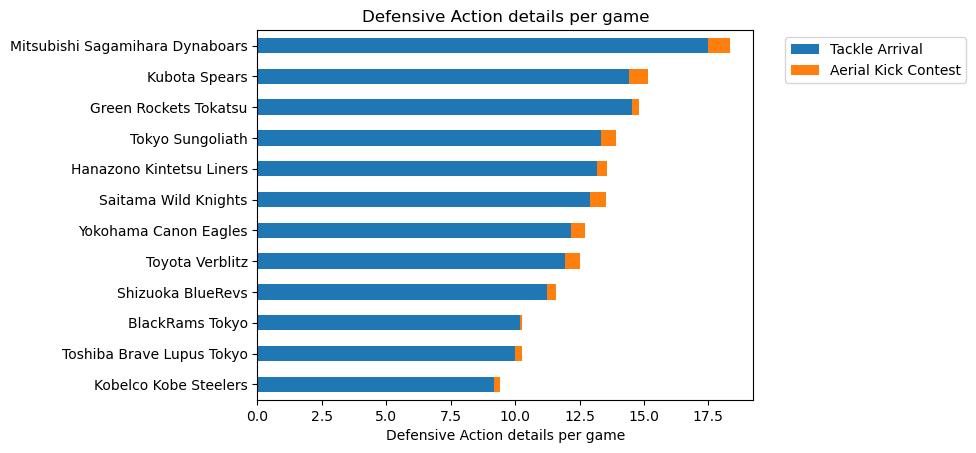

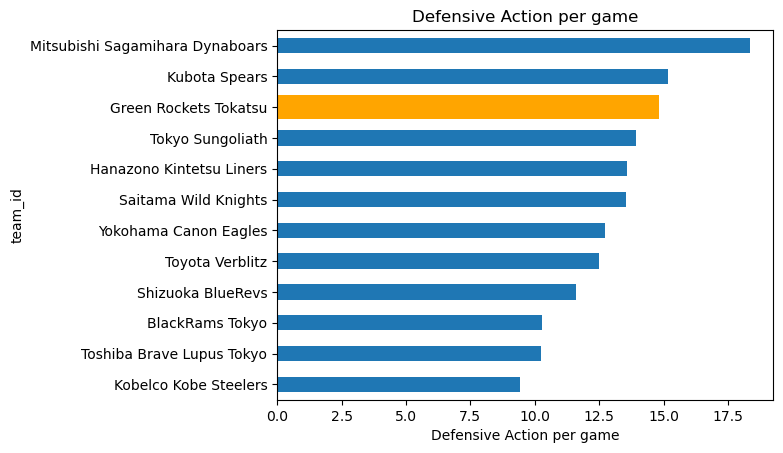

Carry of Mitsubishi Sagamihara Dynaboars


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                0                 5   
               Kick                                 2                 8   
               Off Load                             3                 6   
               Pass                                 1                 3   
               Pen Conceded                         1                 1   
               Penalty Won                          0                 1   
               Tackled Dominant                     6                11   
               Tackled Ineffective                  3                11   
               Tackled Neutral                      6                22   
One Out Drive  Error                                5                 7   
               Off Load                             8                 3   
               Other                                0                 1   
               Pass                                 1                 0   
               Pen Conceded                         0                 3   
               Tackled Dominant                    43                 9   
               Tackled Ineffective                  3                10   
               Tackled Neutral                     98                87   
               Try Scored                           3                 0   
Other Carry    Error                               11                 8   
               Kick                                 4                 2   
               Off Load                            19                15   
               Other                                1                 1   
               Pass                                16                 6   
               Pen Conceded                         5                 2   
               Penalty Won                          2                 1   
               Tackled Dominant                    67                14   
               Tackled Ineffective                  2                 8   
               Tackled Neutral                     70                72   
               Try Scored                          24                 0   
Pick and Go    Error                                3                 0   
               Off Load                             2                 2   
               Pass                                 2                 1   
               Pen Conceded                         1                 0   
               Tackled Dominant                    12                 0   
               Tackled Ineffective                  2                 1   
               Tackled Neutral                     30                 2   
               Try Scored                           4                 0   
Restart Return Error                                0                 2   
               Kick                                 0                 2   
               Off Load                             0                 2   
               Penalty Won                          0                 1   
               Tackled Dominant                     3                13   
               Tackled Ineffective                  0                 3   
               Tackled Neutral                      5                28   
Support Carry  Error                                2                 1   
               Off Load                             2                 5   
               Other                                2                 0   
               Pass                                 4                 0   
               Pen Conceded                         0                 1   
               Penalty Won                          0                 1   
               Tackled Dominant                    10                 1   
               Tackled In

Carry of Tokyo Sungoliath


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                1                 4   
               Kick                                 1                 8   
               Off Load                             7                 8   
               Pass                                 5                 4   
               Pen Conceded                         0                 2   
               Tackled Dominant                     7                 8   
               Tackled Ineffective                  0                 8   
               Tackled Neutral                     12                20   
One Out Drive  Error                                3                 1   
               Off Load                            14                 8   
               Other                                2                 1   
               Pass                                 2                 0   
               Pen Conceded                         1                 2   
               Penalty Won                          0                 1   
               Tackled Dominant                    69                11   
               Tackled Ineffective                  4                12   
               Tackled Neutral                    139               112   
               Try Scored                           6                 0   
Other Carry    Error                               18                 9   
               Kick                                 9                 1   
               None                                 0                 1   
               Off Load                            50                28   
               Other                                6                 1   
               Pass                                34                17   
               Pen Conceded                         5                 3   
               Penalty Won                          2                 2   
               Tackled Dominant                    80                18   
               Tackled Ineffective                  1                15   
               Tackled Neutral                     99                94   
               Try Scored                          34                 0   
Pick and Go    Error                                4                 1   
               Kick                                 1                 0   
               Off Load                             2                 1   
               Pass                                 3                 0   
               Pen Conceded                         2                 0   
               Tackled Dominant                    10                 0   
               Tackled Ineffective                  3                 0   
               Tackled Neutral                     26                 1   
               Try Scored                           3                 0   
Restart Return Off Load                             1                 2   
               Other                                1                 0   
               Pen Conceded                         0                 1   
               Tackled Dominant                     2                 9   
               Tackled Ineffective                  0                 3   
               Tackled Neutral                     10                37   
Support Carry  Error                                3                 1   
               Kick                                 1                 0   
               Off Load                            15                 6   
               Other                                3                 1   
               Pass                                 5                 1   
               Pen Conceded                         1                 0   
               Tackled Do

Carry of Kubota Spears


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                1                 4   
               Kick                                 3                 4   
               Off Load                             5                15   
               Pass                                 6                 4   
               Pen Conceded                         1                 2   
               Tackled Dominant                    10                 7   
               Tackled Ineffective                  3                 6   
               Tackled Neutral                     14                18   
One Out Drive  Error                                2                 2   
               Kick                                 0                 1   
               None                                 0                 1   
               Off Load                             8                 3   
               Pass                                 1                 0   
               Pen Conceded                         2                 2   
               Penalty Won                          0                 1   
               Tackled Dominant                    40                13   
               Tackled Ineffective                  1                 7   
               Tackled Neutral                     93                65   
               Try Scored                           6                 0   
Other Carry    Error                               17                 8   
               Kick                                 8                 4   
               Off Load                            40                12   
               Other                                3                 1   
               Pass                                42                23   
               Pen Conceded                         2                 2   
               Penalty Won                          0                 1   
               Tackled Dominant                    81                18   
               Tackled Ineffective                  3                 7   
               Tackled Neutral                     84                57   
               Try Scored                          37                 0   
Pick and Go    Error                                5                 3   
               Kick                                 1                 0   
               Off Load                             5                 0   
               Pass                                 2                 1   
               Pen Conceded                         1                 0   
               Tackled Dominant                    18                 0   
               Tackled Ineffective                  0                 4   
               Tackled Neutral                     26                 2   
               Try Scored                           7                 0   
Restart Return Error                                0                 1   
               Kick                                 0                 2   
               Off Load                             1                 0   
               Pass                                 1                 1   
               Pen Conceded                         0                 1   
               Penalty Won                          0                 1   
               Tackled Dominant                     3                11   
               Tackled Ineffective                  0                 7   
               Tackled Neutral                      8                38   
Support Carry  Error                                4                 0   
               Kick                                 2                 2   
               Off Load                            19                 3   
               Other     

Carry of Shizuoka BlueRevs


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                1                 5   
               Kick                                 4                15   
               Off Load                             2                 2   
               Other                                0                 1   
               Pass                                 0                 3   
               Pen Conceded                         1                 0   
               Penalty Won                          0                 1   
               Tackled Dominant                     2                 9   
               Tackled Ineffective                  0                12   
               Tackled Neutral                      3                23   
One Out Drive  Error                                3                 4   
               Off Load                             7                 2   
               Other                                0                 1   
               Pass                                 1                 1   
               Pen Conceded                         6                 3   
               Penalty Won                          0                 1   
               Tackled Dominant                    60                 9   
               Tackled Ineffective                  4                13   
               Tackled Neutral                    116               104   
               Try Scored                           4                 0   
Other Carry    Error                                8                 3   
               Kick                                 4                 3   
               Off Load                            19                20   
               Other                                5                 1   
               Pass                                25                11   
               Pen Conceded                         4                 1   
               Penalty Won                          1                 1   
               Tackled Dominant                    57                 8   
               Tackled Ineffective                  1                16   
               Tackled Neutral                    101                71   
               Try Scored                          20                 0   
Pick and Go    Error                                0                 1   
               Kick                                 2                 0   
               Off Load                             3                 1   
               Other                                0                 1   
               Pass                                 2                 1   
               Pen Conceded                         1                 0   
               Penalty Won                          1                 0   
               Tackled Dominant                     9                 0   
               Tackled Ineffective                  1                 0   
               Tackled Neutral                     21                 2   
               Try Scored                           6                 0   
Restart Return Error                                0                 2   
               Off Load                             0                 2   
               Other                                0                 1   
               Penalty Won                          0                 1   
               Tackled Dominant                     1                 8   
               Tackled Ineffective                  0                 1   
               Tackled Neutral                      3                26   
Support Carry  Error                                4                 0   
               Off Load                             6                 0   
               Pass      

Carry of Green Rockets Tokatsu


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                0                 7   
               Kick                                 2                 8   
               Off Load                             3                 8   
               Pass                                 2                 5   
               Pen Conceded                         1                 1   
               Penalty Won                          0                 1   
               Tackled Dominant                     4                 6   
               Tackled Ineffective                  1                10   
               Tackled Neutral                     10                14   
One Out Drive  Error                                5                 2   
               Off Load                            12                 4   
               Pen Conceded                         3                 2   
               Penalty Won                          1                 0   
               Tackled Dominant                    51                 9   
               Tackled Ineffective                  1                13   
               Tackled Neutral                    104                70   
               Try Scored                           6                 0   
Other Carry    Error                                9                 7   
               Kick                                 5                 0   
               None                                 0                 1   
               Off Load                            42                44   
               Other                                1                 2   
               Pass                                26                23   
               Pen Conceded                         8                 6   
               Penalty Won                          2                 2   
               Tackled Dominant                    67                21   
               Tackled Ineffective                  0                11   
               Tackled Neutral                     99                62   
               Try Scored                          19                 0   
Pick and Go    Error                                2                 0   
               None                                 0                 1   
               Off Load                             6                 0   
               Pass                                 1                 1   
               Tackled Dominant                     8                 1   
               Tackled Neutral                     12                 4   
               Try Scored                           1                 0   
Restart Return Kick                                 1                 0   
               Off Load                             0                 1   
               Pen Conceded                         0                 1   
               Tackled Dominant                     3                 8   
               Tackled Ineffective                  1                 3   
               Tackled Neutral                      0                22   
Support Carry  Error                                5                 2   
               Off Load                            11                 6   
               Other                                1                 0   
               Pass                                 3                 4   
               Pen Conceded                         1                 0   
               Tackled Dominant                    16                 2   
               Tackled Ineffective                  2                 1   
               Tackled Neutral                     16                15   
               Try Scored                           4                 0   

qualifier3              

Carry of BlackRams Tokyo


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                2                 7   
               Kick                                 6                 7   
               Off Load                            10                 6   
               Other                                0                 1   
               Pass                                12                 6   
               Pen Conceded                         1                 1   
               Penalty Won                          1                 0   
               Tackled Dominant                     8                 9   
               Tackled Ineffective                  3                 5   
               Tackled Neutral                     17                21   
               Try Scored                           1                 0   
One Out Drive  Error                                2                 7   
               Kick                                 0                 1   
               None                                 0                 1   
               Off Load                             8                 4   
               Pass                                 3                 1   
               Pen Conceded                         3                 1   
               Penalty Won                          0                 0   
               Tackled Dominant                    38                12   
               Tackled Ineffective                  1                11   
               Tackled Neutral                    104               116   
               Try Scored                           2                 0   
Other Carry    Error                               11                 8   
               Kick                                 4                 4   
               Off Load                            38                21   
               Other                                2                 0   
               Pass                                22                24   
               Pen Conceded                         5                 2   
               Penalty Won                          2                 1   
               Tackled Dominant                    57                17   
               Tackled Ineffective                  2                11   
               Tackled Neutral                     83                70   
               Try Scored                          27                 0   
Pick and Go    Error                                1                 1   
               Off Load                             2                 2   
               Other                                1                 1   
               Pass                                 1                 4   
               Pen Conceded                         1                 0   
               Penalty Won                          1                 0   
               Tackled Dominant                    20                 0   
               Tackled Ineffective                  0                 5   
               Tackled Neutral                     34                 3   
               Try Scored                           4                 0   
Restart Return Kick                                 1                 2   
               Off Load                             2                 0   
               Tackled Dominant                     2                14   
               Tackled Ineffective                  0                 3   
               Tackled Neutral                      1                34   
Support Carry  Error                                1                 1   
               Kick                                 4                 0   
               Off Load                             6                 2   
               Pass      

Carry of Toyota Verblitz


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                3                 7   
               Kick                                 1                10   
               Off Load                             7                 6   
               Other                                0                 1   
               Pass                                 7                 3   
               Pen Conceded                         1                 1   
               Penalty Won                          2                 1   
               Tackled Dominant                    10                 7   
               Tackled Ineffective                  3                 4   
               Tackled Neutral                     19                22   
One Out Drive  Error                                6                 3   
               Kick                                 1                 0   
               Off Load                            22                 5   
               Pass                                 2                 0   
               Pen Conceded                         2                 3   
               Penalty Won                          0                 1   
               Tackled Dominant                    51                 8   
               Tackled Ineffective                  0                11   
               Tackled Neutral                     98                86   
               Try Scored                           5                 0   
Other Carry    Error                               16                 9   
               Kick                                 5                 1   
               Off Load                            28                40   
               Other                                7                 2   
               Pass                                27                11   
               Pen Conceded                         3                 4   
               Penalty Won                          1                 2   
               Tackled Dominant                    74                28   
               Tackled Ineffective                  4                12   
               Tackled Neutral                    114               114   
               Try Scored                          25                 0   
Pick and Go    Error                                3                 0   
               Off Load                             9                 3   
               Pass                                 4                 1   
               Pen Conceded                         1                 1   
               Tackled Dominant                    13                 0   
               Tackled Ineffective                  0                 2   
               Tackled Neutral                     24                 3   
               Try Scored                           6                 0   
Restart Return Error                                0                 1   
               Off Load                             0                 1   
               Pen Conceded                         2                 0   
               Tackled Dominant                     2                 5   
               Tackled Ineffective                  0                 2   
               Tackled Neutral                     10                36   
Support Carry  Error                                5                 4   
               Kick                                 2                 0   
               Off Load                            15                 8   
               Other                                2                 0   
               Pass                                10                 2   
               Pen Conceded                         2                 1   
               Penalty Wo

Carry of Yokohama Canon Eagles


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                1                 4   
               Kick                                 4                 6   
               Off Load                             5                 8   
               Pass                                 5                 5   
               Pen Conceded                         1                 1   
               Penalty Won                          0                 1   
               Tackled Dominant                     9                 9   
               Tackled Ineffective                  2                 5   
               Tackled Neutral                     12                26   
One Out Drive  Error                                2                 5   
               None                                 0                 1   
               Off Load                            10                 2   
               Other                                1                 0   
               Pass                                 2                 0   
               Pen Conceded                         1                 3   
               Penalty Won                          0                 0   
               Tackled Dominant                    33                10   
               Tackled Ineffective                  0                 6   
               Tackled Neutral                     75                58   
               Try Scored                           8                 0   
Other Carry    Error                               18                 5   
               Kick                                 4                 0   
               Off Load                            44                17   
               Other                                6                 2   
               Pass                                28                14   
               Pen Conceded                         2                 3   
               Penalty Won                          3                 0   
               Tackled Dominant                    68                13   
               Tackled Ineffective                  3                11   
               Tackled Neutral                     80                55   
               Try Scored                          35                 0   
Pick and Go    Error                                3                 1   
               Kick                                 2                 1   
               Off Load                             4                 2   
               Other                                0                 1   
               Pass                                 4                 7   
               Pen Conceded                         1                 0   
               Tackled Dominant                    11                 0   
               Tackled Ineffective                  0                 1   
               Tackled Neutral                     25                 4   
               Try Scored                           3                 0   
Restart Return Error                                0                 2   
               Off Load                             3                 7   
               Other                                0                 1   
               Pass                                 0                 2   
               Pen Conceded                         0                 1   
               Tackled Dominant                     1                 7   
               Tackled Ineffective                  0                 4   
               Tackled Neutral                      4                29   
Support Carry  Error                                4                 2   
               Kick                                 1                 0   
               Off Load  

Carry of Kobelco Kobe Steelers


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                5                 5   
               Kick                                 1                 2   
               Off Load                             2                 7   
               Pass                                 7                 8   
               Pen Conceded                         1                 2   
               Penalty Won                          2                 0   
               Tackled Dominant                    11                 3   
               Tackled Ineffective                  3                 5   
               Tackled Neutral                     18                14   
               Try Scored                           1                 0   
One Out Drive  Error                                4                 5   
               Off Load                            12                 9   
               Other                                1                 1   
               Pass                                 0                 1   
               Pen Conceded                         6                 1   
               Penalty Won                          1                 0   
               Tackled Dominant                    66                 8   
               Tackled Ineffective                  0                 3   
               Tackled Neutral                    123                42   
               Try Scored                           7                 0   
Other Carry    Error                               11                 7   
               Kick                                 3                 0   
               Off Load                            53                28   
               Other                                2                 0   
               Pass                                25                13   
               Pen Conceded                         7                 3   
               Tackled Dominant                    88                18   
               Tackled Ineffective                  3                13   
               Tackled Neutral                    122                51   
               Try Scored                          27                 0   
Pick and Go    Error                                1                 1   
               Off Load                             9                 0   
               Other                                0                 0   
               Pass                                 3                 2   
               Pen Conceded                         3                 0   
               Tackled Dominant                    16                 1   
               Tackled Ineffective                  0                 2   
               Tackled Neutral                     40                 2   
               Try Scored                           8                 0   
Restart Return Error                                0                 1   
               Kick                                 1                 0   
               Off Load                             0                 5   
               Pass                                 2                 0   
               Pen Conceded                         0                 1   
               Tackled Dominant                     3                16   
               Tackled Ineffective                  1                 2   
               Tackled Neutral                      6                23   
Support Carry  Error                                6                 1   
               Kick                                 1                 1   
               Off Load                            13                 5   
               Other                                0                 1   
               Pass      

Carry of Toshiba Brave Lupus Tokyo


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                2                 8   
               Kick                                 1                 9   
               Off Load                             4                 9   
               Other                                1                 0   
               Pass                                 7                 3   
               Pen Conceded                         0                 2   
               Tackled Dominant                     4                14   
               Tackled Ineffective                  1                 8   
               Tackled Neutral                     19                28   
               Try Scored                           1                 0   
One Out Drive  Error                                4                 4   
               Off Load                            26                12   
               Other                                0                 1   
               Pass                                 2                 0   
               Pen Conceded                         2                 2   
               Penalty Won                          1                 1   
               Tackled Dominant                    62                12   
               Tackled Ineffective                  1                 5   
               Tackled Neutral                    114                77   
               Try Scored                           9                 0   
Other Carry    Error                                4                10   
               Kick                                 6                 1   
               Off Load                            62                45   
               Other                                5                 2   
               Pass                                27                19   
               Pen Conceded                         4                 3   
               Penalty Won                          2                 0   
               Tackled Dominant                   109                20   
               Tackled Ineffective                  3                10   
               Tackled Neutral                    132                54   
               Try Scored                          29                 0   
Pick and Go    Kick                                 0                 0   
               Off Load                             8                 7   
               Pass                                 3                 0   
               Tackled Dominant                    13                 0   
               Tackled Ineffective                  1                 4   
               Tackled Neutral                     26                 1   
               Try Scored                          12                 0   
Restart Return Error                                0                 2   
               Kick                                 0                 2   
               Off Load                             2                 5   
               Other                                0                 2   
               Pass                                 0                 2   
               Tackled Dominant                     1                10   
               Tackled Ineffective                  0                 4   
               Tackled Neutral                      6                32   
Support Carry  Error                                8                 1   
               Kick                                 2                 0   
               Off Load                            26                 5   
               Other                                1                 0   
               Pass                                 6                 4   
               Pen Conced

Carry of Saitama Wild Knights


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                2                 4   
               Kick                                 8                17   
               Off Load                             5                 7   
               Other                                0                 1   
               Pass                                 7                 5   
               Pen Conceded                         0                 2   
               Penalty Won                          0                 2   
               Tackled Dominant                     5                 3   
               Tackled Ineffective                  1                 5   
               Tackled Neutral                     17                24   
One Out Drive  Error                                4                 3   
               Off Load                             7                 5   
               Pass                                 0                 1   
               Pen Conceded                         4                 5   
               Penalty Won                          4                 0   
               Tackled Dominant                    39                11   
               Tackled Ineffective                  2                 6   
               Tackled Neutral                    118                86   
               Try Scored                           4                 0   
Other Carry    Error                               20                11   
               Kick                                 8                 1   
               None                                 1                 0   
               Off Load                            53                21   
               Other                                4                 1   
               Pass                                39                31   
               Pen Conceded                         8                 2   
               Tackled Dominant                    90                14   
               Tackled Ineffective                  0                11   
               Tackled Neutral                    142               108   
               Try Scored                          31                 0   
Pick and Go    Error                                2                 0   
               Kick                                 1                 0   
               Off Load                             6                 3   
               Other                                0                 0   
               Pass                                 1                 0   
               Pen Conceded                         2                 0   
               Tackled Dominant                     7                 0   
               Tackled Ineffective                  1                 1   
               Tackled Neutral                     23                 3   
               Try Scored                           5                 0   
Restart Return Error                                0                 1   
               Pass                                 0                 1   
               Tackled Dominant                     3                 8   
               Tackled Ineffective                  0                 5   
               Tackled Neutral                      3                28   
Support Carry  Error                                3                 0   
               Kick                                 3                 0   
               Off Load                            14                 3   
               Pass                                 4                 1   
               Pen Conceded                         1                 0   
               Penalty Won                          3                 0   
               Tackled Do

Carry of Hanazono Kintetsu Liners


qualifier3                          Crossed Gain line  Failed Gain line  \
ActionType     Actionresult                                               
Kick Return    Error                                0                 7   
               Kick                                 2                 8   
               Off Load                             3                 9   
               Pass                                 4                 4   
               Pen Conceded                         1                 2   
               Penalty Won                          1                 1   
               Tackled Dominant                     8                 4   
               Tackled Ineffective                  1                 5   
               Tackled Neutral                     15                17   
One Out Drive  Error                                8                 2   
               Kick                                 1                 0   
               Off Load                             4                 5   
               Pass                                 1                 0   
               Pen Conceded                         9                 4   
               Tackled Dominant                    42                 8   
               Tackled Ineffective                  3                19   
               Tackled Neutral                    102                79   
               Try Scored                           6                 0   
Other Carry    Error                               14                 5   
               Kick                                 5                 6   
               None                                 0                 1   
               Off Load                            24                25   
               Other                                2                 3   
               Pass                                23                13   
               Pen Conceded                         3                 4   
               Penalty Won                          1                 2   
               Tackled Dominant                    68                21   
               Tackled Ineffective                  1                14   
               Tackled Neutral                     78                63   
               Try Scored                          10                 0   
Pick and Go    Error                                0                 1   
               Off Load                             1                 1   
               Pass                                 4                 0   
               Pen Conceded                         1                 1   
               Tackled Dominant                     8                 0   
               Tackled Ineffective                  1                 1   
               Tackled Neutral                     10                 0   
               Try Scored                           1                 0   
Restart Return Error                                0                 1   
               Off Load                             1                 1   
               Tackled Dominant                     2                 3   
               Tackled Ineffective                  0                 2   
               Tackled Neutral                      6                16   
Support Carry  Error                                3                 2   
               Off Load                             6                 2   
               Other                                1                 1   
               Pass                                 3                 0   
               Tackled Dominant                     8                 1   
               Tackled Ineffective                  0                 1   
               Tackled Neutral                      8                 9   
               Try Scored                           9                 0   

qualifier3              

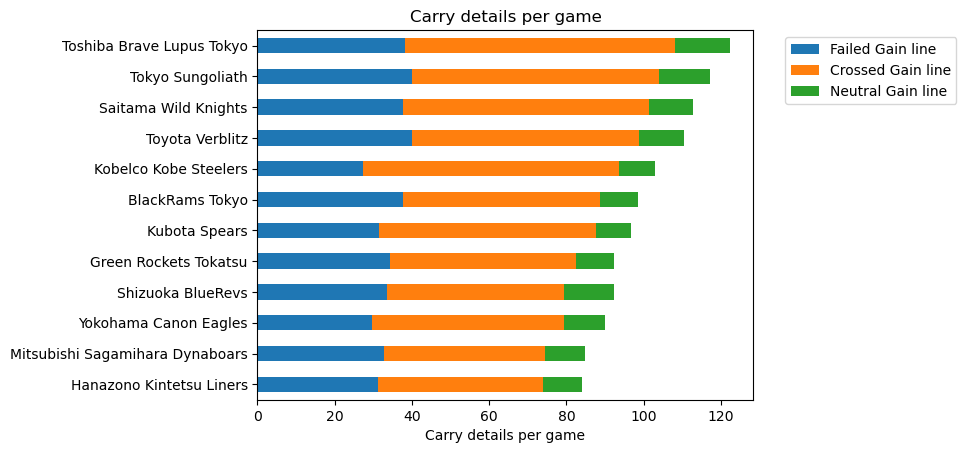

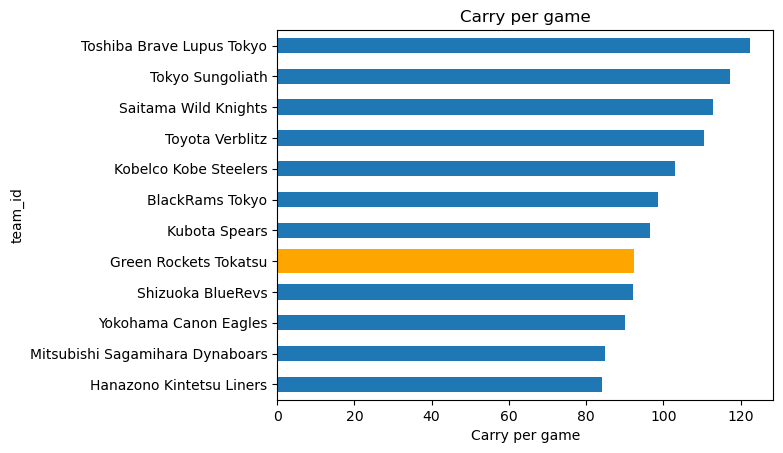

Pass of Mitsubishi Sagamihara Dynaboars


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 10           3
            Own Player            0           4
Complete    None                906         298
Error       None                  3           1
Forward     None                  0           3
Incomplete  None                 39          38
Intercepted None                  3           0
Off Target  None                  2           0
Offload     Own Player           11          40
            To Ground             2          11
Try         None                  8          10
            Own Player            1           4

Pass of Tokyo Sungoliath


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 31           4
            Own Player            5           9
            To Ground             1           0
Complete    None               1316         353
Error       None                  3           0
Forward     None                  3           5
Incomplete  None                 43          37
Intercepted None                  3           3
Off Target  None                  0           1
Offload     Own Player           21          86
            To Ground             7          20
Try         None                 25           9
            Own Player            2           3

Pass of Kubota Spears


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 22          15
            Own Player            1           6
Complete    None                979         363
Error       None                  0           3
Forward     None                  2           1
Incomplete  None                 47          47
Intercepted None                  4           1
Off Target  None                  1           1
Offload     Own Player            8          75
            To Ground             6          22
Try         None                 21           9
            Own Player            0           3

Pass of Shizuoka BlueRevs


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 19           8
            Own Player            3           3
Complete    None                940         320
Error       None                  0           1
Incomplete  None                 43          29
Intercepted None                  1           0
Offload     Own Player            7          38
            To Ground             3          20
Try         None                 12           6
            Own Player            0           1

Pass of Green Rockets Tokatsu


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 15           5
            Own Player            4           3
Complete    None               1046         305
Error       None                  6           2
Forward     None                  1           0
Incomplete  None                 47          35
Intercepted None                  1           2
Off Target  None                  4           0
Offload     Own Player           16          74
            To Ground            12          33
Try         None                 12           1
            Own Player            2           2

Pass of BlackRams Tokyo


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 17          13
            Own Player            8           6
Complete    None               1025         376
Error       None                  2           1
Forward     None                  0           1
Incomplete  None                 36          42
Intercepted None                  1           2
Off Target  None                  3           0
Offload     Own Player           17          39
            To Ground             9          19
Try         None                 14           8
            Own Player            1           3

Pass of Toyota Verblitz


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 17           7
            Own Player            3          10
Complete    None               1299         418
Error       None                  5           1
Forward     None                  1           1
Incomplete  None                 52          36
Intercepted None                  1           3
Offload     Own Player           19          78
            To Ground             8          33
Try         None                 13           9
            Own Player            2           0

Pass of Yokohama Canon Eagles


qualifier3                Long Pass  None  Short Pass
ActionType  Actionresult                             
Break       None                 14     1           6
            Own Player            0     0           7
            To Ground             1     0           0
Complete    None                822     0         335
Error       None                  4     0           2
Forward     None                  0     0           2
Incomplete  None                 36     0          40
Intercepted None                  2     0           0
Offload     Own Player           11     0          58
            To Ground             8     0          26
Try         None                 23     0          10
            Own Player            1     0           6

Pass of Kobelco Kobe Steelers


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 16          15
            Own Player            3          12
Complete    None               1158         367
Error       None                 10           4
Forward     None                  0          12
Incomplete  None                 38          58
Intercepted None                  2           1
Off Target  None                  3           1
Offload     Own Player           18          84
            To Ground            10          25
Try         None                 11          13
            Own Player            0           4
            To Ground             0           1

Pass of Toshiba Brave Lupus Tokyo


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 16           9
            Own Player            7          14
Complete    None               1268         373
Error       None                  6           0
Forward     None                  2           5
Incomplete  None                 45          52
Intercepted None                  2           1
Off Target  None                  1           1
Offload     Own Player           20         134
            To Ground             6          41
Try         None                 18          12
            Own Player            2           1

Pass of Saitama Wild Knights


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 35          14
            Own Player            2           4
Complete    None               1405         419
Error       None                  4           3
Forward     None                  0           2
Incomplete  None                 41          56
Intercepted None                  2           1
Off Target  None                  1           0
Offload     Own Player           12          75
            To Ground             6          29
Try         None                 15          18
            Own Player            2           6

Pass of Hanazono Kintetsu Liners


qualifier3                Long Pass  Short Pass
ActionType  Actionresult                       
Break       None                 25           9
            Own Player            1           0
Complete    None               1166         307
Error       None                  4           4
Forward     None                  1           1
Incomplete  None                 47          43
Intercepted None                  3           1
Off Target  None                  1           0
Offload     Own Player           13          44
            To Ground             7          19
Try         None                 11           4
            Own Player            0           5

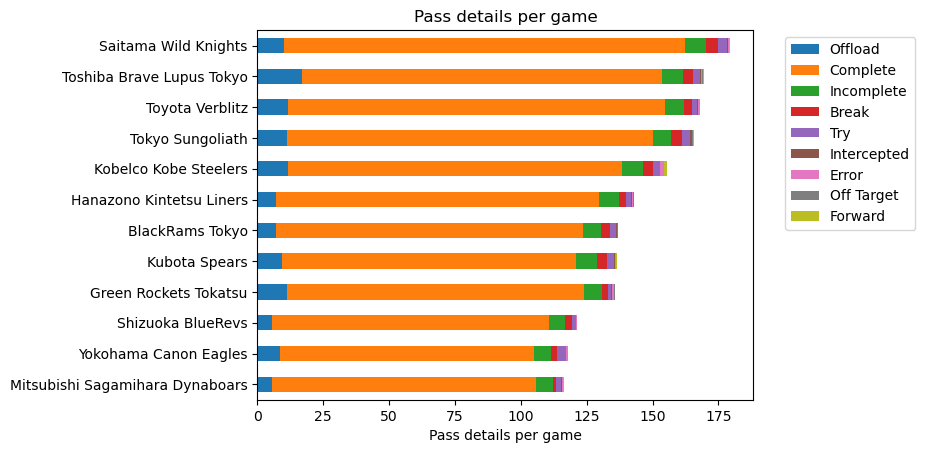

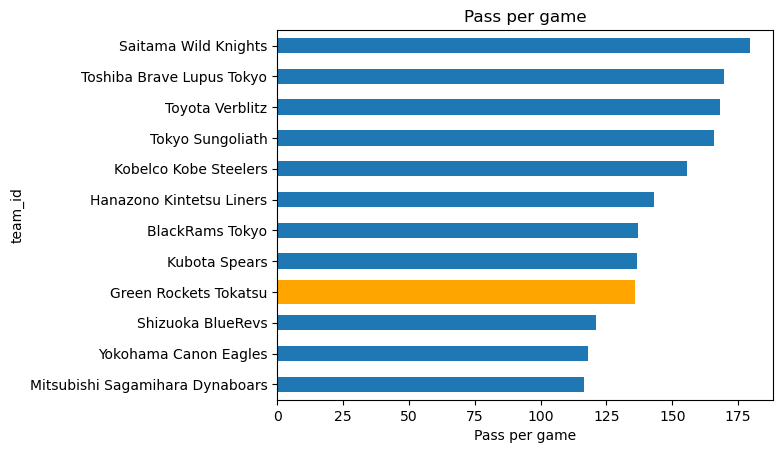

Goal Kick of Mitsubishi Sagamihara Dynaboars


qualifier3                 Dropped Short  Hit Left Post  Hit Right Post  \
ActionType   Actionresult                                                 
Conversion   Goal Kicked               0              0               0   
             Goal Missed               1              1               1   
Penalty Goal Goal Kicked               0              0               0   
             Goal Missed               0              0               0   

qualifier3                 Missed Left  Missed Right  None  
ActionType   Actionresult                                   
Conversion   Goal Kicked             0             0    29  
             Goal Missed             1             3     0  
Penalty Goal Goal Kicked             0             0    19  
             Goal Missed             2             2     0

Goal Kick of Tokyo Sungoliath


qualifier3                 Dropped Short  Hit Left Post  Hit Right Post  \
ActionType   Actionresult                                                 
Conversion   Goal Kicked               0              0               0   
             Goal Missed               1              4               2   
Penalty Goal Goal Kicked               0              0               0   
             Goal Missed               1              0               1   

qualifier3                 Missed Left  Missed Right  None  
ActionType   Actionresult                                   
Conversion   Goal Kicked             0             0    38  
             Goal Missed             5             8     0  
Penalty Goal Goal Kicked             0             0    19  
             Goal Missed             1             0     0

Goal Kick of Kubota Spears


qualifier3                 Dropped Short  Hit Left Post  Hit Right Post  \
ActionType   Actionresult                                                 
Conversion   Goal Kicked               0              0               0   
             Goal Missed               1              1               1   
Penalty Goal Goal Kicked               0              0               0   
             Goal Missed               0              0               0   

qualifier3                 Missed Left  Missed Right  None  
ActionType   Actionresult                                   
Conversion   Goal Kicked             0             0    44  
             Goal Missed             8             3     0  
Penalty Goal Goal Kicked             0             0    25  
             Goal Missed             0             2     0

Goal Kick of Shizuoka BlueRevs


qualifier3                 Dropped Short  Hit Right Post  Missed Left  \
ActionType   Actionresult                                               
Conversion   Goal Kicked               0               0            0   
             Goal Missed               5               1            3   
Penalty Goal Goal Kicked               0               0            0   
             Goal Missed               2               1            0   

qualifier3                 Missed Right  None  
ActionType   Actionresult                      
Conversion   Goal Kicked              0    24  
             Goal Missed              3     0  
Penalty Goal Goal Kicked              0    13  
             Goal Missed              3     0

Goal Kick of Green Rockets Tokatsu


qualifier3                 Dropped Short  Hit Left Post  Hit Right Post  \
ActionType   Actionresult                                                 
Conversion   Goal Kicked               0              0               0   
             Goal Missed               1              0               1   
Drop Goal    Goal Kicked               0              0               0   
             Goal Missed               1              0               0   
Penalty Goal Goal Kicked               0              0               0   
             Goal Missed               1              1               0   

qualifier3                 Missed Left  Missed Right  None  
ActionType   Actionresult                                   
Conversion   Goal Kicked             0             0    16  
             Goal Missed             2             5     0  
Drop Goal    Goal Kicked             0             0     1  
             Goal Missed             0             0     0  
Penalty Goal Goal Kicked             0             0     1  
             Goal Missed             0             2     0

Goal Kick of BlackRams Tokyo


qualifier3                 Dropped Short  Hit Left Post  Missed Left  \
ActionType   Actionresult                                              
Conversion   Goal Kicked               0              0            0   
             Goal Missed               2              1            3   
Drop Goal    Goal Missed               0              0            0   
Penalty Goal Goal Kicked               0              0            0   
             Goal Missed               0              0            4   

qualifier3                 Missed Right  None  
ActionType   Actionresult                      
Conversion   Goal Kicked              0    30  
             Goal Missed              7     0  
Drop Goal    Goal Missed              1     0  
Penalty Goal Goal Kicked              0    15  
             Goal Missed              1     0

Goal Kick of Toyota Verblitz


qualifier3                 Dropped Short  Hit Left Post  Missed Left  \
ActionType   Actionresult                                              
Conversion   Goal Kicked               0              0            0   
             Goal Missed               0              2           12   
Drop Goal    Goal Missed               0              0            1   
Penalty Goal Goal Kicked               0              0            0   
             Goal Missed               2              0            2   

qualifier3                 Missed Right  None  
ActionType   Actionresult                      
Conversion   Goal Kicked              0    25  
             Goal Missed              4     0  
Drop Goal    Goal Missed              0     0  
Penalty Goal Goal Kicked              0    20  
             Goal Missed              3     0

Goal Kick of Yokohama Canon Eagles


qualifier3                 Dropped Short  Hit Left Post  Missed Left  \
ActionType   Actionresult                                              
Conversion   Goal Kicked               0              0            0   
             Goal Missed               2              1            8   
Drop Goal    Goal Missed               0              0            1   
Penalty Goal Goal Kicked               0              0            0   
             Goal Missed               0              0            1   

qualifier3                 Missed Right  None  
ActionType   Actionresult                      
Conversion   Goal Kicked              0    42  
             Goal Missed              6     0  
Drop Goal    Goal Missed              0     0  
Penalty Goal Goal Kicked              0    13  
             Goal Missed              1     0

Goal Kick of Kobelco Kobe Steelers


qualifier3                 Hit Left Post  Missed Left  Missed Right  None
ActionType   Actionresult                                                
Conversion   Goal Kicked               0            0             0    41
             Goal Missed               2            4             6     0
Penalty Goal Goal Kicked               0            0             0    11
             Goal Missed               1            1             1     0

Goal Kick of Toshiba Brave Lupus Tokyo


qualifier3                 Dropped Short  Hit Left Post  Hit Right Post  \
ActionType   Actionresult                                                 
Conversion   Goal Kicked               0              0               0   
             Goal Missed               1              1               1   
Penalty Goal Goal Kicked               0              0               0   
             Goal Missed               1              0               0   

qualifier3                 Missed Left  Missed Right  None  
ActionType   Actionresult                                   
Conversion   Goal Kicked             0             0    43  
             Goal Missed             8             3     0  
Penalty Goal Goal Kicked             0             0    19  
             Goal Missed             0             1     0

Goal Kick of Saitama Wild Knights


qualifier3                 Dropped Short  Hit Left Post  Hit Right Post  \
ActionType   Actionresult                                                 
Conversion   Goal Kicked               0              0               0   
             Goal Missed               0              1               0   
Drop Goal    Goal Kicked               0              0               0   
Penalty Goal Goal Kicked               0              0               0   
             Goal Missed               1              1               2   

qualifier3                 Missed Left  Missed Right  None  
ActionType   Actionresult                                   
Conversion   Goal Kicked             0             0    50  
             Goal Missed             4             2     0  
Drop Goal    Goal Kicked             0             0     2  
Penalty Goal Goal Kicked             0             0    15  
             Goal Missed             0             1     0

Goal Kick of Hanazono Kintetsu Liners


qualifier3                 Dropped Short  Hit Left Post  Missed Left  \
ActionType   Actionresult                                              
Conversion   Goal Kicked               0              0            0   
             Goal Missed               2              1            1   
Penalty Goal Goal Kicked               0              0            0   
             Goal Missed               0              0            1   

qualifier3                 Missed Right  None  
ActionType   Actionresult                      
Conversion   Goal Kicked              0    22  
             Goal Missed              2     0  
Penalty Goal Goal Kicked              0     8  
             Goal Missed              0     0

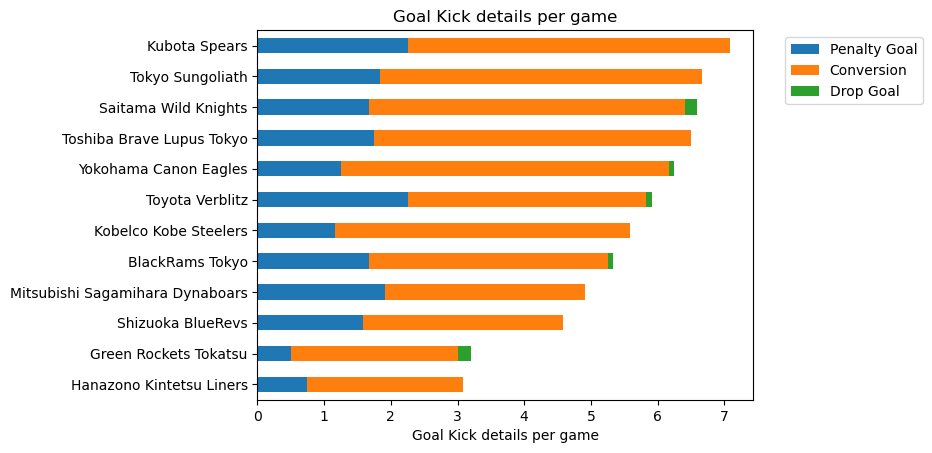

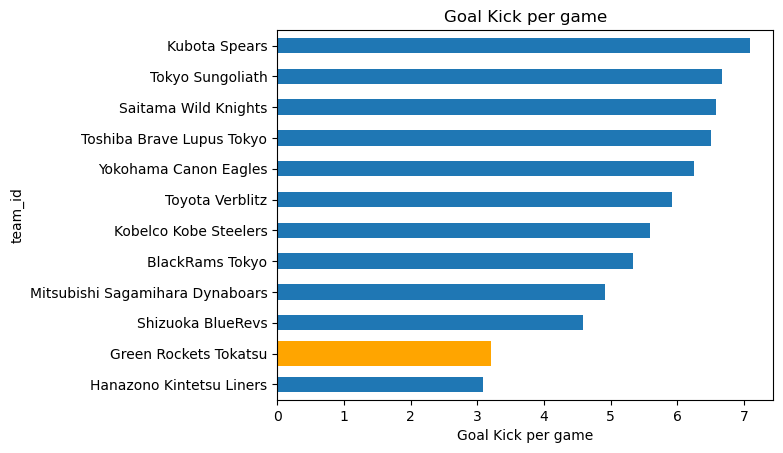

Referee Review of Mitsubishi Sagamihara Dynaboars


qualifier3               None
ActionType Actionresult      
Advantage  None            54

Referee Review of Tokyo Sungoliath


qualifier3               None
ActionType Actionresult      
Advantage  None            65

Referee Review of Kubota Spears


qualifier3               None
ActionType Actionresult      
Advantage  None            41

Referee Review of Shizuoka BlueRevs


qualifier3               None
ActionType Actionresult      
Advantage  None            65

Referee Review of Green Rockets Tokatsu


qualifier3               None
ActionType Actionresult      
Advantage  None            67

Referee Review of BlackRams Tokyo


qualifier3               None
ActionType Actionresult      
Advantage  None            40

Referee Review of Toyota Verblitz


qualifier3               None
ActionType Actionresult      
Advantage  None            49

Referee Review of Yokohama Canon Eagles


qualifier3               None
ActionType Actionresult      
Advantage  None            64

Referee Review of Kobelco Kobe Steelers


qualifier3               None
ActionType Actionresult      
Advantage  None            39

Referee Review of Toshiba Brave Lupus Tokyo


qualifier3               None
ActionType Actionresult      
Advantage  None            69

Referee Review of Saitama Wild Knights


qualifier3               None
ActionType Actionresult      
Advantage  None            53

Referee Review of Hanazono Kintetsu Liners


qualifier3               None
ActionType Actionresult      
Advantage  None            32

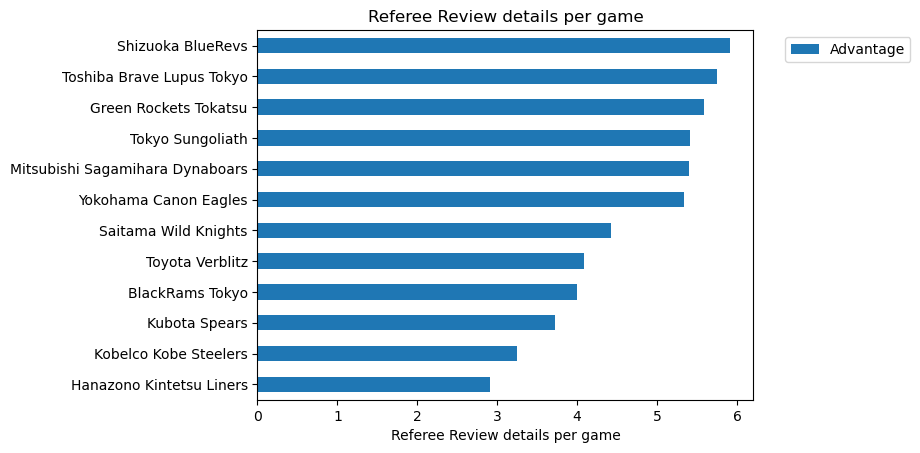

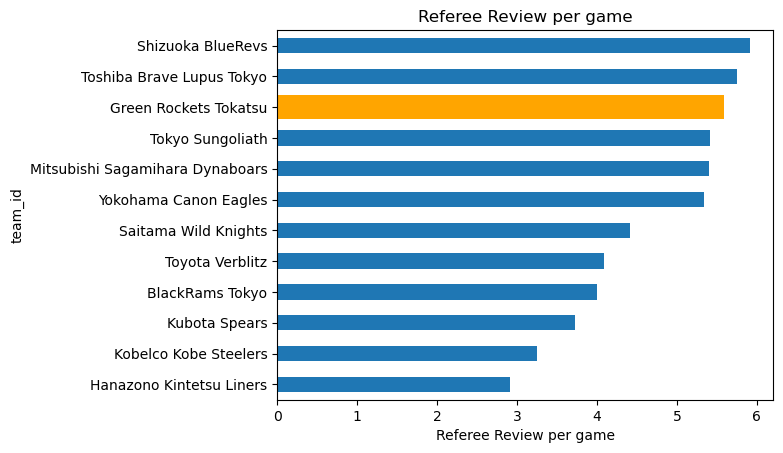

Turnovers of Mitsubishi Sagamihara Dynaboars


qualifier3                             None
ActionType            Actionresult         
Bad Offload           Error on Attack     3
Bad Pass              Error on Attack     7
Carried Over          Error on Attack     2
Carried in Touch      Error on Attack     8
Dropped Ball Unforced Error on Attack    33
Failure to Find Touch Error on Attack     5
Forward Pass          Error on Attack     5
Kick Error            Error on Attack    12
Lost Ball Forced      Error on Attack    25
Lost in Ruck or Maul  Error on Attack    21
Other Error           Error on Attack     3

Turnovers of Tokyo Sungoliath


qualifier3                             None
ActionType            Actionresult         
Bad Offload           Error on Attack     2
Bad Pass              Error on Attack     9
Carried Over          Error on Attack     2
Carried in Touch      Error on Attack     7
Dropped Ball Unforced Error on Attack    39
Failure to Find Touch Error on Attack    10
Forward Pass          Error on Attack    10
Kick Error            Error on Attack     6
                      None                2
Lost Ball Forced      Error on Attack    23
Lost in Ruck or Maul  Error on Attack    19
Other Error           Error on Attack     2

Turnovers of Kubota Spears


qualifier3                             None
ActionType            Actionresult         
Bad Offload           Error on Attack     3
Bad Pass              Error on Attack     8
Carried Over          Error on Attack     4
Carried in Touch      Error on Attack     9
Dropped Ball Unforced Error on Attack    46
                      None                2
Failure to Find Touch Error on Attack     2
Forward Pass          Error on Attack     3
Kick Error            Error on Attack    16
Lost Ball Forced      Error on Attack    26
Lost in Ruck or Maul  Error on Attack    14
Other Error           Error on Attack     1

Turnovers of Shizuoka BlueRevs


qualifier3                             None
ActionType            Actionresult         
Accidental Offside    Error on Attack     2
Bad Offload           Error on Attack     4
Bad Pass              Error on Attack     2
Carried Over          Error on Attack     2
Carried in Touch      Error on Attack     9
Dropped Ball Unforced Error on Attack    35
                      None                1
Failure to Find Touch Error on Attack     8
Kick Error            Error on Attack     9
Lost Ball Forced      Error on Attack    18
Lost in Ruck or Maul  Error on Attack     8
Other Error           Error on Attack     1

Turnovers of Green Rockets Tokatsu


qualifier3                             None
ActionType            Actionresult         
5 Second Rule         Error on Attack     1
Accidental Offside    Error on Attack     1
Bad Offload           Error on Attack    11
Bad Pass              Error on Attack    11
Carried Over          Error on Attack     1
Carried in Touch      Error on Attack    11
Dropped Ball Unforced Error on Attack    46
                      None                1
Failure to Find Touch Error on Attack     8
Forward Pass          Error on Attack     2
Kick Error            Error on Attack    12
                      None                5
Lost Ball Forced      Error on Attack     9
Lost in Ruck or Maul  Error on Attack    27
Other Error           Error on Attack     1

Turnovers of BlackRams Tokyo


qualifier3                             None
ActionType            Actionresult         
Bad Offload           Error on Attack     9
Bad Pass              Error on Attack     6
Carried Over          Error on Attack     2
Carried in Touch      Error on Attack    13
Dropped Ball Unforced Error on Attack    36
                      None                1
Failure to Find Touch Error on Attack     5
Forward Pass          Error on Attack     2
Kick Error            Error on Attack     9
                      None                2
Lost Ball Forced      Error on Attack    18
Lost in Ruck or Maul  Error on Attack    24

Turnovers of Toyota Verblitz


qualifier3                             None
ActionType            Actionresult         
Accidental Offside    Error on Attack     2
Bad Offload           Error on Attack     4
Bad Pass              Error on Attack    10
Carried Over          Error on Attack     1
Carried in Touch      Error on Attack    17
Dropped Ball Unforced Error on Attack    42
Failure to Find Touch Error on Attack     5
Forward Pass          Error on Attack     4
Kick Error            Error on Attack    13
                      None                1
Lost Ball Forced      Error on Attack    25
Lost in Ruck or Maul  Error on Attack    32

Turnovers of Yokohama Canon Eagles


qualifier3                             None
ActionType            Actionresult         
Bad Offload           Error on Attack     7
Bad Pass              Error on Attack     8
Carried Over          Error on Attack     1
Carried in Touch      Error on Attack    19
Dropped Ball Unforced Error on Attack    35
Failure to Find Touch Error on Attack     6
Forward Pass          Error on Attack     4
Kick Error            Error on Attack    11
                      None                1
Lost Ball Forced      Error on Attack    22
Lost in Ruck or Maul  Error on Attack    20

Turnovers of Kobelco Kobe Steelers


qualifier3                             None
ActionType            Actionresult         
Bad Offload           Error on Attack     8
Bad Pass              Error on Attack    17
Carried in Touch      Error on Attack    11
Dropped Ball Unforced Error on Attack    43
Failure to Find Touch Error on Attack     2
Forward Pass          Error on Attack    15
Kick Error            Error on Attack     4
                      None                6
Lost Ball Forced      Error on Attack    29
Lost in Ruck or Maul  Error on Attack    22
Other Error           Error on Attack     3

Turnovers of Toshiba Brave Lupus Tokyo


qualifier3                             None
ActionType            Actionresult         
5 Second Rule         Error on Attack     1
Accidental Offside    Error on Attack     5
Bad Offload           Error on Attack    11
Bad Pass              Error on Attack     9
Carried Over          Error on Attack     1
Carried in Touch      Error on Attack    13
Dropped Ball Unforced Error on Attack    50
Failure to Find Touch Error on Attack     6
Forward Pass          Error on Attack     9
Kick Error            Error on Attack    11
Lost Ball Forced      Error on Attack    17
Lost in Ruck or Maul  Error on Attack    20

Turnovers of Saitama Wild Knights


qualifier3                             None
ActionType            Actionresult         
5 Second Rule         Error on Attack     1
Accidental Offside    Error on Attack     2
Bad Offload           Error on Attack     5
Bad Pass              Error on Attack    10
Carried in Touch      Error on Attack    10
Dropped Ball Unforced Error on Attack    53
Failure to Find Touch Error on Attack     3
Forward Pass          Error on Attack     3
Kick Error            Error on Attack     7
Lost Ball Forced      Error on Attack    26
Lost in Ruck or Maul  Error on Attack    22
Other Error           Error on Attack     2

Turnovers of Hanazono Kintetsu Liners


qualifier3                             None
ActionType            Actionresult         
Bad Offload           Error on Attack    11
Bad Pass              Error on Attack    12
Carried in Touch      Error on Attack     9
Dropped Ball Unforced Error on Attack    38
Failure to Find Touch Error on Attack     5
Forward Pass          Error on Attack     4
Kick Error            Error on Attack     6
                      None                3
Lost Ball Forced      Error on Attack    19
Lost in Ruck or Maul  Error on Attack    24
Other Error           Error on Attack     2

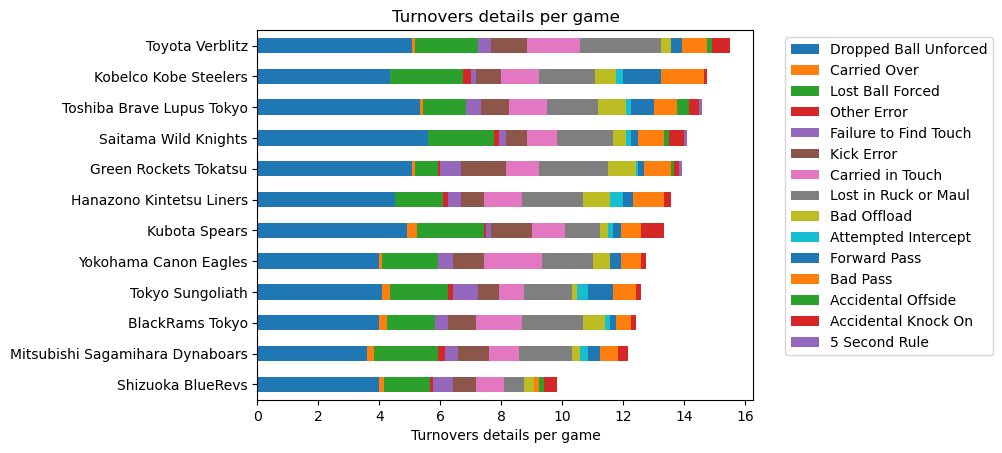

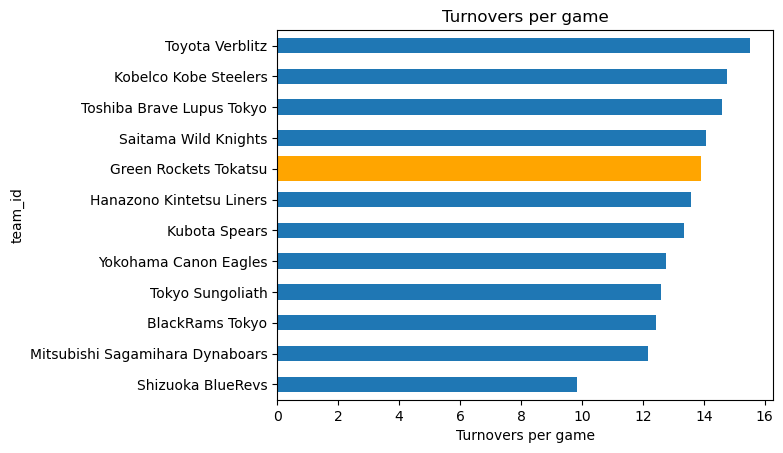

Defensive Scrum of Mitsubishi Sagamihara Dynaboars


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      80
                Won Penalty       16
No 8 Pick Up    Won Outright      32
None            Lost Free Kick    16
                Lost Pen Con      40
                Reset            114
                Won Free Kick     49
                Won Penalty       65
Scrum Half Kick Won Outright       8
Scrum Half Pass Won Outright     305
Scrum Half Run  Won Outright      24

Defensive Scrum of Tokyo Sungoliath


qualifier3                       None
ActionType      Actionresult         
No 8 Pass       Won Outright       48
No 8 Pick Up    Won Outright       80
                Won Penalty         8
                Won Penalty Try     8
None            Lost Free Kick     16
                Lost Pen Con      112
                Reset              64
                Won Free Kick      32
                Won Outright        8
                Won Penalty        48
Scrum Half Kick Won Outright        8
Scrum Half Pass Won Outright      238
Scrum Half Run  Won Outright       16
                Won Penalty         8

Defensive Scrum of Kubota Spears


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      16
No 8 Pick Up    Won Outright      32
None            Lost Free Kick    40
                Lost Outright     24
                Lost Pen Con      72
                Reset            168
                Won Free Kick     48
                Won Penalty       72
Scrum Half Kick Won Outright       8
Scrum Half Pass Won Outright     399
                Won Penalty       24
Scrum Half Run  Won Outright      24

Defensive Scrum of Shizuoka BlueRevs


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      16
                Won Penalty        8
No 8 Pick Up    Won Outright      96
                Won Penalty        8
None            Lost Free Kick     8
                Lost Pen Con      64
                Reset             80
                Won Free Kick     24
                Won Outright       8
                Won Penalty      104
Scrum Half Pass Won Outright     192
                Won Penalty        8
Scrum Half Run  Won Outright      24

Defensive Scrum of Green Rockets Tokatsu


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      54
                Won Penalty       16
No 8 Pick Up    Won Outright      48
                Won Penalty        7
None            Lost Free Kick    24
                Lost Outright      8
                Lost Pen Con      56
                Reset            152
                Won Free Kick     47
                Won Penalty      150
Scrum Half Pass Won Outright     167
                Won Penalty       32
Scrum Half Run  Won Outright      24

Defensive Scrum of BlackRams Tokyo


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      22
No 8 Pick Up    Won Outright      39
None            Lost Free Kick    31
                Lost Pen Con      24
                Reset             76
                Won Free Kick     47
                Won Penalty      131
Scrum Half Pass Won Outright     196
                Won Penalty       23
Scrum Half Run  Won Outright      37

Defensive Scrum of Toyota Verblitz


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      69
No 8 Pick Up    Won Outright      86
                Won Penalty       23
None            Lost Free Kick    16
                Lost Pen Con      47
                Lost Reversed      8
                Reset            121
                Won Free Kick     30
                Won Penalty       39
Scrum Half Kick Won Outright       8
Scrum Half Pass Won Outright     408
                Won Penalty       16
Scrum Half Run  Won Outright       7

Defensive Scrum of Yokohama Canon Eagles


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      16
No 8 Pick Up    Won Outright      48
None            Lost Free Kick     8
                Lost Pen Con      64
                Reset            119
                Won Free Kick     40
                Won Penalty       88
Scrum Half Kick Won Outright       8
Scrum Half Pass Won Outright     295
                Won Penalty        8
Scrum Half Run  Won Outright       8

Defensive Scrum of Kobelco Kobe Steelers


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      39
No 8 Pick Up    Won Outright      38
None            Lost Free Kick    24
                Lost Outright      8
                Lost Pen Con      63
                Reset             60
                Won Free Kick     24
                Won Penalty      124
Scrum Half Kick Won Outright       8
Scrum Half Pass Won Outright     311
                Won Penalty       16
Scrum Half Run  Won Outright       7

Defensive Scrum of Toshiba Brave Lupus Tokyo


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      24
No 8 Pick Up    Won Outright      78
None            Lost Free Kick    31
                Lost Outright      8
                Lost Pen Con      40
                Lost Reversed      7
                Reset             78
                Won Free Kick     32
                Won Penalty       94
Scrum Half Kick Won Outright      24
Scrum Half Pass Won Outright     340
                Won Penalty       15
Scrum Half Run  Won Outright      23

Defensive Scrum of Saitama Wild Knights


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      40
No 8 Pick Up    Won Outright      72
None            Lost Free Kick    32
                Lost Pen Con      56
                Reset             64
                Won Free Kick     72
                Won Penalty       24
Scrum Half Kick Won Outright      24
Scrum Half Pass Won Outright     287
                Won Penalty        8
Scrum Half Run  Won Outright      48

Defensive Scrum of Hanazono Kintetsu Liners


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      30
                Won Penalty       16
No 8 Pick Up    Won Outright      67
None            Lost Free Kick    24
                Lost Outright     16
                Lost Pen Con       6
                Reset             45
                Won Free Kick     46
                Won Penalty       60
Scrum Half Pass Won Outright     235
                Won Penalty       16
Scrum Half Run  Won Outright      32

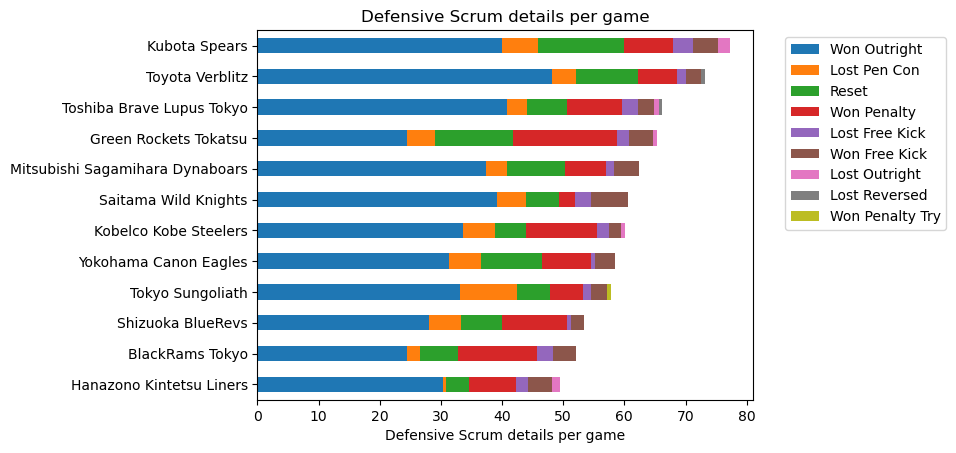

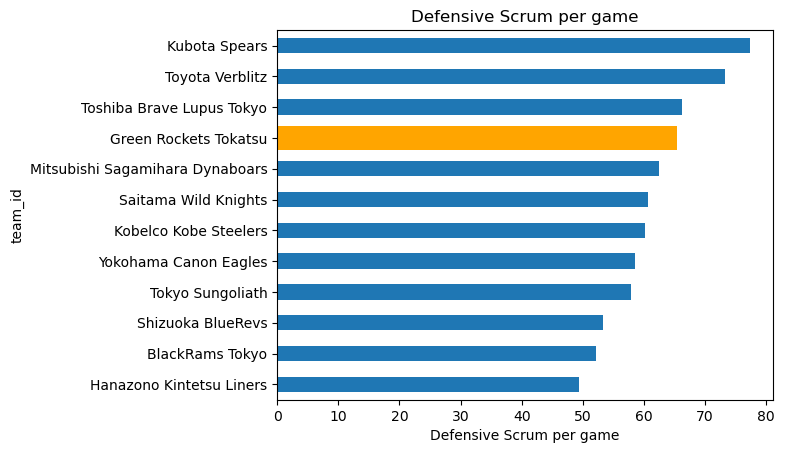

Offensive Scrum of Mitsubishi Sagamihara Dynaboars


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      56
No 8 Pick Up    Won Outright     104
None            Lost Free Kick    16
                Lost Pen Con      64
                Reset             65
                Won Free Kick     32
                Won Penalty       57
Scrum Half Kick Won Outright      16
Scrum Half Pass Won Outright     281
                Won Penalty       16
Scrum Half Run  Won Outright      16

Offensive Scrum of Tokyo Sungoliath


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright       8
No 8 Pick Up    Won Outright      24
None            Lost Free Kick    48
                Lost Pen Con      64
                Reset            152
                Won Free Kick     47
                Won Penalty      176
Scrum Half Kick Won Outright      16
Scrum Half Pass Won Outright     224

Offensive Scrum of Kubota Spears


qualifier3                      None
ActionType      Actionresult        
No 8 Pick Up    Won Outright      72
None            Lost Free Kick    40
                Lost Outright      8
                Lost Pen Con      32
                Reset             64
                Won Free Kick     32
                Won Penalty       72
Scrum Half Pass Won Outright     344
                Won Penalty       16
Scrum Half Run  Won Outright      32
                Won Penalty        8

Offensive Scrum of Shizuoka BlueRevs


qualifier3                       None
ActionType      Actionresult         
No 8 Pass       Won Outright       48
                Won Penalty        32
No 8 Pick Up    Won Outright       79
                Won Penalty         8
                Won Penalty Try     8
None            Lost Free Kick     40
                Lost Pen Con       55
                Reset              88
                Won Free Kick      40
                Won Penalty       120
Scrum Half Kick Won Outright        8
Scrum Half Pass Won Outright      240
                Won Penalty        24
Scrum Half Run  Won Outright       24

Offensive Scrum of Green Rockets Tokatsu


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      16
                Won Penalty        8
No 8 Pick Up    Won Outright      32
None            Lost Free Kick    39
                Lost Outright     24
                Lost Pen Con      56
                Lost Reversed      8
                Reset             88
                Won Free Kick     64
                Won Penalty      120
Scrum Half Pass Won Outright     304
                Won Penalty       16

Offensive Scrum of BlackRams Tokyo


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      53
No 8 Pick Up    Won Outright     178
                Won Penalty        7
None            Lost Free Kick     8
                Lost Pen Con      94
                Reset             87
                Won Free Kick     32
                Won Penalty       39
Scrum Half Pass Won Outright     124
                Won Penalty        8

Offensive Scrum of Toyota Verblitz


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      46
                Won Penalty        8
No 8 Pick Up    Won Outright      55
None            Lost Free Kick    15
                Lost Outright      8
                Lost Pen Con      23
                Reset             69
                Won Free Kick     32
                Won Outright       7
                Won Penalty       62
Scrum Half Pass Won Outright     272
Scrum Half Run  Won Outright       8

Offensive Scrum of Yokohama Canon Eagles


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      24
                Won Penalty        8
No 8 Pick Up    Won Outright      72
                Won Penalty       32
None            Lost Free Kick     8
                Lost Pen Con      24
                Reset            104
                Won Free Kick     72
                Won Penalty       96
Scrum Half Kick Won Outright      24
Scrum Half Pass Won Outright     280
                Won Penalty       16
Scrum Half Run  Won Outright      32

Offensive Scrum of Kobelco Kobe Steelers


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      16
No 8 Pick Up    Won Outright      71
None            Lost Free Kick    30
                Lost Outright     16
                Lost Pen Con      24
                Reset             78
                Won Free Kick     24
                Won Penalty       40
Scrum Half Pass Won Outright     289
                Won Penalty       23
Scrum Half Run  Won Outright       8

Offensive Scrum of Toshiba Brave Lupus Tokyo


qualifier3                     None
ActionType      Actionresult       
No 8 Pass       Won Outright     47
No 8 Pick Up    Won Outright     15
None            Lost Pen Con     63
                Reset           101
                Won Free Kick    39
                Won Penalty      78
Scrum Half Kick Won Outright     16
Scrum Half Pass Won Outright    349
                Won Penalty      32
Scrum Half Run  Won Outright     31

Offensive Scrum of Saitama Wild Knights


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      80
No 8 Pick Up    Won Outright       8
None            Lost Free Kick    16
                Lost Pen Con      48
                Lost Reversed      8
                Reset            144
                Won Free Kick     48
                Won Outright       8
                Won Penalty       87
Scrum Half Pass Won Outright     326
                Won Penalty       16
Scrum Half Run  Won Outright      48

Offensive Scrum of Hanazono Kintetsu Liners


qualifier3                      None
ActionType      Actionresult        
No 8 Pass       Won Outright      55
No 8 Pick Up    Won Outright       8
None            Lost Free Kick     7
                Lost Outright      8
                Lost Pen Con      87
                Reset            104
                Won Free Kick     29
                Won Penalty       56
Scrum Half Kick Won Outright      15
Scrum Half Pass Won Outright     335
Scrum Half Run  Won Outright      75

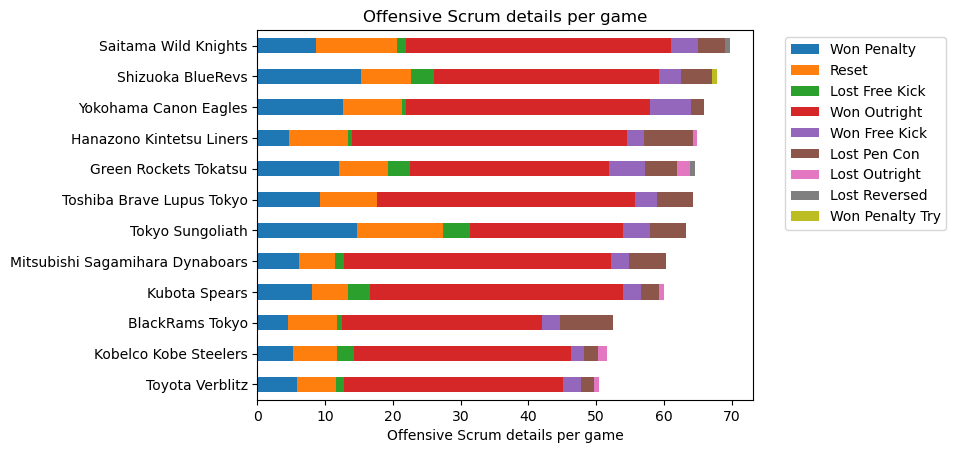

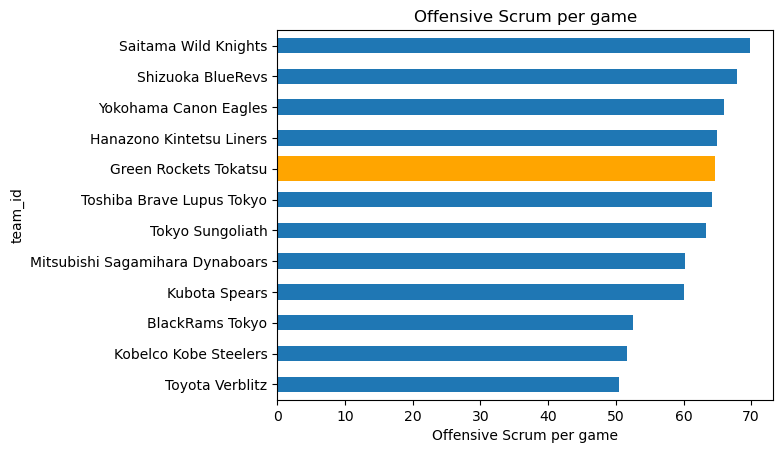

Lineout Catch of Mitsubishi Sagamihara Dynaboars


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal Front  Lost Clean                  0               0   
                     Lost Other                  0               0   
Lineout Steal Middle Lost Clean                  0               1   
                     Lost Other                  0               0   
Lineout Win 15m+     Won Clean                   0               0   
Lineout Win Back     Won Clean                  11               4   
                     Won Penalty                 0               1   
Lineout Win Front    Won Clean                  37              23   
                     Won Penalty                 2               1   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  17               4   
                     Won Penalty                 1               0   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               0   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal Front  Lost Clean                0            2  
                     Lost Other                1            0  
Lineout Steal Middle Lost Clean                0            6  
                     Lost Other                1            0  
Lineout Win 15m+     Won Clean                 5            0  
Lineout Win Back     Won Clean                 1            8  
                     Won Penalty               0            0  
Lineout Win Front    Won Clean                 1            9  
                     Won Penalty               0            0  
                     Won Tap                   1            2  
Lineout Win Middle   Won Clean                 1            5  
                     Won Penalty               0            0  
                     Won Tap                   0            6  
Lineout Win Quick    Won Clean                 1            0

Lineout Catch of Tokyo Sungoliath


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal Back   Lost Clean                  0               0   
                     Lost Other                  0               0   
Lineout Steal Front  Lost Clean                  0               0   
                     Lost Other                  0               1   
Lineout Steal Middle Lost Clean                  0               0   
                     Lost Other                  0               2   
Lineout Win 15m+     Won Clean                   1               1   
Lineout Win Back     Won Clean                   4               0   
                     Won Penalty                 1               0   
                     Won Tap                     1               0   
Lineout Win Front    Won Clean                  44               2   
                     Won Penalty                 2               0   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  35              13   
Lineout Win Quick    Won Clean                   0               3   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal Back   Lost Clean                1            0  
                     Lost Other                2            0  
Lineout Steal Front  Lost Clean                2            4  
                     Lost Other                0            0  
Lineout Steal Middle Lost Clean                4            5  
                     Lost Other                0            1  
Lineout Win 15m+     Won Clean                 2            1  
Lineout Win Back     Won Clean                 0            7  
                     Won Penalty               0            0  
                     Won Tap                   0            4  
Lineout Win Front    Won Clean                 5           24  
                     Won Penalty               0            1  
                     Won Tap                   0            1  
Lineout Win Middle   Won Clean                 0           13  
Lineout Win Quick    Won Clean                 6            0

Lineout Catch of Kubota Spears


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal Back   Lost Clean                  0               0   
Lineout Steal Front  Lost Clean                  1               0   
                     Lost Other                  0               0   
Lineout Steal Middle Lost Clean                  1               0   
                     Lost Other                  0               0   
Lineout Win 15m+     Won Clean                   1               5   
Lineout Win Back     Won Clean                   4               8   
                     Won Tap                     0               0   
Lineout Win Front    Won Clean                  10              11   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  20              13   
                     Won Penalty                 2               0   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               0   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal Back   Lost Clean                0            1  
Lineout Steal Front  Lost Clean                0            3  
                     Lost Other                1            0  
Lineout Steal Middle Lost Clean                0            2  
                     Lost Other                0            1  
Lineout Win 15m+     Won Clean                 4            0  
Lineout Win Back     Won Clean                 0            1  
                     Won Tap                   0            2  
Lineout Win Front    Won Clean                 1            9  
                     Won Tap                   0            2  
Lineout Win Middle   Won Clean                 2            6  
                     Won Penalty               0            0  
                     Won Tap                   0            3  
Lineout Win Quick    Won Clean                 1            0

Lineout Catch of Shizuoka BlueRevs


qualifier3                              Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                         
Lineout Steal Back   Lost Clean                       0               0   
Lineout Steal Front  Lost Clean                       2               0   
                     Lost Not Straight                0               0   
                     Lost Other                       0               0   
Lineout Steal Middle Lost Clean                       0               0   
Lineout Win Back     Won Clean                       12               0   
                     Won Penalty                      0               0   
                     Won Tap                          0               0   
Lineout Win Front    Won Clean                       22              14   
                     Won Penalty                      1               0   
                     Won Tap                          0               0   
Lineout Win Middle   Won Clean                       27              14   
                     Won Free Kick                    0               0   
                     Won Penalty                      3               0   
                     Won Tap                          0               0   

qualifier3                              Catch and Run  Off the Top  
ActionType           Actionresult                                   
Lineout Steal Back   Lost Clean                     2            0  
Lineout Steal Front  Lost Clean                     1            1  
                     Lost Not Straight              1            0  
                     Lost Other                     1            0  
Lineout Steal Middle Lost Clean                     0            2  
Lineout Win Back     Won Clean                      1            7  
                     Won Penalty                    0            1  
                     Won Tap                        0            3  
Lineout Win Front    Won Clean                      1           11  
                     Won Penalty                    0            0  
                     Won Tap                        0            2  
Lineout Win Middle   Won Clean                      1           12  
                     Won Free Kick                  0            1  
                     Won Penalty                    0            0  
                     Won Tap                        0            5

Lineout Catch of Green Rockets Tokatsu


qualifier3                          Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                     
Lineout Steal 15m+   Lost Clean                   0               0   
Lineout Steal Back   Lost Clean                   1               0   
Lineout Steal Front  Lost Clean                   0               0   
Lineout Steal Middle Lost Clean                   0               0   
Lineout Win 15m+     Won Clean                    1               1   
Lineout Win Back     Won Clean                    9               1   
                     Won Free Kick                1               0   
Lineout Win Front    Won Clean                   38              14   
                     Won Penalty                  1               1   
                     Won Tap                      0               0   
Lineout Win Middle   Won Clean                   31               5   
                     Won Free Kick                1               0   
                     Won Penalty                  3               0   
                     Won Tap                      0               0   
Lineout Win Quick    Won Clean                    0               0   

qualifier3                          Catch and Run  Off the Top  
ActionType           Actionresult                               
Lineout Steal 15m+   Lost Clean                 1            0  
Lineout Steal Back   Lost Clean                 0            2  
Lineout Steal Front  Lost Clean                 1            2  
Lineout Steal Middle Lost Clean                 2            3  
Lineout Win 15m+     Won Clean                  1            0  
Lineout Win Back     Won Clean                  0            6  
                     Won Free Kick              0            0  
Lineout Win Front    Won Clean                  3           25  
                     Won Penalty                1            1  
                     Won Tap                    1            3  
Lineout Win Middle   Won Clean                  1           11  
                     Won Free Kick              0            0  
                     Won Penalty                1            1  
                     Won Tap                    1            0  
Lineout Win Quick    Won Clean                  4            0

Lineout Catch of BlackRams Tokyo


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal Back   Lost Other                  0               0   
Lineout Steal Front  Lost Clean                  2               0   
                     Lost Other                  0               0   
Lineout Steal Middle Lost Clean                  1               0   
Lineout Win 15m+     Won Clean                   0               0   
Lineout Win Back     Won Clean                   2               2   
                     Won Penalty                 1               0   
                     Won Tap                     0               0   
Lineout Win Front    Won Clean                  33              21   
                     Won Penalty                 2               0   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  17               9   
                     Won Penalty                 1               0   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               0   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal Back   Lost Other                1            0  
Lineout Steal Front  Lost Clean                0            0  
                     Lost Other                1            0  
Lineout Steal Middle Lost Clean                2            6  
Lineout Win 15m+     Won Clean                 2            0  
Lineout Win Back     Won Clean                 1            1  
                     Won Penalty               0            0  
                     Won Tap                   0            2  
Lineout Win Front    Won Clean                 2           18  
                     Won Penalty               0            0  
                     Won Tap                   0            7  
Lineout Win Middle   Won Clean                 1            5  
                     Won Penalty               0            0  
                     Won Tap                   0            3  
Lineout Win Quick    Won Clean                 5            0

Lineout Catch of Toyota Verblitz


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal Back   Lost Clean                  0               0   
Lineout Steal Front  Lost Penalty                0               1   
Lineout Steal Middle Lost Clean                  0               0   
Lineout Win Back     Won Clean                   6               4   
                     Won Tap                     0               0   
Lineout Win Front    Won Clean                  21               9   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  21               5   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               1   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal Back   Lost Clean                1            3  
Lineout Steal Front  Lost Penalty              0            0  
Lineout Steal Middle Lost Clean                1            4  
Lineout Win Back     Won Clean                 0            6  
                     Won Tap                   1            0  
Lineout Win Front    Won Clean                 3           18  
                     Won Tap                   0            3  
Lineout Win Middle   Won Clean                 2           20  
                     Won Tap                   0            9  
Lineout Win Quick    Won Clean                 0            0

Lineout Catch of Yokohama Canon Eagles


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal 15m+   Lost Other                  0               0   
Lineout Steal Back   Lost Clean                  1               0   
Lineout Steal Front  Lost Clean                  0               0   
                     Lost Other                  0               0   
Lineout Steal Middle Lost Clean                  1               2   
                     Lost Other                  0               0   
Lineout Steal Quick  Lost Clean                  0               0   
Lineout Win 15m+     Won Clean                   0               1   
Lineout Win Back     Won Clean                   7               1   
Lineout Win Front    Lost Penalty                1               0   
                     Won Clean                  46              15   
                     Won Penalty                 4               0   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  20               6   
                     Won Penalty                 2               0   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               0   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal 15m+   Lost Other                1            0  
Lineout Steal Back   Lost Clean                0            0  
Lineout Steal Front  Lost Clean                0            1  
                     Lost Other                1            0  
Lineout Steal Middle Lost Clean                0            4  
                     Lost Other                1            0  
Lineout Steal Quick  Lost Clean                1            0  
Lineout Win 15m+     Won Clean                 0            0  
Lineout Win Back     Won Clean                 1            0  
Lineout Win Front    Lost Penalty              0            0  
                     Won Clean                 6           11  
                     Won Penalty               1            0  
                     Won Tap                   0            1  
Lineout Win Middle   Won Clean                 0           17  
                     Won Penalty               0            2  
                     Won Tap                   0            8  
Lineout Win Quick    Won Clean                 4            0

Lineout Catch of Kobelco Kobe Steelers


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal Back   Lost Clean                  0               1   
Lineout Steal Front  Lost Clean                  0               1   
Lineout Steal Middle Lost Clean                  1               0   
Lineout Win Back     Won Clean                   4               6   
                     Won Tap                     0               0   
Lineout Win Front    Won Clean                  26               9   
                     Won Penalty                 1               0   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  20              12   
                     Won Penalty                 1               0   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               3   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal Back   Lost Clean                1            2  
Lineout Steal Front  Lost Clean                0            3  
Lineout Steal Middle Lost Clean                2            4  
Lineout Win Back     Won Clean                 2            9  
                     Won Tap                   1            3  
Lineout Win Front    Won Clean                 1           12  
                     Won Penalty               0            1  
                     Won Tap                   0            3  
Lineout Win Middle   Won Clean                 1           19  
                     Won Penalty               0            0  
                     Won Tap                   0            9  
Lineout Win Quick    Won Clean                 3            0

Lineout Catch of Toshiba Brave Lupus Tokyo


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal Back   Lost Clean                  0               0   
                     Lost Other                  0               0   
Lineout Steal Front  Lost Clean                  0               0   
Lineout Steal Middle Lost Clean                  2               0   
                     Lost Other                  0               0   
Lineout Win 15m+     Won Clean                   0               2   
Lineout Win Back     Won Clean                  10               8   
                     Won Penalty                 0               0   
Lineout Win Front    Won Clean                  17              22   
                     Won Penalty                 0               0   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  26              14   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               1   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal Back   Lost Clean                3            1  
                     Lost Other                1            0  
Lineout Steal Front  Lost Clean                2            6  
Lineout Steal Middle Lost Clean                0            2  
                     Lost Other                1            0  
Lineout Win 15m+     Won Clean                 4            0  
Lineout Win Back     Won Clean                 0            5  
                     Won Penalty               0            1  
Lineout Win Front    Won Clean                 6           11  
                     Won Penalty               0            1  
                     Won Tap                   0            3  
Lineout Win Middle   Won Clean                 0           10  
                     Won Tap                   0            3  
Lineout Win Quick    Won Clean                 3            0

Lineout Catch of Saitama Wild Knights


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal 15m+   Lost Clean                  0               0   
Lineout Steal Back   Lost Clean                  0               0   
Lineout Steal Front  Lost Clean                  0               0   
Lineout Steal Middle Lost Clean                  0               0   
Lineout Win 15m+     Won Clean                   0               1   
Lineout Win Back     Won Clean                  10               6   
                     Won Tap                     0               0   
Lineout Win Front    Won Clean                  16              12   
                     Won Tap                     0               0   
Lineout Win Middle   Won Clean                  19               7   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               1   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal 15m+   Lost Clean                0            1  
Lineout Steal Back   Lost Clean                1            3  
Lineout Steal Front  Lost Clean                0            4  
Lineout Steal Middle Lost Clean                0            8  
Lineout Win 15m+     Won Clean                 3            0  
Lineout Win Back     Won Clean                 1            8  
                     Won Tap                   0            2  
Lineout Win Front    Won Clean                 3           26  
                     Won Tap                   0            1  
Lineout Win Middle   Won Clean                 4           20  
                     Won Tap                   0            5  
Lineout Win Quick    Won Clean                 2            0

Lineout Catch of Hanazono Kintetsu Liners


qualifier3                         Catch and Drive  Catch and Pass  \
ActionType           Actionresult                                    
Lineout Steal Middle Lost Clean                  0               0   
                     Lost Other                  0               0   
Lineout Win 15m+     Won Clean                   0               0   
Lineout Win Back     Won Clean                   1               2   
                     Won Tap                     0               0   
Lineout Win Front    Won Clean                   9              10   
                     Won Tap                     0               0   
Lineout Win Middle   Lost Clean                  0               0   
                     Lost Other                  0               0   
                     Won Clean                   3               7   
                     Won Penalty                 0               0   
                     Won Tap                     0               0   
Lineout Win Quick    Won Clean                   0               2   

qualifier3                         Catch and Run  Off the Top  
ActionType           Actionresult                              
Lineout Steal Middle Lost Clean                0            7  
                     Lost Other                1            0  
Lineout Win 15m+     Won Clean                 2            0  
Lineout Win Back     Won Clean                 2            2  
                     Won Tap                   0            3  
Lineout Win Front    Won Clean                 2           10  
                     Won Tap                   0            3  
Lineout Win Middle   Lost Clean                0            1  
                     Lost Other                1            0  
                     Won Clean                 0           20  
                     Won Penalty               0            1  
                     Won Tap                   0            4  
Lineout Win Quick    Won Clean                 6            0

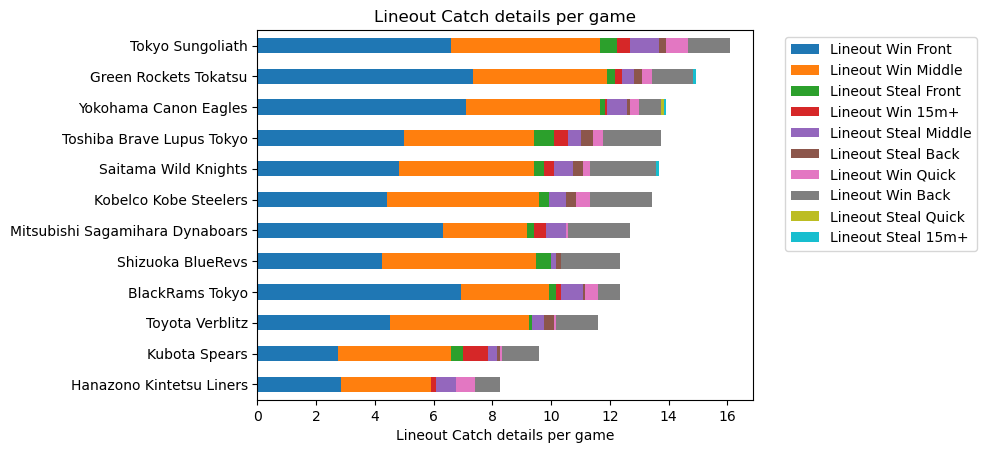

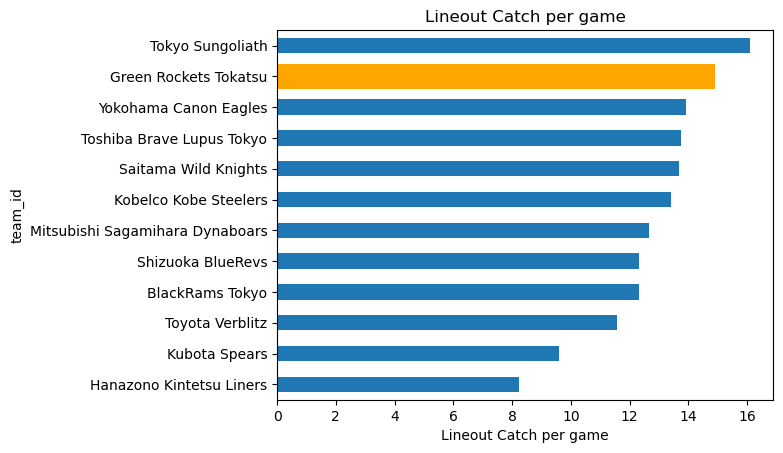

Attacking Quality of Mitsubishi Sagamihara Dynaboars


qualifier3                       None
ActionType      Actionresult         
Break Assist    None               32
Decoy           None                8
Defender Beaten None              186
Initial Break   Kick Line Break     5
                Line Break         39
Snake           None               67
Supported Break None               12
Try Assist      None               23

Attacking Quality of Tokyo Sungoliath


qualifier3                       None
ActionType      Actionresult         
Break Assist    None               68
Decoy           None               23
Defender Beaten None              389
Initial Break   Kick Line Break     7
                Line Break         73
Snake           None               89
Supported Break None               48
Try Assist      None               45

Attacking Quality of Kubota Spears


qualifier3                         None
ActionType      Actionresult           
Break Assist    None                 63
Decoy           None                 25
Defender Beaten None                324
Initial Break   Intercepted Break     3
                Kick Line Break       6
                Line Break           75
Snake           None                 95
Supported Break None                 46
Try Assist      None                 37

Attacking Quality of Shizuoka BlueRevs


qualifier3                       None
ActionType      Actionresult         
Break Assist    None               43
Decoy           None               23
Defender Beaten None              250
Initial Break   Kick Line Break     3
                Line Break         54
Snake           None               53
Supported Break None               17
Try Assist      None               20

Attacking Quality of Green Rockets Tokatsu


qualifier3                         None
ActionType      Actionresult           
Break Assist    None                 37
Decoy           None                 18
Defender Beaten None                300
Initial Break   Intercepted Break     1
                Kick Line Break       6
                Line Break           46
Snake           None                104
Supported Break None                 21
Try Assist      None                 18

Attacking Quality of BlackRams Tokyo


qualifier3                       None
ActionType      Actionresult         
Break Assist    None               61
Decoy           None               34
Defender Beaten None              299
Initial Break   Kick Line Break     5
                Line Break         70
Snake           None               79
Supported Break None               39
Try Assist      None               29

Attacking Quality of Toyota Verblitz


qualifier3                         None
ActionType      Actionresult           
Break Assist    None                 51
Decoy           None                 12
Defender Beaten None                356
Initial Break   Intercepted Break     2
                Kick Line Break       6
                Line Break           61
Snake           None                 98
Supported Break None                 49
Try Assist      None                 25

Attacking Quality of Yokohama Canon Eagles


qualifier3                       None
ActionType      Actionresult         
Break Assist    None               66
Decoy           None               20
Defender Beaten None              371
Initial Break   Kick Line Break    16
                Line Break         67
Snake           None               79
Supported Break None               34
Try Assist      None               43

Attacking Quality of Kobelco Kobe Steelers


qualifier3                         None
ActionType      Actionresult           
Break Assist    None                 61
Decoy           None                  7
Defender Beaten None                364
Initial Break   Intercepted Break     1
                Kick Line Break       8
                Line Break           67
Snake           None                 61
Supported Break None                 40
Try Assist      None                 32

Attacking Quality of Toshiba Brave Lupus Tokyo


qualifier3                         None
ActionType      Actionresult           
Break Assist    None                 66
Decoy           None                 16
Defender Beaten None                355
Initial Break   Intercepted Break     2
                Kick Line Break       4
                Line Break           78
Snake           None                110
Supported Break None                 30
Try Assist      None                 34

Attacking Quality of Saitama Wild Knights


qualifier3                         None
ActionType      Actionresult           
Break Assist    None                 88
Decoy           None                 32
Defender Beaten None                374
Initial Break   Intercepted Break     1
                Kick Line Break      14
                Line Break           85
Snake           None                110
Supported Break None                 36
Try Assist      None                 44

Attacking Quality of Hanazono Kintetsu Liners


qualifier3                         None
ActionType      Actionresult           
Break Assist    None                 51
Decoy           None                 20
Defender Beaten None                254
Initial Break   Intercepted Break     2
                Kick Line Break       8
                Line Break           49
Snake           None                 68
Supported Break None                 24
Try Assist      None                 23

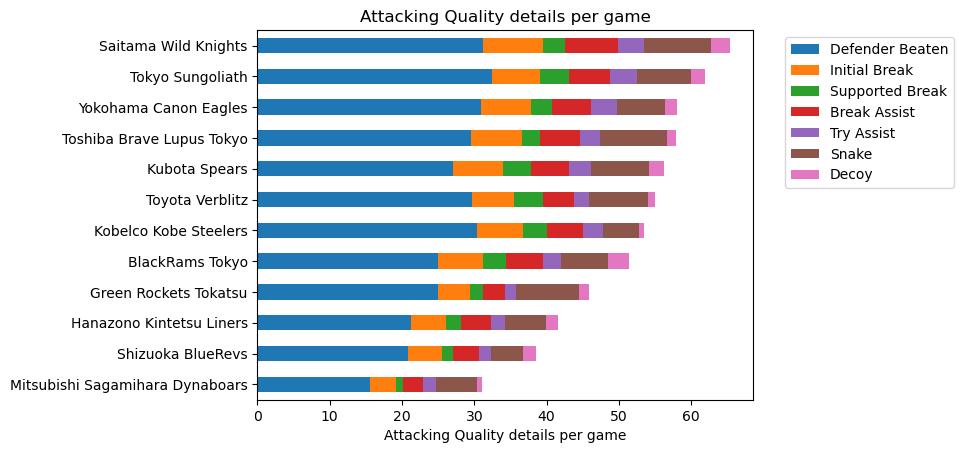

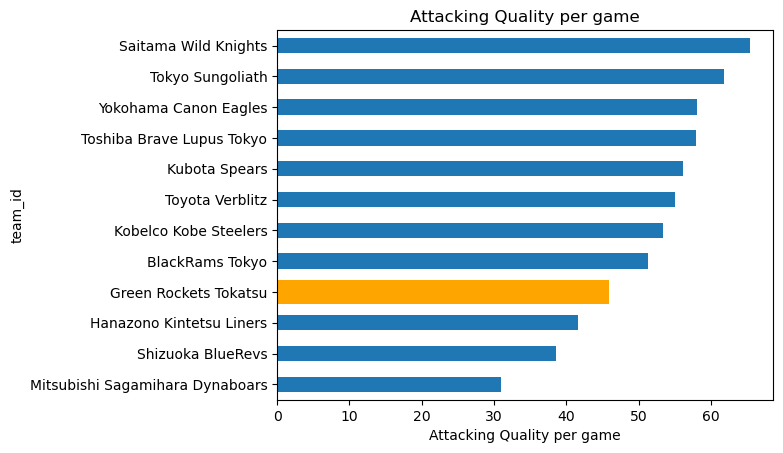

Penalty of Mitsubishi Sagamihara Dynaboars


qualifier3                                Defence  Offence
ActionType                  Actionresult                  
Collapsing Maul             No Action           3        0
Deliberate Knock On         No Action           2        0
                            Penalty Try         1        0
Dissent Advance             No Action           1        0
Foul Play - Dangerous Throw No Action           1        0
                            Yellow Card         1        0
Foul Play - High Tackle     No Action           7        0
                            Yellow Card         3        0
Foul Play - Mid Air Tackle  No Action           1        0
Foul Play - Other           No Action           0        2
Hands in Ruck               No Action           1        0
Lineout Offence             No Action           5        1
Maul Obstruction            No Action           0        1
Not Releasing               No Action           0       19
Not Rolling Away            No Action          19        0
Obstruction                 No Action           1        1
Off Feet at Ruck            No Action           8        8
                            Yellow Card         1        0
Offside                     No Action          15        1
Other Offence               No Action           0        1
Scrum Offence               No Action          11        9
Wrong Side at Maul          No Action           5        0
Wrong Side at Ruck          No Action           0        2

Penalty of Tokyo Sungoliath


qualifier3                               Defence  Offence
ActionType                 Actionresult                  
Charging into Ruck         Red Card            1        0
Collapsing Maul            No Action           3        0
Deliberate Knock On        No Action           1        0
Dissent Advance            No Action           1        0
Foul Play - High Tackle    No Action           5        0
                           Yellow Card         1        0
Foul Play - Late Tackle    No Action           1        0
Foul Play - Mid Air Tackle No Action           1        0
Hands in Ruck              No Action           1        1
Lineout Offence            No Action           4        0
Maul Obstruction           No Action           0        1
Not Releasing              No Action           0       24
Not Rolling Away           No Action          16        0
                           Yellow Card         1        0
Obstruction                No Action           3        6
Off Feet at Ruck           No Action          11        5
                           Yellow Card         1        0
Offside                    No Action          12        2
Offside at Kick            No Action           0        2
Other Offence              No Action           1        0
Scrum Offence              No Action          10       13
                           Penalty Try         1        0
Wrong Side at Maul         No Action           3        0
Wrong Side at Ruck         No Action           2        2

Penalty of Kubota Spears


qualifier3                                Defence  Offence
ActionType                  Actionresult                  
Collapsing Maul             No Action           3        0
                            Yellow Card         1        0
Deliberate Knock On         No Action           2        0
                            Yellow Card         1        0
Foul Play - Dangerous Throw No Action           1        0
Foul Play - High Tackle     No Action           5        0
Foul Play - Mid Air Tackle  No Action           1        0
                            Yellow Card         1        0
Foul Play - Other           No Action           0        1
Hands in Ruck               No Action           5        1
Lineout Offence             No Action           6        0
Maul Obstruction            No Action           0        1
Not Releasing               No Action           0       14
Not Rolling Away            No Action          14        0
Obstruction                 No Action           2        1
Off Feet at Ruck            No Action           8        3
Offside                     No Action          14        1
Offside at Kick             No Action           1        3
Other Offence               No Action           0        1
Scrum Offence               No Action          16        8
Wrong Side at Maul          No Action           3        0
Wrong Side at Ruck          No Action           3        4

Penalty of Shizuoka BlueRevs


qualifier3                                Defence  Offence
ActionType                  Actionresult                  
Collapsing Maul             No Action           7        0
Deliberate Knock On         No Action           2        0
                            Yellow Card         1        0
Dissent                     No Action           1        0
Foul Play - Dangerous Throw No Action           1        0
Foul Play - High Tackle     No Action           6        0
Foul Play - Late Tackle     No Action           1        0
Foul Play - Mid Air Tackle  No Action           1        0
Foul Play - Other           No Action           0        1
Hands in Ruck               No Action           2        2
                            Yellow Card         2        0
Lineout Offence             No Action           6        0
                            Yellow Card         1        0
Maul Obstruction            No Action           0        1
Not Releasing               No Action           0       25
Not Rolling Away            No Action          15        0
Obstruction                 No Action           2        4
Off Feet at Ruck            No Action           9        6
Offside                     No Action           9        1
Offside at Kick             No Action           0        6
Other Offence               No Action           0        1
Scrum Offence               No Action          18       10
Wrong Side at Ruck          No Action           5        3

Penalty of Green Rockets Tokatsu


qualifier3                                Defence  Offence
ActionType                  Actionresult                  
Collapsing Maul             No Action           6        0
                            Penalty Try         1        0
Deliberate Knock On         No Action           1        0
                            Yellow Card         1        0
Dissent Advance             No Action           1        0
Foul Play - Dangerous Throw No Action           1        0
Foul Play - High Tackle     No Action           6        0
                            Yellow Card         1        0
Foul Play - Mid Air Tackle  No Action           1        0
                            Yellow Card         1        0
Foul Play - Other           No Action           1        3
Hands in Ruck               No Action           0        3
Lineout Offence             No Action           5        0
Maul Obstruction            No Action           0        1
Not Releasing               No Action           0       26
Not Rolling Away            No Action          24        0
                            Yellow Card         1        0
Obstruction                 No Action           2        1
                            Red Card            1        0
Off Feet at Ruck            No Action           9        6
Offside                     No Action           6        0
                            Yellow Card         1        0
Offside at Kick             No Action           0        1
Other Offence               No Action           0        1
Scrum Offence               No Action          29       10
Wrong Side at Maul          No Action           2        0
Wrong Side at Ruck          No Action           1        0

Penalty of BlackRams Tokyo


qualifier3                                Defence  Offence
ActionType                  Actionresult                  
Collapsing Maul             No Action           2        0
Deliberate Knock On         No Action           1        0
Dissent Advance             No Action           1        0
Foul Play - Dangerous Throw No Action           0        1
Foul Play - High Tackle     No Action          11        0
                            Yellow Card         1        0
Foul Play - Other           No Action           0        1
Hands in Ruck               No Action           1        2
Lineout Offence             No Action           5        0
                            Yellow Card         1        0
Not Releasing               No Action           0       26
Not Rolling Away            No Action          24        0
Obstruction                 No Action           0        1
Off Feet at Ruck            No Action           9        3
Offside                     No Action          21        3
                            Yellow Card         1        0
Offside at Kick             No Action           0        2
Other Offence               No Action           0        1
Scrum Offence               No Action          19       11
Wrong Side at Maul          No Action          10        0
                            Penalty Try         1        0
Wrong Side at Ruck          No Action           4        4

Penalty of Toyota Verblitz


qualifier3                                Defence  Offence
ActionType                  Actionresult                  
Charging into Ruck          Red Card            1        0
Collapsing Maul             No Action           3        0
Deliberate Knock On         No Action           1        0
                            Yellow Card         1        0
Dissent Advance             No Action           0        1
Foul Play - Dangerous Throw No Action           2        0
Foul Play - High Tackle     No Action           3        0
                            Yellow Card         2        0
Foul Play - Mid Air Tackle  No Action           2        0
Foul Play - Other           No Action           0        1
Hands in Ruck               No Action           1        1
Lineout Offence             No Action           5        0
Not Releasing               No Action           0       22
Not Rolling Away            No Action          16        0
                            Yellow Card         3        0
Obstruction                 No Action           1        2
Off Feet at Ruck            No Action           6        2
Offside                     No Action          17        0
                            Yellow Card         1        0
Offside at Kick             No Action           1        0
Other Offence               No Action           1        1
Scrum Offence               No Action          12        4
Wrong Side at Maul          No Action           1        0
Wrong Side at Ruck          No Action           4        2

Penalty of Yokohama Canon Eagles


qualifier3                                Defence  Offence
ActionType                  Actionresult                  
Collapsing Maul             No Action           4        0
Deliberate Knock On         No Action           1        0
                            Yellow Card         1        0
Dissent                     No Action           0        1
Dissent Advance             No Action           1        0
                            Yellow Card         1        0
Foul Play - Dangerous Throw No Action           2        0
Foul Play - High Tackle     No Action           5        0
Foul Play - Late Tackle     No Action           1        0
Foul Play - Mid Air Tackle  Yellow Card         1        0
Hands in Ruck               No Action           2        1
Lineout Offence             No Action           4        3
Maul Obstruction            No Action           0        1
Not Releasing               No Action           0       20
Not Rolling Away            No Action          16        0
Obstruction                 No Action           0        3
Off Feet at Ruck            No Action          11        4
Offside                     No Action          20        1
Offside at Kick             No Action           0        1
Other Offence               No Action           1        1
Scrum Offence               No Action          15        3
Wrong Side at Maul          No Action           2        0
                            Yellow Card         1        0
Wrong Side at Ruck          No Action           1        5

Penalty of Kobelco Kobe Steelers


qualifier3                               Defence  Offence
ActionType                 Actionresult                  
Charging into Ruck         Red Card            0        1
Collapsing Maul            Penalty Try         1        0
Deliberate Knock On        No Action           1        0
                           Yellow Card         1        0
Dissent Advance            No Action           0        1
Foul Play - High Tackle    No Action           6        0
                           Yellow Card         1        0
Foul Play - Mid Air Tackle No Action           0        1
Foul Play - Other          No Action           1        1
Hands in Ruck              No Action           1        1
Lineout Offence            No Action           5        1
Maul Obstruction           No Action           0        1
Not Releasing              No Action           0       28
Not Rolling Away           No Action          21        0
Obstruction                No Action           2        3
Off Feet at Ruck           No Action           4        5
                           Yellow Card         2        0
Offside                    No Action          18        0
Offside at Kick            No Action           0        1
Scrum Offence              No Action          21        5
Wrong Side at Maul         No Action           1        0
                           Penalty Try         1        0
Wrong Side at Ruck         No Action           4        5
                           Yellow Card         1        0

Penalty of Toshiba Brave Lupus Tokyo


qualifier3                                Defence  Offence
ActionType                  Actionresult                  
Collapsing Maul             No Action           3        0
Deliberate Knock On         No Action           3        0
Dissent Advance             No Action           1        0
Foul Play - Dangerous Throw No Action           1        0
Foul Play - Fighting        Yellow Card         0        1
Foul Play - High Tackle     No Action           2        0
                            Red Card            1        0
                            Yellow Card         1        0
Foul Play - Other           No Action           0        1
Lineout Offence             No Action           6        0
Maul Obstruction            No Action           0        1
Not Releasing               No Action           0       21
Not Rolling Away            No Action          18        0
                            Yellow Card         1        0
Obstruction                 No Action           2        3
                            Yellow Card         1        0
Off Feet at Ruck            No Action          13        2
                            Yellow Card         1        0
Offside                     No Action          12        2
Offside at Kick             No Action           1        1
Other Offence               No Action           0        1
Scrum Offence               No Action          14        8
Wrong Side at Maul          No Action           4        0
                            Yellow Card         1        0
Wrong Side at Ruck          No Action           1        7

Penalty of Saitama Wild Knights


qualifier3                               Defence  Offence
ActionType                 Actionresult                  
Charging into Ruck         Red Card            0        1
Collapsing Maul            No Action           5        0
Deliberate Knock On        No Action           2        0
                           Yellow Card         1        0
Foul Play - High Tackle    No Action           8        0
Foul Play - Mid Air Tackle No Action           0        1
Foul Play - Other          No Action           0        1
Hands in Ruck              No Action           1        0
Lineout Offence            No Action           7        0
                           Yellow Card         1        0
Maul Obstruction           No Action           0        1
Not Releasing              No Action           0       31
Not Rolling Away           No Action          21        0
                           Yellow Card         1        0
Obstruction                No Action           2        0
                           Penalty Try         1        0
                           Yellow Card         1        0
Off Feet at Ruck           No Action           5        2
Offside                    No Action           8        3
Offside at Kick            No Action           1        3
Other Offence              No Action           0        1
Scrum Offence              No Action          10        6
Wrong Side at Maul         No Action           2        0
                           Yellow Card         1        0
Wrong Side at Ruck         No Action           3        2

Penalty of Hanazono Kintetsu Liners


qualifier3                               Defence  Offence
ActionType                 Actionresult                  
Collapsing Maul            No Action           6        0
Deliberate Knock On        No Action           2        0
                           Penalty Try         1        0
                           Yellow Card         1        0
Foul Play - Foot Contact   No Action           1        0
Foul Play - High Tackle    No Action           6        1
                           Yellow Card         1        0
Foul Play - Late Tackle    No Action           1        0
Foul Play - Mid Air Tackle No Action           2        0
Hands in Ruck              No Action           1        1
Lineout Offence            No Action           5        1
                           Yellow Card         1        0
Not Releasing              No Action           0       29
Not Rolling Away           No Action          22        0
Obstruction                No Action           0        1
Off Feet at Ruck           No Action           5        3
Offside                    No Action          14        0
Other Offence              No Action           0        1
Scrum Offence              No Action          18       13
Wrong Side at Maul         No Action           2        0
Wrong Side at Ruck         No Action           1        2

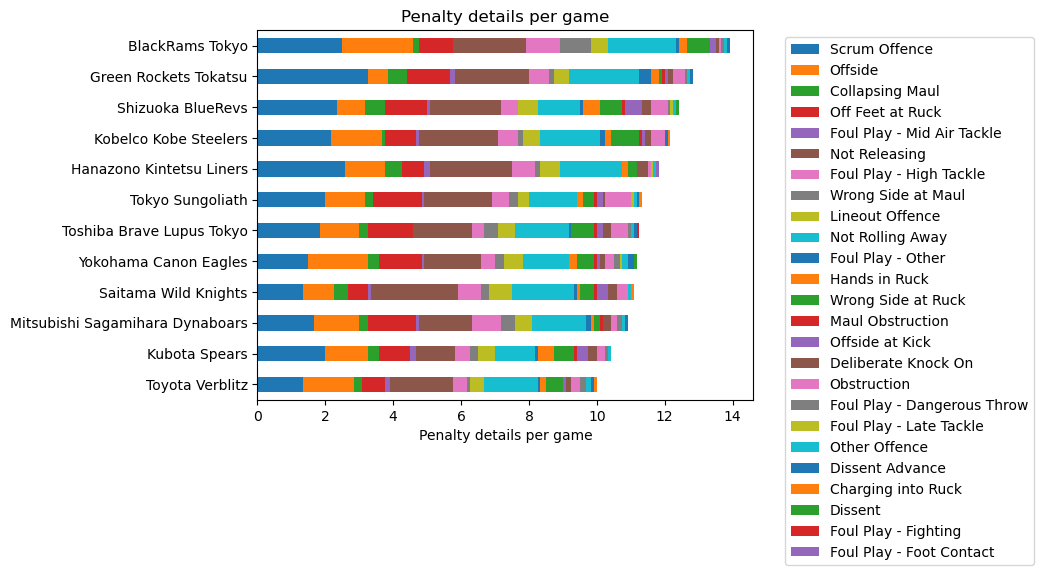

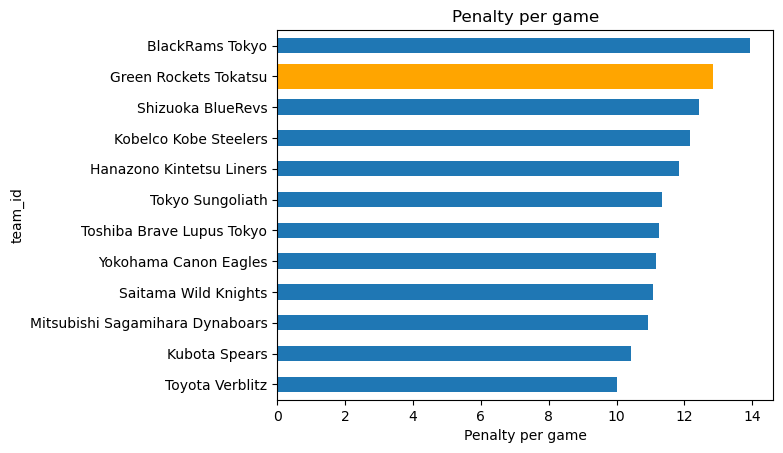

Player Leaves Field of Mitsubishi Sagamihara Dynaboars


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             5
Concussion Replacement          None             2
Injury                          None             9
Reversal Blood Replacement      None             5
Reversal Concussion Replacement None             1
Reversal Front Row Replacement  None             5
Tactical                        None            65
Yellow Card                     None             8

Player Leaves Field of Tokyo Sungoliath


qualifier3                                    None
ActionType                      Actionresult      
Concussion Replacement          None             4
Injury                          None             9
Red Card                        None             1
Reversal Concussion Replacement None             2
Tactical                        None            88
Yellow Card                     None             3

Player Leaves Field of Kubota Spears


qualifier3                                   None
ActionType                     Actionresult      
Blood Replacement              None             1
Front Row Replacement          None             3
Injury                         None             4
Reversal Blood Replacement     None             1
Reversal Front Row Replacement None             1
Tactical                       None            84
Yellow Card                    None             3

Player Leaves Field of Shizuoka BlueRevs


qualifier3                                   None
ActionType                     Actionresult      
Blood Replacement              None             1
Injury                         None             6
Red Card                       None             1
Reversal Blood Replacement     None             1
Reversal Front Row Replacement None             1
Tactical                       None            73
Yellow Card                    None             5

Player Leaves Field of Green Rockets Tokatsu


qualifier3                                    None
ActionType                      Actionresult      
Concussion Replacement          None             3
Injury                          None             2
Red Card                        None             1
Reversal Concussion Replacement None             3
Tactical                        None            90
Yellow Card                     None             6

Player Leaves Field of BlackRams Tokyo


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             2
Concussion Replacement          None             2
Front Row Replacement           None             1
Injury                          None             5
Reversal Blood Replacement      None             2
Reversal Concussion Replacement None             1
Reversal Front Row Replacement  None             2
Tactical                        None            84
Yellow Card                     None             4

Player Leaves Field of Toyota Verblitz


qualifier3                           None
ActionType             Actionresult      
Concussion Replacement None             2
Front Row Replacement  None             2
Injury                 None             7
Red Card               None             1
Tactical               None            75
Yellow Card            None             7

Player Leaves Field of Yokohama Canon Eagles


qualifier3                           None
ActionType             Actionresult      
Concussion Replacement None             1
Injury                 None            11
Tactical               None            75
Yellow Card            None             4

Player Leaves Field of Kobelco Kobe Steelers


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             2
Concussion Replacement          None             5
Front Row Replacement           None             3
Injury                          None             5
Red Card                        None             1
Reversal Blood Replacement      None             1
Reversal Concussion Replacement None             1
Reversal Front Row Replacement  None             1
Tactical                        None            84
Yellow Card                     None            10

Player Leaves Field of Toshiba Brave Lupus Tokyo


qualifier3                                   None
ActionType                     Actionresult      
Blood Replacement              None             1
Concussion Replacement         None             1
Front Row Replacement          None             1
Injury                         None             3
Red Card                       None             1
Reversal Blood Replacement     None             1
Reversal Front Row Replacement None             1
Tactical                       None            87
Yellow Card                    None             6

Player Leaves Field of Saitama Wild Knights


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             1
Concussion Replacement          None             3
Front Row Replacement           None             3
Injury                          None             3
Red Card                        None             1
Reversal Blood Replacement      None             1
Reversal Concussion Replacement None             1
Reversal Front Row Replacement  None             1
Tactical                        None            76
Yellow Card                     None             7

Player Leaves Field of Hanazono Kintetsu Liners


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             1
Concussion Replacement          None             1
Front Row Replacement           None             1
Injury                          None             8
Reversal Blood Replacement      None             1
Reversal Concussion Replacement None             1
Reversal Front Row Replacement  None             1
Tactical                        None            83
Yellow Card                     None             4

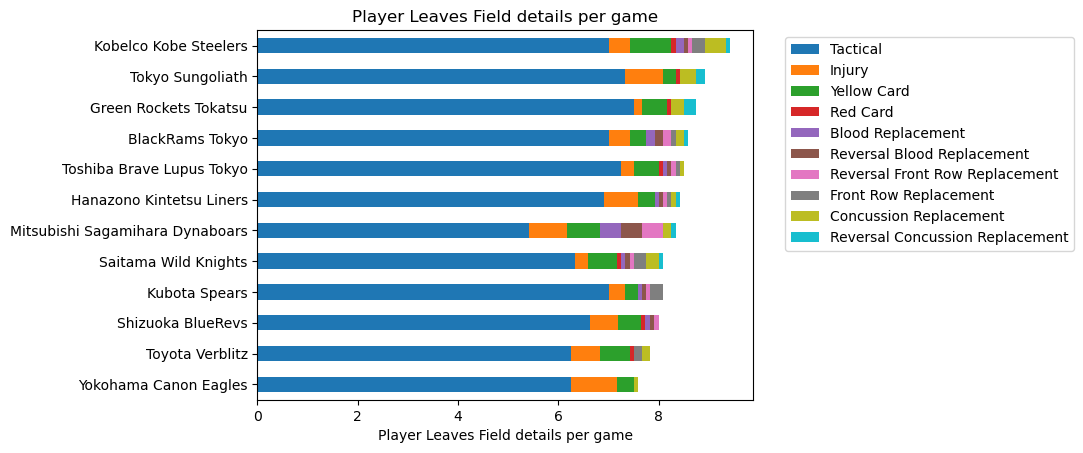

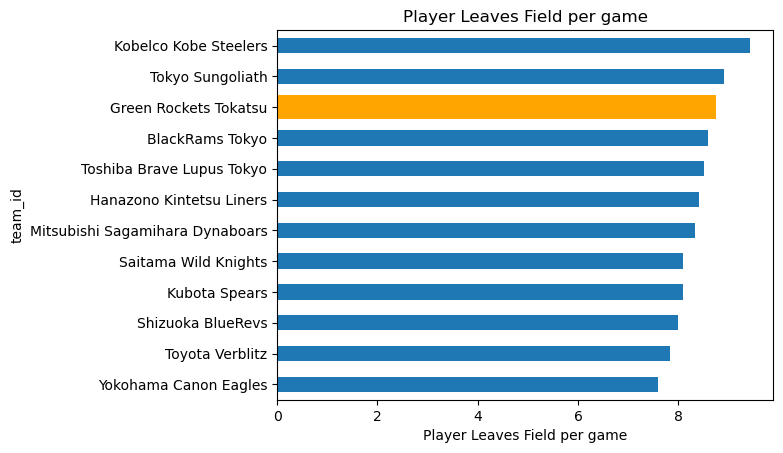

Try of Mitsubishi Sagamihara Dynaboars


qualifier3               None
ActionType Actionresult      
None       None            36

Try of Tokyo Sungoliath


qualifier3               None
ActionType Actionresult      
None       None            58

Try of Kubota Spears


qualifier3               None
ActionType Actionresult      
None       None            58

Try of Shizuoka BlueRevs


qualifier3               None
ActionType Actionresult      
None       None            34

Try of Green Rockets Tokatsu


qualifier3               None
ActionType Actionresult      
None       None            30

Try of BlackRams Tokyo


qualifier3               None
ActionType Actionresult      
None       None            43

Try of Toyota Verblitz


qualifier3               None
ActionType Actionresult      
None       None            43

Try of Yokohama Canon Eagles


qualifier3               None
ActionType Actionresult      
None       None            59

Try of Kobelco Kobe Steelers


qualifier3               None
ActionType Actionresult      
None       None            53

Try of Toshiba Brave Lupus Tokyo


qualifier3               None
ActionType Actionresult      
None       None            57

Try of Saitama Wild Knights


qualifier3               None
ActionType Actionresult      
None       None            57

Try of Hanazono Kintetsu Liners


qualifier3               None
ActionType Actionresult      
None       None            26

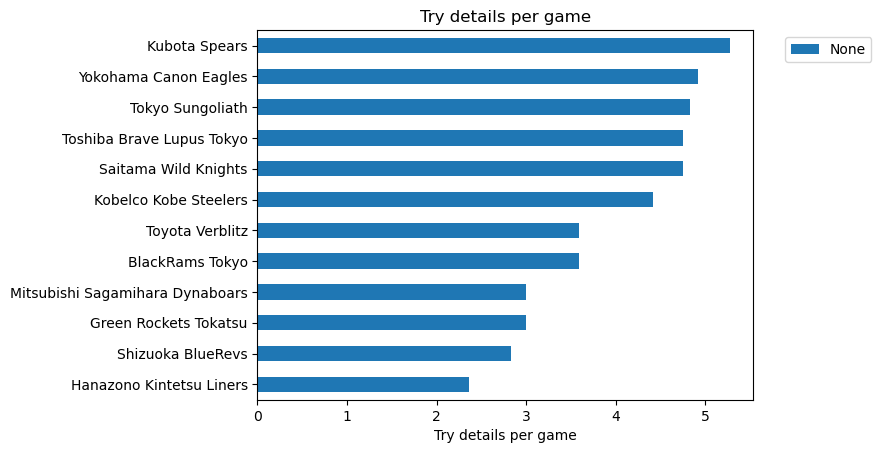

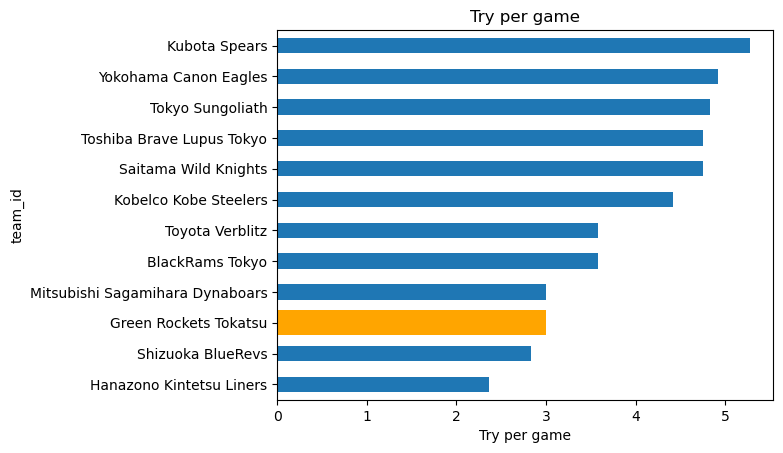

Lineout Throw of Mitsubishi Sagamihara Dynaboars


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Lost Clean                         0               0   
             Won Clean                          0               0   
Throw Back   Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  1               0   
             Lost Other                         0               0   
             Lost Overthrown                    0               0   
             Won Clean                         11               4   
             Won Other                          0               0   
             Won Penalty                        0               2   
Throw Front  Lost Clean                         0               0   
             Lost Free Kick                     0               0   
             Lost Not Straight                  0               0   
             Won Clean                         37              23   
             Won Penalty                        2               1   
             Won Tap                            0               0   
Throw Middle Lost Clean                         0               1   
             Lost Handling Error                0               0   
             Lost Not Straight                  2               0   
             Lost Overthrown                    0               0   
             Won Clean                         17               4   
             Won Free Kick                      1               0   
             Won Other                          0               0   
             Won Penalty                        1               0   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               0   

qualifier3                        Catch and Run  None  Off the Top  
ActionType   Actionresult                                           
Throw 15m+   Lost Clean                       0     0            1  
             Won Clean                        5     0            0  
Throw Back   Lost Clean                       3     0            2  
             Lost Handling Error              1     0            1  
             Lost Not Straight                0     0            0  
             Lost Other                       1     0            0  
             Lost Overthrown                  2     0            0  
             Won Clean                        1     0            8  
             Won Other                        1     0            0  
             Won Penalty                      0     0            0  
Throw Front  Lost Clean                       1     0            1  
             Lost Free Kick                   0     1            0  
             Lost Not Straight                0     0            1  
             Won Clean                        1     0            9  
             Won Penalty                      0     0            0  
             Won Tap                          1     0            2  
Throw Middle Lost Clean                       2     0            3  
             Lost Handling Error              0     0            3  
             Lost Not Straight                0     0            3  
             Lost Overthrown                  1     0            0  
             Won Clean                        1     0            5  
             Won Free Kick                    0     0            1  
             Won Other                        0     0            1  
             Won Penalty                      1     0            1  
             Won Tap                          0     0            6  
Throw Quick  Won Clean                        1     0            0

Lineout Throw of Tokyo Sungoliath


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Lost Overthrown                    0               0   
             Won Clean                          1               1   
Throw Back   Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Lost Overthrown                    0               0   
             Won Clean                          4               0   
             Won Penalty                        1               0   
             Won Tap                            1               0   
Throw Front  Lost Clean                         0               0   
             Lost Handling Error                1               0   
             Lost Not Straight                  0               0   
             Won Clean                         44               2   
             Won Other                          0               0   
             Won Penalty                        2               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         1               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Lost Overthrown                    1               0   
             Won Clean                         35              13   
             Won Free Kick                      1               0   
             Won Other                          0               0   
Throw Quick  Won Clean                          0               3   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw 15m+   Lost Overthrown                  1            0  
             Won Clean                        2            1  
Throw Back   Lost Clean                       0            1  
             Lost Handling Error              0            1  
             Lost Not Straight                0            2  
             Lost Overthrown                  1            0  
             Won Clean                        0            7  
             Won Penalty                      0            0  
             Won Tap                          0            4  
Throw Front  Lost Clean                       1            1  
             Lost Handling Error              0            1  
             Lost Not Straight                0            1  
             Won Clean                        5           24  
             Won Other                        1            0  
             Won Penalty                      0            1  
             Won Tap                          0            1  
Throw Middle Lost Clean                       0            5  
             Lost Handling Error              0            1  
             Lost Not Straight                0            2  
             Lost Overthrown                  1            0  
             Won Clean                        0           13  
             Won Free Kick                    0            0  
             Won Other                        1            0  
Throw Quick  Won Clean                        6            0

Lineout Throw of Kubota Spears


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Lost Clean                         0               0   
             Lost Overthrown                    0               0   
             Won Clean                          1               5   
             Won Other                          0               0   
Throw Back   Lost Clean                         0               0   
             Lost Not Straight                  0               1   
             Lost Overthrown                    0               0   
             Won Clean                          4               8   
             Won Tap                            0               0   
Throw Front  Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Won Clean                         10              11   
             Won Other                          1               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         0               1   
             Lost Not Straight                  2               0   
             Lost Overthrown                    0               0   
             Won Clean                         20              13   
             Won Other                          0               0   
             Won Penalty                        2               0   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               0   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw 15m+   Lost Clean                       1            0  
             Lost Overthrown                  1            0  
             Won Clean                        4            0  
             Won Other                        1            0  
Throw Back   Lost Clean                       1            1  
             Lost Not Straight                0            2  
             Lost Overthrown                  1            0  
             Won Clean                        0            1  
             Won Tap                          0            2  
Throw Front  Lost Handling Error              1            0  
             Lost Not Straight                0            1  
             Won Clean                        1            9  
             Won Other                        0            0  
             Won Tap                          0            2  
Throw Middle Lost Clean                       1            3  
             Lost Not Straight                0            1  
             Lost Overthrown                  1            0  
             Won Clean                        2            5  
             Won Other                        0            3  
             Won Penalty                      0            0  
             Won Tap                          0            3  
Throw Quick  Won Clean                        1            0

Lineout Throw of Shizuoka BlueRevs


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw Back   Lost Clean                         2               0   
             Lost Handling Error                1               0   
             Lost Not Straight                  0               0   
             Lost Overthrown                    0               0   
             Won Clean                         12               0   
             Won Other                          0               0   
             Won Penalty                        0               0   
             Won Tap                            0               0   
Throw Front  Lost Clean                         2               1   
             Lost Handling Error                0               0   
             Won Clean                         22              13   
             Won Other                          0               1   
             Won Penalty                        1               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         0               0   
             Lost Handling Error                0               1   
             Lost Not Straight                  3               1   
             Lost Overthrown                    0               0   
             Won Clean                         27              14   
             Won Free Kick                      0               0   
             Won Other                          0               0   
             Won Penalty                        3               0   
             Won Tap                            0               0   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw Back   Lost Clean                       1            1  
             Lost Handling Error              0            1  
             Lost Not Straight                0            1  
             Lost Overthrown                  0            1  
             Won Clean                        0            7  
             Won Other                        1            0  
             Won Penalty                      0            1  
             Won Tap                          0            3  
Throw Front  Lost Clean                       0            2  
             Lost Handling Error              0            1  
             Won Clean                        1           11  
             Won Other                        0            0  
             Won Penalty                      0            0  
             Won Tap                          0            2  
Throw Middle Lost Clean                       1            6  
             Lost Handling Error              0            1  
             Lost Not Straight                0            2  
             Lost Overthrown                  1            1  
             Won Clean                        1           12  
             Won Free Kick                    0            1  
             Won Other                        0            1  
             Won Penalty                      0            0  
             Won Tap                          0            5

Lineout Throw of Green Rockets Tokatsu


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Won Clean                          1               1   
Throw Back   Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Won Clean                          9               1   
             Won Free Kick                      1               0   
Throw Front  Lost Clean                         0               0   
             Lost Free Kick                     0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  1               0   
             Lost Overthrown                    0               0   
             Won Clean                         38              14   
             Won Free Kick                      0               0   
             Won Other                          0               0   
             Won Penalty                        1               1   
             Won Tap                            0               0   
Throw Middle Lost Clean                         1               1   
             Lost Handling Error                0               1   
             Lost Not Straight                  4               1   
             Lost Overthrown                    0               0   
             Won Clean                         31               5   
             Won Free Kick                      3               0   
             Won Other                          0               0   
             Won Penalty                        3               0   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               0   

qualifier3                        Catch and Run  None  Off the Top  
ActionType   Actionresult                                           
Throw 15m+   Won Clean                        1     0            0  
Throw Back   Lost Clean                       0     0            1  
             Lost Handling Error              1     0            0  
             Lost Not Straight                0     0            2  
             Won Clean                        0     0            6  
             Won Free Kick                    0     0            0  
Throw Front  Lost Clean                       0     0            2  
             Lost Free Kick                   0     1            0  
             Lost Handling Error              2     0            0  
             Lost Not Straight                0     0            1  
             Lost Overthrown                  1     0            0  
             Won Clean                        2     0           25  
             Won Free Kick                    0     0            1  
             Won Other                        1     0            0  
             Won Penalty                      1     0            2  
             Won Tap                          1     0            3  
Throw Middle Lost Clean                       0     0            8  
             Lost Handling Error              0     0            0  
             Lost Not Straight                0     0            1  
             Lost Overthrown                  2     0            0  
             Won Clean                        1     0            9  
             Won Free Kick                    0     0            0  
             Won Other                        0     0            2  
             Won Penalty                      1     0            1  
             Won Tap                          1     0            0  
Throw Quick  Won Clean                        4     0            0

Lineout Throw of BlackRams Tokyo


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Won Clean                          0               0   
Throw Back   Lost Handling Error                0               0   
             Lost Not Straight                  1               0   
             Lost Overthrown                    0               1   
             Won Clean                          2               2   
             Won Penalty                        1               0   
             Won Tap                            0               0   
Throw Front  Lost Clean                         2               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  2               1   
             Won Clean                         33              20   
             Won Other                          0               1   
             Won Penalty                        2               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         1               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Lost Overthrown                    0               1   
             Won Clean                         17               9   
             Won Other                          0               0   
             Won Penalty                        1               0   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               0   
             Won Other                          0               0   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw 15m+   Won Clean                        2            0  
Throw Back   Lost Handling Error              0            2  
             Lost Not Straight                0            1  
             Lost Overthrown                  1            0  
             Won Clean                        1            1  
             Won Penalty                      0            1  
             Won Tap                          0            2  
Throw Front  Lost Clean                       0            2  
             Lost Handling Error              1            1  
             Lost Not Straight                1            0  
             Won Clean                        2           17  
             Won Other                        0            1  
             Won Penalty                      0            0  
             Won Tap                          0            7  
Throw Middle Lost Clean                       1            4  
             Lost Handling Error              0            3  
             Lost Not Straight                0            2  
             Lost Overthrown                  0            1  
             Won Clean                        1            5  
             Won Other                        1            1  
             Won Penalty                      0            0  
             Won Tap                          0            3  
Throw Quick  Won Clean                        5            0  
             Won Other                        1            0

Lineout Throw of Toyota Verblitz


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Lost Overthrown                    0               0   
             Won Other                          0               0   
Throw Back   Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Lost Overthrown                    0               0   
             Won Clean                          6               4   
             Won Free Kick                      0               0   
             Won Tap                            0               0   
Throw Front  Lost Clean                         0               0   
             Lost Handling Error                1               0   
             Lost Not Straight                  0               0   
             Lost Other                         0               1   
             Lost Overthrown                    0               1   
             Won Clean                         21               9   
             Won Free Kick                      1               1   
             Won Other                          0               1   
             Won Tap                            0               0   
Throw Middle Lost Clean                         2               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  2               0   
             Lost Overthrown                    0               2   
             Won Clean                         22               5   
             Won Free Kick                      0               0   
             Won Other                          0               0   
             Won Tap                            0               0   
Throw Quick  Lost Clean                         0               0   
             Won Clean                          0               1   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw 15m+   Lost Overthrown                  1            0  
             Won Other                        1            0  
Throw Back   Lost Clean                       0            2  
             Lost Handling Error              0            1  
             Lost Not Straight                0            2  
             Lost Overthrown                  0            1  
             Won Clean                        0            6  
             Won Free Kick                    0            1  
             Won Tap                          1            0  
Throw Front  Lost Clean                       1            4  
             Lost Handling Error              0            0  
             Lost Not Straight                1            1  
             Lost Other                       0            0  
             Lost Overthrown                  0            0  
             Won Clean                        3           19  
             Won Free Kick                    0            1  
             Won Other                        0            0  
             Won Tap                          0            3  
Throw Middle Lost Clean                       0            1  
             Lost Handling Error              0            1  
             Lost Not Straight                0            3  
             Lost Overthrown                  0            2  
             Won Clean                        2           19  
             Won Free Kick                    1            2  
             Won Other                        0            2  
             Won Tap                          0           10  
Throw Quick  Lost Clean                       1            0  
             Won Clean                        0            0

Lineout Throw of Yokohama Canon Eagles


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Won Clean                          0               1   
Throw Back   Lost Clean                         0               0   
             Lost Not Straight                  1               1   
             Lost Overthrown                    0               0   
             Won Clean                          7               1   
             Won Free Kick                      0               0   
             Won Other                          0               0   
Throw Front  Lost Clean                         1               0   
             Lost Handling Error                0               1   
             Lost Not Straight                  1               0   
             Lost Overthrown                    0               0   
             Lost Penalty                       1               0   
             Won Clean                         46              15   
             Won Other                          0               0   
             Won Penalty                        4               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         0               0   
             Lost Free Kick                     0               0   
             Lost Not Straight                  2               0   
             Lost Overthrown                    0               0   
             Won Clean                         20               6   
             Won Other                          1               0   
             Won Penalty                        2               0   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               0   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw 15m+   Won Clean                        0            0  
Throw Back   Lost Clean                       1            1  
             Lost Not Straight                0            0  
             Lost Overthrown                  1            0  
             Won Clean                        1            0  
             Won Free Kick                    0            1  
             Won Other                        1            0  
Throw Front  Lost Clean                       1            5  
             Lost Handling Error              1            0  
             Lost Not Straight                0            2  
             Lost Overthrown                  1            0  
             Lost Penalty                     0            0  
             Won Clean                        5           11  
             Won Other                        1            1  
             Won Penalty                      1            0  
             Won Tap                          0            1  
Throw Middle Lost Clean                       3            2  
             Lost Free Kick                   0            1  
             Lost Not Straight                0            1  
             Lost Overthrown                  1            0  
             Won Clean                        0           17  
             Won Other                        0            2  
             Won Penalty                      0            2  
             Won Tap                          0            8  
Throw Quick  Won Clean                        4            0

Lineout Throw of Kobelco Kobe Steelers


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw Back   Lost Clean                         0               0   
             Lost Not Straight                  0               0   
             Lost Overthrown                    0               0   
             Won Clean                          4               6   
             Won Other                          0               1   
             Won Tap                            0               0   
Throw Front  Lost Clean                         0               0   
             Lost Free Kick                     0               0   
             Lost Not Straight                  1               0   
             Won Clean                         26               9   
             Won Free Kick                      0               0   
             Won Other                          0               0   
             Won Penalty                        1               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  1               0   
             Lost Other                         0               0   
             Lost Overthrown                    0               1   
             Won Clean                         20              12   
             Won Other                          0               0   
             Won Penalty                        1               0   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               3   

qualifier3                        Catch and Run  None  Off the Top  
ActionType   Actionresult                                           
Throw Back   Lost Clean                       0     0            2  
             Lost Not Straight                0     0            2  
             Lost Overthrown                  1     0            0  
             Won Clean                        2     0            8  
             Won Other                        0     0            1  
             Won Tap                          1     0            3  
Throw Front  Lost Clean                       1     0            1  
             Lost Free Kick                   0     1            0  
             Lost Not Straight                0     0            0  
             Won Clean                        1     0           12  
             Won Free Kick                    1     0            0  
             Won Other                        0     0            1  
             Won Penalty                      0     0            1  
             Won Tap                          0     0            3  
Throw Middle Lost Clean                       1     0            8  
             Lost Handling Error              1     0            1  
             Lost Not Straight                1     0            1  
             Lost Other                       0     0            1  
             Lost Overthrown                  0     0            0  
             Won Clean                        1     0           19  
             Won Other                        1     0            1  
             Won Penalty                      0     0            1  
             Won Tap                          0     0            9  
Throw Quick  Won Clean                        3     0            0

Lineout Throw of Toshiba Brave Lupus Tokyo


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Lost Not Straight                  0               0   
             Won Clean                          0               2   
             Won Other                          0               0   
Throw Back   Lost Clean                         0               1   
             Lost Handling Error                0               0   
             Lost Not Straight                  2               3   
             Lost Overthrown                    0               0   
             Won Clean                         10               8   
             Won Other                          0               0   
             Won Penalty                        0               0   
Throw Front  Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Lost Penalty                       0               1   
             Won Clean                         17              22   
             Won Other                          1               0   
             Won Penalty                        0               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  1               0   
             Lost Overthrown                    0               0   
             Won Clean                         26              14   
             Won Free Kick                      0               0   
             Won Other                          0               0   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               1   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw 15m+   Lost Not Straight                1            0  
             Won Clean                        4            0  
             Won Other                        2            0  
Throw Back   Lost Clean                       1            0  
             Lost Handling Error              0            2  
             Lost Not Straight                1            1  
             Lost Overthrown                  0            1  
             Won Clean                        0            4  
             Won Other                        1            1  
             Won Penalty                      0            1  
Throw Front  Lost Clean                       0            1  
             Lost Handling Error              1            0  
             Lost Not Straight                0            1  
             Lost Penalty                     0            0  
             Won Clean                        6           11  
             Won Other                        1            0  
             Won Penalty                      0            1  
             Won Tap                          0            3  
Throw Middle Lost Clean                       0            3  
             Lost Handling Error              0            1  
             Lost Not Straight                1            1  
             Lost Overthrown                  3            0  
             Won Clean                        0           10  
             Won Free Kick                    0            1  
             Won Other                        0            1  
             Won Tap                          0            3  
Throw Quick  Won Clean                        3            0

Lineout Throw of Saitama Wild Knights


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Won Clean                          0               1   
Throw Back   Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Overthrown                    0               0   
             Won Clean                         10               6   
             Won Tap                            0               0   
Throw Front  Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  1               0   
             Lost Overthrown                    0               0   
             Won Clean                         16              12   
             Won Other                          0               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         1               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Lost Overthrown                    0               0   
             Won Clean                         19               6   
             Won Other                          0               1   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               1   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw 15m+   Won Clean                        3            0  
Throw Back   Lost Clean                       1            0  
             Lost Handling Error              0            2  
             Lost Overthrown                  1            0  
             Won Clean                        1            8  
             Won Tap                          0            2  
Throw Front  Lost Clean                       0            2  
             Lost Handling Error              1            0  
             Lost Not Straight                0            0  
             Lost Overthrown                  1            0  
             Won Clean                        3           26  
             Won Other                        0            1  
             Won Tap                          0            1  
Throw Middle Lost Clean                       2            6  
             Lost Handling Error              0            4  
             Lost Not Straight                0            1  
             Lost Overthrown                  1            0  
             Won Clean                        4           20  
             Won Other                        0            2  
             Won Tap                          0            5  
Throw Quick  Won Clean                        2            0

Lineout Throw of Hanazono Kintetsu Liners


qualifier3                        Catch and Drive  Catch and Pass  \
ActionType   Actionresult                                           
Throw 15m+   Won Clean                          0               0   
             Won Other                          0               0   
Throw Back   Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               0   
             Lost Overthrown                    0               1   
             Won Clean                          3               2   
             Won Other                          0               0   
             Won Tap                            0               0   
Throw Front  Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not 5m                        0               0   
             Lost Not Straight                  1               0   
             Lost Overthrown                    0               0   
             Won Clean                         10               9   
             Won Free Kick                      1               0   
             Won Penalty                        0               0   
             Won Tap                            0               0   
Throw Middle Lost Clean                         0               0   
             Lost Handling Error                0               0   
             Lost Not Straight                  0               2   
             Lost Other                         0               0   
             Lost Overthrown                    0               0   
             Won Clean                          4               8   
             Won Free Kick                      1               0   
             Won Penalty                        0               0   
             Won Tap                            0               0   
Throw Quick  Won Clean                          0               2   

qualifier3                        Catch and Run  Off the Top  
ActionType   Actionresult                                     
Throw 15m+   Won Clean                        2            0  
             Won Other                        1            0  
Throw Back   Lost Clean                       1            2  
             Lost Handling Error              0            3  
             Lost Not Straight                0            1  
             Lost Overthrown                  0            0  
             Won Clean                        1            3  
             Won Other                        1            0  
             Won Tap                          0            3  
Throw Front  Lost Clean                       1            5  
             Lost Handling Error              0            3  
             Lost Not 5m                      1            0  
             Lost Not Straight                1            0  
             Lost Overthrown                  1            0  
             Won Clean                        2           11  
             Won Free Kick                    0            1  
             Won Penalty                      0            1  
             Won Tap                          0            3  
Throw Middle Lost Clean                       1            6  
             Lost Handling Error              0            1  
             Lost Not Straight                0            0  
             Lost Other                       1            0  
             Lost Overthrown                  0            1  
             Won Clean                        0           24  
             Won Free Kick                    0            2  
             Won Penalty                      0            2  
             Won Tap                          0            6  
Throw Quick  Won Clean                        6            0

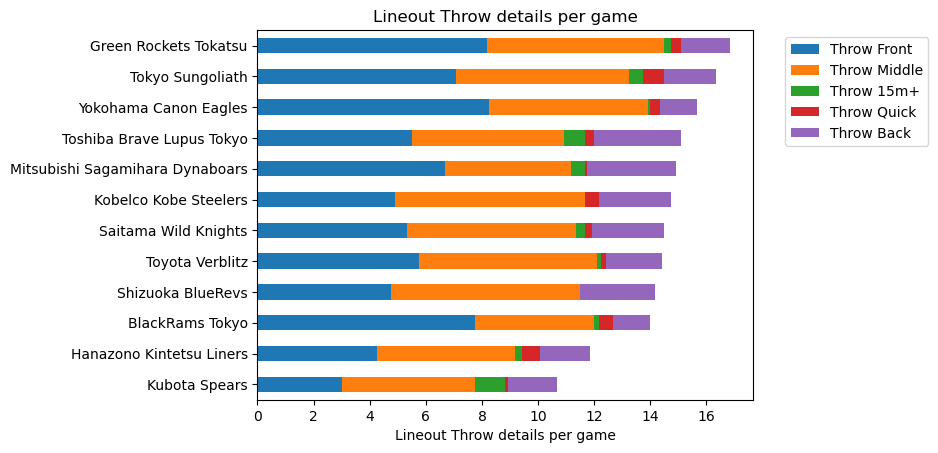

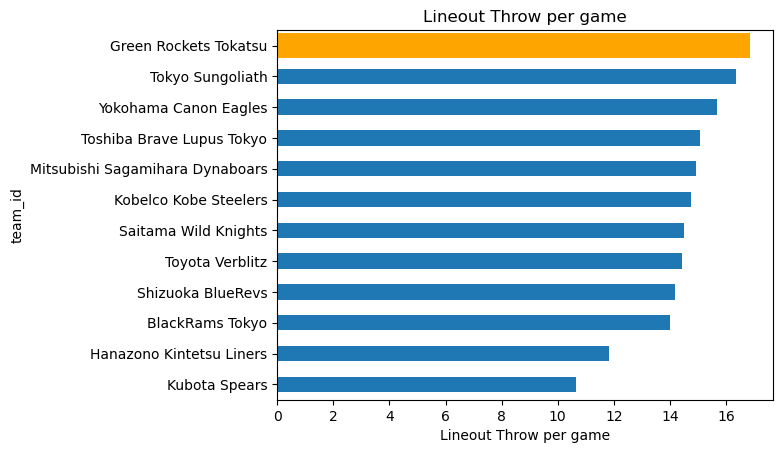

Counter Attack of Mitsubishi Sagamihara Dynaboars


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             9
Outcome - Penalty Conceded   None             2
Outcome - Penalty Won        None            10
Outcome - Scrum Won          None             1
Outcome - Try Scored         None             5
Outcome - Turnover           None             8

Counter Attack of Tokyo Sungoliath


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             5
Outcome - Kicked Out         None             4
Outcome - Penalty Conceded   None             5
Outcome - Penalty Won        None             9
Outcome - Scrum Won          None             1
Outcome - Try Scored         None             9
Outcome - Turnover           None            14

Counter Attack of Kubota Spears


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             5
Outcome - Kicked Out         None             4
Outcome - Penalty Conceded   None             5
Outcome - Penalty Won        None             4
Outcome - Scrum Won          None             1
Outcome - Try Scored         None            10
Outcome - Turnover           None            14

Counter Attack of Shizuoka BlueRevs


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             7
Outcome - Kicked Out         None             1
Outcome - Penalty Conceded   None             4
Outcome - Penalty Won        None             9
Outcome - Scrum Won          None             1
Outcome - Try Scored         None             3
Outcome - Turnover           None            10

Counter Attack of Green Rockets Tokatsu


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             5
Outcome - Kicked Out         None             2
Outcome - Penalty Conceded   None             6
Outcome - Penalty Won        None            10
Outcome - Try Scored         None             4
Outcome - Turnover           None            11

Counter Attack of BlackRams Tokyo


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None            16
Outcome - Kicked Out         None             4
Outcome - Lineout Won        None             2
Outcome - Penalty Conceded   None             3
Outcome - Penalty Won        None             7
Outcome - Try Scored         None             8
Outcome - Turnover           None            13

Counter Attack of Toyota Verblitz


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             6
Outcome - Kicked Out         None             4
Outcome - Lineout Won        None             1
Outcome - Penalty Conceded   None             5
Outcome - Penalty Won        None            10
Outcome - Scrum Won          None             2
Outcome - Try Scored         None             4
Outcome - Turnover           None            22

Counter Attack of Yokohama Canon Eagles


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None            10
Outcome - Kicked Out         None             2
Outcome - Penalty Conceded   None             5
Outcome - Penalty Won        None            12
Outcome - Scrum Won          None             1
Outcome - Try Scored         None             8
Outcome - Turnover           None            11

Counter Attack of Kobelco Kobe Steelers


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             1
Outcome - Penalty Conceded   None             3
Outcome - Penalty Won        None            10
Outcome - Try Scored         None            12
Outcome - Turnover           None            27

Counter Attack of Toshiba Brave Lupus Tokyo


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             4
Outcome - Kicked Out         None             5
Outcome - Penalty Conceded   None             7
Outcome - Penalty Won        None            10
Outcome - Scrum Won          None             3
Outcome - Try Scored         None            14
Outcome - Turnover           None            18

Counter Attack of Saitama Wild Knights


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None            10
Outcome - Kicked Out         None             5
Outcome - Penalty Conceded   None             4
Outcome - Penalty Won        None             6
Outcome - Scrum Won          None             2
Outcome - Try Scored         None            11
Outcome - Turnover           None            10

Counter Attack of Hanazono Kintetsu Liners


qualifier3                                 None
ActionType                   Actionresult      
Outcome - Kick To Opposition None             7
Outcome - Penalty Conceded   None             4
Outcome - Penalty Won        None            10
Outcome - Scrum Won          None             1
Outcome - Try Scored         None             6
Outcome - Turnover           None            17

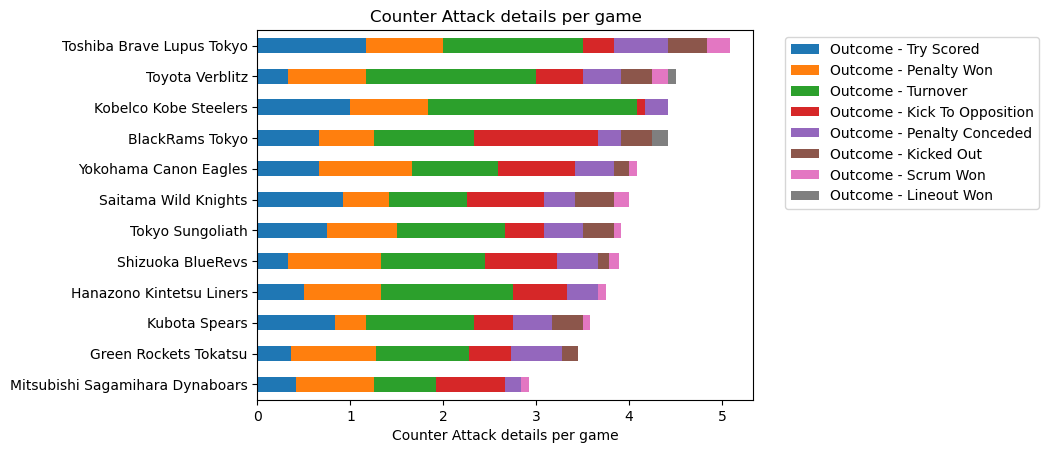

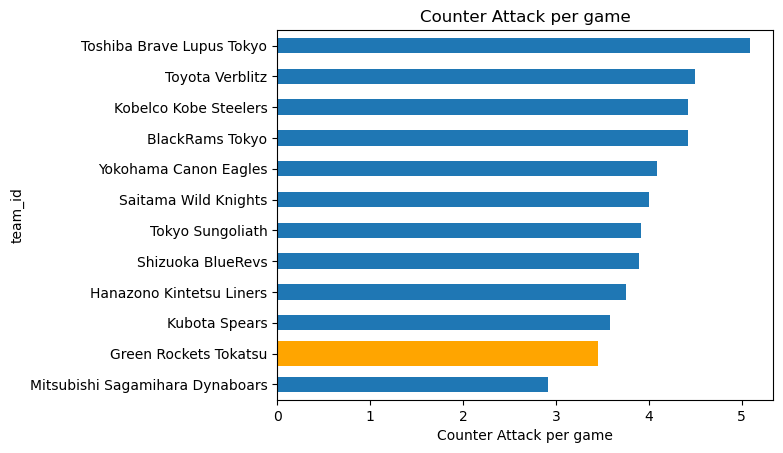

Card of Mitsubishi Sagamihara Dynaboars


qualifier3                           None
ActionType  Actionresult                 
Yellow Card Foul Play                   5
            Persistent Infringement     1
            Professional Foul           2

Card of Tokyo Sungoliath


qualifier3                           None
ActionType  Actionresult                 
Red Card    Foul Play                   1
Yellow Card Foul Play                   1
            Persistent Infringement     1
            Professional Foul           1

Card of Kubota Spears


qualifier3                     None
ActionType  Actionresult           
Yellow Card Foul Play             1
            Professional Foul     2

Card of Shizuoka BlueRevs


qualifier3                           None
ActionType  Actionresult                 
Red Card    Foul Play                   1
Yellow Card Foul Play                   1
            Persistent Infringement     2
            Professional Foul           2

Card of Green Rockets Tokatsu


qualifier3                           None
ActionType  Actionresult                 
Red Card    Foul Play                   1
Yellow Card Foul Play                   2
            Persistent Infringement     1
            Professional Foul           3

Card of BlackRams Tokyo


qualifier3                           None
ActionType  Actionresult                 
Yellow Card Foul Play                   1
            Persistent Infringement     2
            Professional Foul           1

Card of Toyota Verblitz


qualifier3                           None
ActionType  Actionresult                 
Red Card    Foul Play                   1
Yellow Card Foul Play                   2
            Persistent Infringement     2
            Professional Foul           3

Card of Yokohama Canon Eagles


qualifier3                           None
ActionType  Actionresult                 
Yellow Card Dissent                     1
            Foul Play                   1
            Persistent Infringement     1
            Professional Foul           1

Card of Kobelco Kobe Steelers


qualifier3                     None
ActionType  Actionresult           
Red Card    Foul Play             1
Yellow Card Foul Play             4
            Professional Foul     6

Card of Toshiba Brave Lupus Tokyo


qualifier3                           None
ActionType  Actionresult                 
Red Card    Foul Play                   1
Yellow Card Fighting                    1
            Foul Play                   1
            Persistent Infringement     2
            Professional Foul           2

Card of Saitama Wild Knights


qualifier3                           None
ActionType  Actionresult                 
Red Card    Foul Play                   1
Yellow Card Foul Play                   2
            Persistent Infringement     2
            Professional Foul           3

Card of Hanazono Kintetsu Liners


qualifier3                           None
ActionType  Actionresult                 
Yellow Card Foul Play                   1
            Persistent Infringement     1
            Professional Foul           2

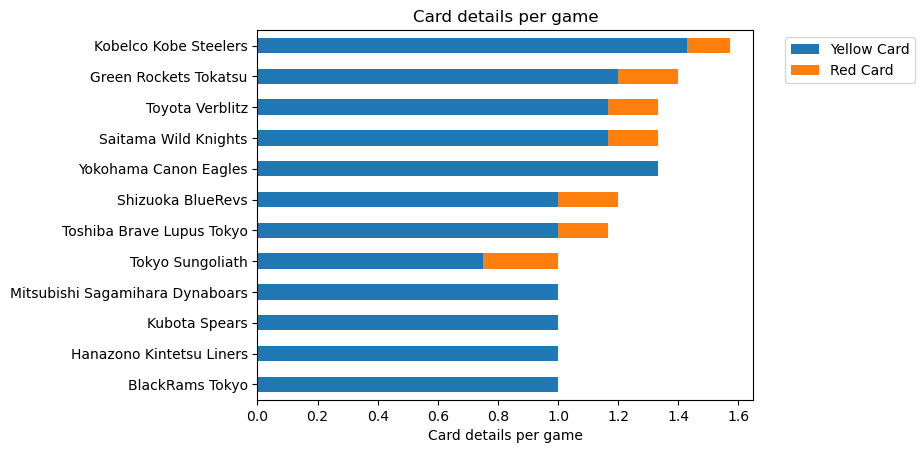

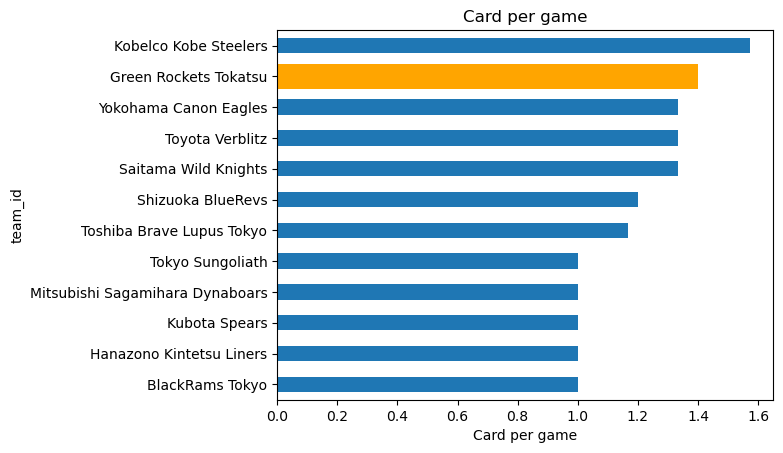

Player Enters Field of Mitsubishi Sagamihara Dynaboars


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             5
Concussion Replacement          None             2
Injury                          None             9
Reversal Blood Replacement      None             5
Reversal Concussion Replacement None             1
Tactical                        None            64
Yellow Card                     None             6

Player Enters Field of Tokyo Sungoliath


qualifier3                                    None
ActionType                      Actionresult      
Concussion Replacement          None             4
Injury                          None             9
Reversal Concussion Replacement None             2
Tactical                        None            88
Yellow Card                     None             2

Player Enters Field of Kubota Spears


qualifier3                                   None
ActionType                     Actionresult      
Blood Replacement              None             1
Front Row Replacement          None             3
Injury                         None             4
Reversal Blood Replacement     None             1
Reversal Front Row Replacement None             1
Tactical                       None            84
Yellow Card                    None             2

Player Enters Field of Shizuoka BlueRevs


qualifier3                               None
ActionType                 Actionresult      
Blood Replacement          None             1
Injury                     None             4
Reversal Blood Replacement None             1
Tactical                   None            73
Yellow Card                None             3

Player Enters Field of Green Rockets Tokatsu


qualifier3                                    None
ActionType                      Actionresult      
Concussion Replacement          None             3
Injury                          None             2
Reversal Concussion Replacement None             3
Tactical                        None            89
Yellow Card                     None             6

Player Enters Field of BlackRams Tokyo


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             2
Concussion Replacement          None             2
Front Row Replacement           None             1
Injury                          None             5
Reversal Blood Replacement      None             2
Reversal Concussion Replacement None             1
Reversal Front Row Replacement  None             1
Tactical                        None            88
Yellow Card                     None             2

Player Enters Field of Toyota Verblitz


qualifier3                                   None
ActionType                     Actionresult      
Concussion Replacement         None             2
Front Row Replacement          None             2
Injury                         None             7
Reversal Front Row Replacement None             2
Tactical                       None            75
Yellow Card                    None             4

Player Enters Field of Yokohama Canon Eagles


qualifier3                           None
ActionType             Actionresult      
Concussion Replacement None             1
Injury                 None            10
Tactical               None            75
Yellow Card            None             3

Player Enters Field of Kobelco Kobe Steelers


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             2
Concussion Replacement          None             5
Front Row Replacement           None             3
Injury                          None             5
Reversal Blood Replacement      None             1
Reversal Concussion Replacement None             1
Reversal Front Row Replacement  None             2
Tactical                        None            85
Yellow Card                     None             8

Player Enters Field of Toshiba Brave Lupus Tokyo


qualifier3                               None
ActionType                 Actionresult      
Blood Replacement          None             1
Concussion Replacement     None             1
Front Row Replacement      None             1
Injury                     None             2
Reversal Blood Replacement None             1
Tactical                   None            87
Yellow Card                None             5

Player Enters Field of Saitama Wild Knights


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             1
Concussion Replacement          None             3
Front Row Replacement           None             3
Injury                          None             3
Reversal Blood Replacement      None             1
Reversal Concussion Replacement None             1
Tactical                        None            76
Yellow Card                     None             4

Player Enters Field of Hanazono Kintetsu Liners


qualifier3                                    None
ActionType                      Actionresult      
Blood Replacement               None             1
Concussion Replacement          None             1
Front Row Replacement           None             1
Injury                          None             8
Reversal Blood Replacement      None             1
Reversal Concussion Replacement None             1
Reversal Front Row Replacement  None             1
Tactical                        None            76
Yellow Card                     None             4

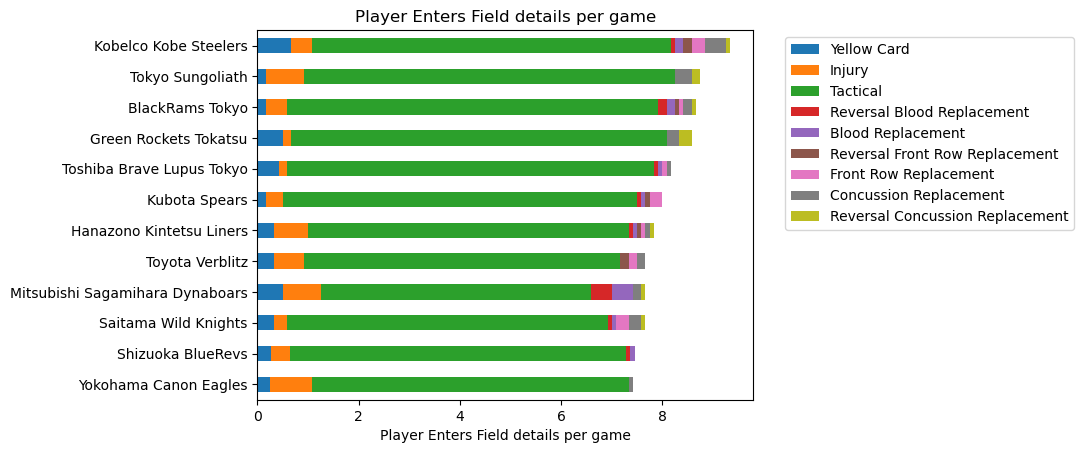

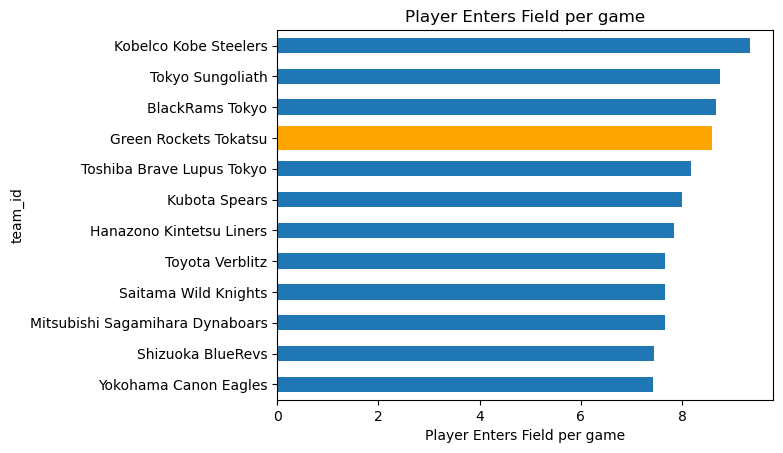

Team: Green Rockets Tokatsu, Average: 6.3238095238095235
Team: Yokohama Canon Eagles, Average: 5.700934579439252
Team: Toshiba Brave Lupus Tokyo, Average: 6.31858407079646
Team: Shizuoka BlueRevs, Average: 7.027777777777778
Team: Kubota Spears, Average: 6.158878504672897
Team: Hanazono Kintetsu Liners, Average: 6.699029126213592
Team: Saitama Wild Knights, Average: 6.371681415929204
Team: Toyota Verblitz, Average: 6.914285714285715
Team: BlackRams Tokyo, Average: 6.364485981308412
Team: Mitsubishi Sagamihara Dynaboars, Average: 6.330357142857143
Team: Tokyo Sungoliath, Average: 8.097826086956522
Team: Kobelco Kobe Steelers, Average: 6.96


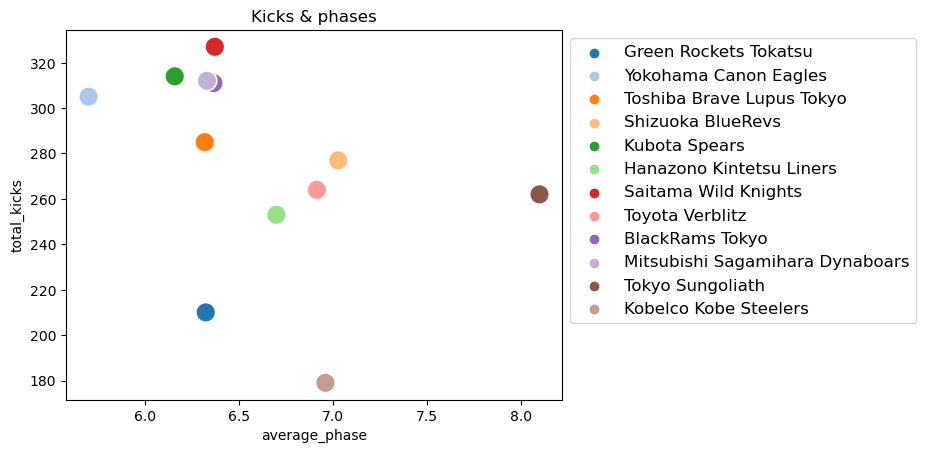

---------------


In [ ]:
FILEPATH = '/Users/isakakou/Desktop/22-23_super_scout/933713_CANOvNECG_advanced_superscout.xml'
TEAMNAME = 'Green Rockets Tokatsu'
# パスで指定したファイルの一覧をリスト形式で取得.
directory = glob.glob('/Users/isakakou/Desktop/22-23_super_scout/*.xml')

# df = read_all(directory)
# display(df)
summarize_competition(directory)
# df = read_xml(FILEPATH)
team_list = ["Green Rockets Tokatsu", "Yokohama Canon Eagles","Toshiba Brave Lupus Tokyo","Shizuoka BlueRevs","Kubota Spears",
            "Hanazono Kintetsu Liners", "Saitama Wild Knights","Toyota Verblitz","BlackRams Tokyo","Mitsubishi Sagamihara Dynaboars",
            "Tokyo Sungoliath","Kobelco Kobe Steelers"]
# count_average_phases(df, team_list)
average_phase_kick_corr(df, team_list)
print("---------------")
count_average_defending_phases(directory)
# sns.lineplot(x="sequence_id", y="score_advantage", data=df)
# pd_df = pd.get_dummies(df[['PLID','team_id','MatchTime','psID','period',
#                'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
#                'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum']])
# df = read_all(directory)
# count_ball_movement(df, TEAMNAME)
# calculate_gainline_crossed_rate(df, TEAMNAME)
# kick(df,TEAMNAME)
# Kubota Spears
# Green Rockets Tokatsu
# ruck_speed(df, TEAMNAME)
# carry_meter(df, TEAMNAME)
# lineout(df,TEAMNAME)
# twenty_two_entry(df,TEAMNAME)
# possession_detail(df, TEAMNAME)
# pass_table(df, TEAMNAME)
# tackle_player_table(df, TEAMNAME)
# tackle_player_table(df, TEAMNAME)
# defensive_penalty(df, TEAMNAME)
# attack_OOA(df,TEAMNAME)
# get_opponent(df, TEAMNAME)
# try_detail(df, get_opponent(df, TEAMNAME))
# plot_rucks_per_possession(df,TEAMNAME)
# tackle_detail(df, TEAMNAME)
# turnover(df,TEAMNAME)
# kicks_from_all_game(directory, TEAMNAME)

# --------------------------------------------------------------------------
#読み込むファイルのリストを走査
# for file in directory:
#     print(file)
#     data = read_xml(file)
#     ruck_speed(data, TEAMNAME)
#     OPPONENT = get_opponent(data,TEAMNAME)
#     plot_rucks_per_possession(data,OPPONENT)

In [ ]:
# df = read_xml('/Users/isakakou/Desktop/22-23_super_scout/933717_DYNAvSHBR_advanced_superscout.xml')
directory = glob.glob('/Users/isakakou/Desktop/22-23_super_scout/*.xml')
df = read_all(directory)

le = LabelEncoder()
df['Actionresult'] = le.fit_transform(df['Actionresult'])
dummies = pd.get_dummies(df[['action','PLID', 'ActionType','FXID']])
coords = df[['x_coord','y_coord','x_coord_end','y_coord_end']]
X = pd.concat([dummies,coords],axis=1)
# df[['x_coord', 'y_coord']].fillna(0)
y = df['Actionresult']
X_train, X_test, y_train, y_test = train_test_split(X,y)
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
print("正解率:",score*100, "%")
df2 = pd.DataFrame(X_test)

# Define Neural Network model
clf = MLPClassifier(hidden_layer_sizes=20, activation='relu',
                    solver='adam', max_iter=1000)
# Lerning model
clf.fit(X_train, y_train)
print("ニューラルネットワーク正解率:",clf.score(X_train, y_train)*100,'%')
print(clf.predict(X_test))
# print(df2)
# plot_boundary(model, X_test['x_coord'],X_test['y_coord'],y_test,"df2[0]", "df2[1]")